# **EXP5 Dissociated and Classic Bulks Deconvolution by Adding More Cells**

Data downloaded from GEO Omnibus: https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE217517

Cell types per sample from original paper can be accessed here: https://github.com/greenelab/deconvolution_pilot/tree/main/data/cell_labels


**Summary:**
Evaluating the effect of (hypothesized) missing cell-types in the residual of real bulks deconvolved with a missing cell-type reference.

We are using single-cell and bulk matched samples from 8 patients. Each sample has a dissociated sample with ribosomal RNA depletion (-rRNA), non-dissociated sample with ribosomal RNA depletion (-rRNA), and dissociated sample with polyA tail capture (polyA). We are attempting to find evidence in the residual of a missing cell type (adipocyte) only in dissociated samples.

**Hypothesis:**
Dissociation process depletes the single-cell and bulk samples from adipocytes. Thus, only non-dissociated bulks show evidence of adipocytes in the residual. This will be evident by adipocyte-related gene expression in the residual of dissociates bulks compared to non-dissociated bulks.

**Deconv. Method:**
NNLS

**Factorization Methods:**
PCA, NMF

In [1]:
# import the dependencies
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
sys.path.insert(1, '../../../../../')

from functions import sn_sc_preprocess
from functions import validation_processing as vp
from importlib import reload
reload(sn_sc_preprocess)
reload(vp)
# general imports
import warnings
import numpy as np
from numpy import random
from numpy import array
from numpy import diag
from numpy import dot
from numpy import zeros
import pandas as pd
import scanpy as sc
from anndata import AnnData as ad
from tabulate import tabulate

import tensorflow as tf
import sklearn as sk
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import FunctionTransformer
import scipy as sp
from scipy.stats import spearmanr, pearsonr
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from scipy.stats import wilcoxon
import scipy.stats as stats
from collections import Counter
import scipy as sp
from scipy.optimize import nnls
from scipy.stats import ttest_ind
# Images, plots, display, and visualization
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import matplotlib.colors as mcolors
import seaborn as sns

import seaborn as sns
from scipy import stats
#sklearns
from sklearn.decomposition import FastICA
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

# programming stuff
import time
import os, sys
from io import StringIO 
import pickle
import requests
from pathlib import Path

In [2]:
#####################
### set the study ###
#####################
#results paths:
res_name = "MCT_hgsoc_EXP4"
actual_path = os.getcwd()
data_path = f"{actual_path}/../data/EXP4/"
cibersort_results_path = f"{actual_path}/../data/EXP4/cibersort_results/"
cibersort_path = f"{actual_path}/../data/EXP4/cibersort/"
random_seed = 88
nmf_cut = 'minimum_value'
num_samples = 10000
prop_type = "real"
bulks_type= f"{prop_type}"
use_all_genes = False
add_adipo = True

In [3]:
# Paths:
res_name_adip = f"MCT_adp_EXP3"
pseudo_name_adip = "MCT_adp_EXP3"
files_path_adip= "/../data/EXP3/"
path_results_adip = "/../results/EXP3/"
data_path_adip = "/../data/EXP3/cibersort/"
cibersort_files_adip = (
    "/../data/EXP3/cibersort_results/realisticprop_nonoise_0missing/"
    "CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_phenoclasses."
    "CIBERSORTx_MCT_adp_EXP3_realisticprop_nonoise_0missing_signal_inferred_refsample.bm.K999.txt")
# parameters into paths
actual_path_adip = os.getcwd()
path_adip = f"{actual_path_adip}{files_path_adip}"
aug_data_path_adip = f"{actual_path_adip}{files_path_adip}"
cibersort_path_adip = f"{actual_path_adip}{cibersort_files_adip}"
path_results_adip = f"{actual_path_adip}{path_results_adip}"
data_path_adip = f"{actual_path_adip}{data_path_adip}"

## **Reading and QCing the data:**

Classic Bulks (Not Dissociated)

In [4]:
bulks_path = os.path.join(data_path, f"{res_name}_bulks.csv")
bulks_path = Path(bulks_path)
bulks = pd.read_csv(bulks_path)
bulks = bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
bulks  = bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            7        0      0           6           0           1   
2467            1        0      0          12           0           0   
2380            0        0      0           3           0           0   
2293            0        0      0           2           0           0   
2283            8        0      0           5           0           3   
2428            0        0      0           5           0           1   
2251            2        0      0           6           0           2   
2267            0        0      0           5           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          28           0           6           1  ...           0   
2467          77           0          10           0  ...           0   
2380          51           0           7           0  ...           0   
2293          27           0          12           0  ...           0   
2283          59           0           0           0  ...           0   
2428          26           0          10           0  ...           0   
2251          47           0           6           0  ...           0   
2267          81           1           3           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          16           0           0           6           2           4   
2467          81           0           0           0           2           0   
2380           1           0           6           1           0           0   
2293          54           0           0           0           1           0   
2283           3           0           0           0           0           0   
2428           8           0           0           0           0           0   
2251           0           0           2          13           0           0   
2267           7           0           1           3           0           0   

      AC007325.4  AC007325.2   condition  
2497          47          36  rrna_chunk  
2467          18          13  rrna_chunk  
2380          10          23  rrna_chunk  
2293           8           0  rrna_chunk  
2283          18          34  rrna_chunk  
2428          46          24  rrna_chunk  
2251          16           7  rrna_chunk  
2267           2           3  rrna_chunk  

[8 rows x 36602 columns]

Dissociated Bulks:

In [5]:
dbulks_path = os.path.join(data_path, f"{res_name}_dissociated_bulks.csv")
dbulks_path = Path(dbulks_path)
diss_bulks = pd.read_csv(dbulks_path)
diss_bulks = diss_bulks.drop(labels=["Unnamed: 0"], axis=1)
#the bulks come in this index:
diss_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
diss_bulks  = diss_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
diss_bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            3        0      0           2           0           0   
2467            1        0      0           5           0           0   
2380            4        0      0           2           0           0   
2293            2        0      0           4           0           0   
2283            1        0      0           1           0           0   
2428            3        2      0           1           0           0   
2251            8        0      0           1           0           1   
2267            1        0      0           1           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          15           0           1           0  ...           0   
2467          63           1           6           0  ...           0   
2380          37           0           2           0  ...           0   
2293          31           0           3           0  ...           0   
2283          33           0           2           0  ...           0   
2428           7           0           5           0  ...           0   
2251          38           0           0           0  ...           0   
2267          26           0           5           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          19           0           1           1           3           4   
2467          27           0           0           0           0           0   
2380           2           0           0           0           0           0   
2293           6           0           0           6           0           0   
2283           6           0           0           1           0           0   
2428          17           0           0           2           0           0   
2251           4           0           0           4           0           0   
2267          19           0           2          11           0           1   

      AC007325.4  AC007325.2  condition  
2497          39          28  rrna_diss  
2467           8           6  rrna_diss  
2380          10          21  rrna_diss  
2293           6           2  rrna_diss  
2283          20          16  rrna_diss  
2428          57          30  rrna_diss  
2251          10           9  rrna_diss  
2267          15           3  rrna_diss  

[8 rows x 36602 columns]

Dissociated polyA:

In [6]:
disspolyA_bulks_path = os.path.join(data_path, f"{res_name}_dissociatedpolyA_bulks.csv")
disspolyA_bulks_path = Path(disspolyA_bulks_path)
disspolya_bulks = pd.read_csv(disspolyA_bulks_path)
disspolya_bulks = disspolya_bulks.drop(labels=["Unnamed: 0"], axis = 1)
#the bulks come in this index:
disspolya_bulks.index = ['2251', '2267', '2283', '2293', '2380',  '2428', '2467', '2497']
# and we'll reorderby sample type:
disspolya_bulks  = disspolya_bulks.reindex(index=['2497', '2467', '2380', '2293', '2283','2428','2251', '2267'])
disspolya_bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497           17        2      0          10           0           2   
2467            2        1      0           7           0           3   
2380            5        1      0           6           0           0   
2293            4        0      0          13           0           4   
2283            7        0      0          11           0           9   
2428            0        0      0           1           0           0   
2251            2        0      0           6           0           1   
2267            0        0      0           5           0           1   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          66           0          15           1  ...           1   
2467         134           0           8           0  ...           4   
2380         159           0          16           0  ...           0   
2293          92           0           5           0  ...           0   
2283         114           0          12           0  ...           0   
2428          14           0          10           0  ...           0   
2251          93           0           9           1  ...           0   
2267          69           0          12           0  ...           1   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          35           0           0           9           9           7   
2467          58           0           1           2           0           0   
2380           2           0           2           6           0           0   
2293          16           0           0           1           0           0   
2283           9           0           0           1           0           0   
2428          35           0           0           6           0           0   
2251           6           0           2          16           0           0   
2267          33           0           4          30           0           0   

      AC007325.4  AC007325.2   condition  
2497          56          78  polyA_diss  
2467          15          11  polyA_diss  
2380          27          32  polyA_diss  
2293           4           6  polyA_diss  
2283          10          17  polyA_diss  
2428          51          27  polyA_diss  
2251          10          12  polyA_diss  
2267           6           3  polyA_diss  

[8 rows x 36602 columns]

And all single-cells:

In [7]:
#saved as anndata objects
adata_path = os.path.join(data_path, f"{res_name}_adata1_notlog.h5ad")
adata_path = Path(adata_path)
adata_1 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata2_notlog.h5ad")
adata_path = Path(adata_path)
adata_2 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata3_notlog.h5ad")
adata_path = Path(adata_path)
adata_3 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata4_notlog.h5ad")
adata_path = Path(adata_path)
adata_4 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata5_notlog.h5ad")
adata_path = Path(adata_path)
adata_5 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata6_notlog.h5ad")
adata_path = Path(adata_path)
adata_6 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata7_notlog.h5ad")
adata_path = Path(adata_path)
adata_7 = sc.read_h5ad(adata_path)

adata_path = os.path.join(data_path, f"{res_name}_adata8_notlog.h5ad")
adata_path = Path(adata_path)
adata_8 = sc.read_h5ad(adata_path)

In [8]:
#attaching adatas (single-cells) into dict
adatas=dict()
adatas[1] = adata_1
adatas[2] = adata_2
adatas[3] = adata_3
adatas[4] = adata_4
adatas[5] = adata_5
adatas[6] = adata_6
adatas[7] = adata_7
adatas[8] = adata_8
#QC
for adata in adatas.items():
    print(adata[1])

AnnData object with n_obs × n_vars = 3102 × 28313
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1039 × 28578
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 1088 × 28704
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
AnnData object with n_obs × n_vars = 4329 × 24272
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',

In [9]:
#Our ground truth in this case is single cell! But'll we'll merge them to get more cells.
prop_df = dict()
for num in adatas:
    prop_df[num], adatas[num] = vp.get_prop(adatas[num])
for  adata in adatas:
    print(Counter(adatas[adata].obs["cell_types"]))
    print(" ")    

                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   62    0.019987
DC                        13    0.004191
Endothelial cells        503    0.162153
Epithelial cells          56    0.018053
Fibroblasts              206    0.066409
ILC                       24    0.007737
Macrophages              123    0.039652
Monocytes                 54    0.017408
NK cells                 114    0.036750
Plasma cells            1432    0.461638
T cells                  506    0.163121
pDC                        9    0.002901
                   Num_Cells  Prop_Cells
Cell_Types                              
B cells                   41    0.039461
DC                         6    0.005775
Endothelial cells         18    0.017324
Epithelial cells          99    0.095284
Fibroblasts               13    0.012512
Macrophages               26    0.025024
Monocytes                 17    0.016362
NK cells                  67    0.064485
Plasma cells    

Making genes the same in all single-cell datas, and merging.

In [10]:
# Extract the values (Anndata objects) from the dictionary
adatas_list = list(adatas.values())

# Concatenate the Anndata objects into a single object
merged_adata = sc.concat(adatas_list, join='inner')
merged_adata.var['gene_ids'] = merged_adata.var_names
merged_adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


AnnData object with n_obs × n_vars = 17438 × 13724
    obs: 'cell_types', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids'

## Adding Adipocyte and Medothelial Cells to Reference (if set)

In [11]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
print("genes to keep per experiment:")
#name is long so we're cutting it
cut_str1 = "missing_signal_inferred_phenoclasses.CIBERSORTx_"
cut_str2 = "missing_signal_inferred_refsample.bm.K999.txt"
for num in adatas:    
    # read in cibersort genes from cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, 
        f"CIBERSORTx_{res_name}_{bulks_type}_{num}{cut_str1}{res_name}_{bulks_type}_{num}{cut_str2}")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

In [12]:
cibersort_df = pd.read_csv(cibersort_path_adip, sep="\t")
cibersort_genes_adip = cibersort_df["NAME"].values

cibersort_genes = np.unique(np.concatenate((cibersort_genes,cibersort_genes_adip)))
cibersort_genes.shape

(6037,)

In [13]:
#and as anndata object single nucleus 
adata_path_adip = os.path.join(path_adip, f"MCT_adp_EXP3_snadata_notlog.h5ad")
adata_path_adip = Path(adata_path_adip)
sn_adata = sc.read_h5ad(adata_path_adip)
cells_to_keep = ["Fat cell", "fat cell"]
sn_adata = sn_adata[sn_adata.obs.cell_types.isin(cells_to_keep)]
sn_adata.obs.cell_types.value_counts()

Fat cell    24825
Name: cell_types, dtype: int64

In [14]:
genes_adatas = np.intersect1d(merged_adata.var["gene_ids"].values, sn_adata.var["gene_ids"].values)
merged_adata = merged_adata[:, genes_adatas]
sn_adata = sn_adata[:, genes_adatas]
merged_adata = sc.concat([sn_adata, merged_adata])
merged_adata.obs_names_make_unique()
print(merged_adata.obs.cell_types.value_counts())

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


Fat cell             24825
T cells               7419
Plasma cells          1983
Epithelial cells      1694
Fibroblasts           1587
Endothelial cells     1189
Macrophages           1116
NK cells               842
Unknown1               512
Monocytes              272
B cells                264
pDC                    170
Unknown2               155
DC                      98
ILC                     89
Mast cells              27
Erythroid               21
Name: cell_types, dtype: int64


In [15]:
if add_adipo:
    print("Keeping all cells")
    print(merged_adata.obs.cell_types.value_counts())
else:
    print("Removing adipocytes")
    merged_adata = merged_adata[merged_adata.obs.cell_types != "Fat cell"]
    print(merged_adata.obs.cell_types.value_counts())

Keeping all cells
Fat cell             24825
T cells               7419
Plasma cells          1983
Epithelial cells      1694
Fibroblasts           1587
Endothelial cells     1189
Macrophages           1116
NK cells               842
Unknown1               512
Monocytes              272
B cells                264
pDC                    170
Unknown2               155
DC                      98
ILC                     89
Mast cells              27
Erythroid               21
Name: cell_types, dtype: int64


And final formatting on the bulks:

In [16]:
#combining the dissociated and non dissociated
combo = pd.DataFrame(np.concatenate([bulks.values, diss_bulks.values]), 
index = range(1,17), columns = bulks.columns)

In [17]:
#making sure index matches:
sample_ids = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks.index = sample_ids
diss_bulks.index = sample_ids
disspolya_bulks.index = sample_ids
combo.index = sample_ids * 2
bulks

MIR1302-2HG  FAM138A  OR4F5  AL627309.1  AL627309.3  AL627309.2  \
2497            7        0      0           6           0           1   
2467            1        0      0          12           0           0   
2380            0        0      0           3           0           0   
2293            0        0      0           2           0           0   
2283            8        0      0           5           0           3   
2428            0        0      0           5           0           1   
2251            2        0      0           6           0           2   
2267            0        0      0           5           0           0   

      AL627309.5  AL627309.4  AP006222.2  AL732372.1  ...  AC136612.1  \
2497          28           0           6           1  ...           0   
2467          77           0          10           0  ...           0   
2380          51           0           7           0  ...           0   
2293          27           0          12           0  ...           0   
2283          59           0           0           0  ...           0   
2428          26           0          10           0  ...           0   
2251          47           0           6           0  ...           0   
2267          81           1           3           0  ...           0   

      AC136616.1  AC136616.3  AC136616.2  AC141272.1  AC023491.2  AC007325.1  \
2497          16           0           0           6           2           4   
2467          81           0           0           0           2           0   
2380           1           0           6           1           0           0   
2293          54           0           0           0           1           0   
2283           3           0           0           0           0           0   
2428           8           0           0           0           0           0   
2251           0           0           2          13           0           0   
2267           7           0           1           3           0           0   

      AC007325.4  AC007325.2   condition  
2497          47          36  rrna_chunk  
2467          18          13  rrna_chunk  
2380          10          23  rrna_chunk  
2293           8           0  rrna_chunk  
2283          18          34  rrna_chunk  
2428          46          24  rrna_chunk  
2251          16           7  rrna_chunk  
2267           2           3  rrna_chunk  

[8 rows x 36602 columns]

Assigning genes: 

In [18]:
#Reading in the CIBERSORTx barcode genes
cibersort_ref = dict()
cibersort_genes = dict()
print("genes to keep per experiment:")
#name is long so we're cutting it
cut_str1 = "missing_signal_inferred_phenoclasses.CIBERSORTx_"
cut_str2 = "missing_signal_inferred_refsample.bm.K999.txt"
for num in adatas:    
    # read in cibersort genes from cibersort reference
    cibersort_path_ = os.path.join(cibersort_results_path, 
        f"CIBERSORTx_{res_name}_{bulks_type}_{num}{cut_str1}{res_name}_{bulks_type}_{num}{cut_str2}")
    cibersort_path_ = Path(cibersort_path_)
    cibersort_df = pd.read_csv(cibersort_path_, sep="\t")
    cibersort_genes[num] = pd.DataFrame(columns = cibersort_df["NAME"].values.tolist())
    cibersort_df.index = cibersort_genes[num].columns
    cibersort_ref[num] = cibersort_df.drop(columns = "NAME", inplace=False)
cibersort_genes = cibersort_genes[1].columns
cibersort_genes = cibersort_genes.tolist()
cibersort_genes

genes to keep per experiment:


['A1BG',
 'A2M',
 'AAGAB',
 'AASS',
 'AATK',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA9',
 'ABCB1',
 'ABCC4',
 'ABCC9',
 'ABCE1',
 'ABHD12',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002091.1',
 'AC002429.2',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC005037.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005920.2',
 'AC006064.2',
 'AC006449.6',
 'AC007032.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007569.1',
 'AC007991.3',
 'AC008014.1',
 'AC008105.3',
 'AC008569.1',
 'AC008691.1',
 'AC008696.2',
 'AC008760.2',
 'AC008764.7',
 'AC008764.8',
 'AC009313.1',
 'AC010609.1',
 'AC010883.3',
 'AC010894.3',
 'AC011462.5',
 'AC011476.3',
 'AC011511.2',
 'AC012184.4',
 'AC012368.1',
 'AC012447.1',
 'AC013652.1',
 'AC015871.7',
 'AC015912.3',
 'AC016831.1',
 'AC017101.1',
 'AC017104.1',
 'AC018682.1',
 'AC018755.4',
 'AC018816.1',
 'AC020656.1',
 'AC021180.1',
 'AC02159

Now the other cibersort genes for adipocytes and dissociation markers:

In [19]:
cibersort_df = pd.read_csv(cibersort_path_adip, sep="\t")
cibersort_genes_adip = cibersort_df["NAME"].values
cibersort_genes = np.unique(np.concatenate((cibersort_genes,cibersort_genes_adip)))
cibersort_genes.shape

(6037,)

Defining gene markers:

In [20]:
#From deconv paper: https://genomebiology.biomedcentral.com/articles/10.1186/s13059-023-03077-7
#Erythocyte markers
eryth_markers = ['ALAS2','HBB', 'HBA2','HBA1']
#Dissociation Response
diss_response = ['PYDC1', 'PRRR35', 'AGXT', 'EREG', 'CSF3', 'ASTL'
    'HSPC3', 'SELE', 'IL1B', 'TRIM72', 'CTRB2', 'RNF223', 'CSF2','CXCL8',
    'KRT17', 'PMAIP1', 'CSF2','ADRA2B','CCL3L1', 'SLC32A1','DLX2','CXCR1','LEP',
    'TEX48','FCGR3B','CXCR2','THRSP','TMC2', 'AL845331.2','SLC7A10','BOD1L2',
    'SERPINI2','BLID']
#And adipocyte markers
adipocyte_genes = ["PLIN1", "CIDEC", "GPD1", "ACVR1C"]
#adipocyte markers from CellMarker: https://academic.oup.com/nar/article/51/D1/D870/6775381
markers_path = os.path.join(data_path, f"CellMarker.csv")
markers_path = Path(markers_path)
markers = pd.read_csv(markers_path)
adip_markers = markers["Cell Marker"]
adip_markers = adip_markers.tolist()
adip_markers.append(adipocyte_genes)
#deleting genes that are also highly expressed in cancer
removed_marker = ['CD44','CD45','CD34','CD29','CD137','CD106']
for remove_gene in removed_marker:
    adip_markers.remove(remove_gene)
adip_markers

['ACRP30',
 'ADIPOR1',
 'ADIPOR2',
 'BSCL2',
 'CHC22',
 'CIDEA',
 'DLK1',
 'DLK2',
 'FABP4',
 'FATP1',
 'FATP2',
 'FATP4',
 'FATP5',
 'FATP6',
 'GLUT4',
 'Galectin-12',
 'HLA-ABC',
 'Leptin',
 'PGC-1-alpha',
 'PPARgamma',
 'Perilipin-2',
 'UCP1',
 'VSTM2A',
 'VSTM2B',
 'ZIC1',
 'gACRP30',
 ['PLIN1', 'CIDEC', 'GPD1', 'ACVR1C']]

In [21]:
#Some of the names are not in the right format, so reassigning manually
adip_markers = np.array(adip_markers)
adip_markers = ['ACRP30', 'ADIPOR1', 'ADIPOR2', 'CIDEA', 'FABP4',
       'FATP1', 'FATP2', 'FATP4', 'FATP5', 'FATP6', 'GLUT4',
       'LGALS12', 'LEP', 'PPARG',
       'PLIN1', 'UCP1', 'GACRP30','ACVR1C', 
       'CIDEC', 'GPD1', 'ADIPOQ', 'MRAP', 'TRARG1', 'ADGRL4', 'LIPE']

/projects/aivich@xsede.org/code-server/tmp/ipykernel_2973003/1432233138.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  adip_markers = np.array(adip_markers)


In [22]:
#merging the cibersort, adipocyte, erythocyte, and dissociation genes:
gene_ids = list()
gene_ids.extend(cibersort_genes)
gene_ids.extend(adip_markers)
gene_ids.extend(eryth_markers)
gene_ids.extend(diss_response)
gene_ids

['A1BG',
 'A2M',
 'A2M.AS1',
 'A2ML1.AS1',
 'AADACL2.AS1',
 'AAGAB',
 'AASS',
 'AATF',
 'AATK',
 'ABAT',
 'ABCA1',
 'ABCA10',
 'ABCA5',
 'ABCA6',
 'ABCA8',
 'ABCA9',
 'ABCA9.AS1',
 'ABCB1',
 'ABCB10',
 'ABCC3',
 'ABCC4',
 'ABCC5',
 'ABCC6',
 'ABCC9',
 'ABCD2',
 'ABCE1',
 'ABCG1',
 'ABHD12',
 'ABHD12B',
 'ABHD15',
 'ABHD15.AS1',
 'ABHD17A',
 'ABHD17B',
 'ABHD17C',
 'ABHD2',
 'ABHD3',
 'ABHD5',
 'ABHD6',
 'ABI2',
 'ABI3BP',
 'ABL2',
 'ABLIM1',
 'ABLIM3',
 'ABO',
 'ABR',
 'ABRACL',
 'ABTB2',
 'AC002066.1',
 'AC002070.1',
 'AC002091.1',
 'AC002429.2',
 'AC003991.1',
 'AC004551.1',
 'AC004594.1',
 'AC004687.1',
 'AC004817.3',
 'AC004854.2',
 'AC004862.1',
 'AC004917.1',
 'AC005037.1',
 'AC005064.1',
 'AC005162.3',
 'AC005237.1',
 'AC005261.1',
 'AC005264.1',
 'AC005480.1',
 'AC005699.1',
 'AC005920.2',
 'AC006064.2',
 'AC006160.1',
 'AC006369.1',
 'AC006387.1',
 'AC006449.6',
 'AC007032.1',
 'AC007114.2',
 'AC007319.1',
 'AC007365.1',
 'AC007381.1',
 'AC007384.1',
 'AC007529.2',
 'AC007563.

In [23]:
#and set intersection of gene_ids from adata, bulks, and cibersort:
genes_in_both = np.intersect1d(gene_ids, bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, diss_bulks.columns)
genes_in_both = np.intersect1d(genes_in_both, merged_adata.var_names)
gene_ids = genes_in_both.copy()
gene_ids.shape

(4584,)

In [24]:
#cutting all to only include marker genes and barcode genes from cibersort.
bulks = bulks [gene_ids]
diss_bulks= diss_bulks[gene_ids]
disspolya_bulks = disspolya_bulks[gene_ids]
combo = combo[gene_ids]
merged_adata = merged_adata[:, gene_ids]

# Prep. for Deconvolution:

Normalizing bulk counts:

In [25]:
combo_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in combo.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    combo_norm = combo_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = combo_norm.columns))
combo = combo_norm.copy()
combo.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']*2
combo

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.030876  1.0  0.209729  0.335750  0.240834  0.076847  0.212703    1.0   
2467  0.034156  1.0  0.224407  0.269735  0.326236  0.291123  0.142369    1.0   
2380  0.006397  1.0  0.212207  0.748020  0.292061  0.061545  0.106986    1.0   
2293  0.017374  1.0  0.336922  0.078354  0.325339  0.050419  0.252095    1.0   
2283  0.074856  1.0  0.319635  0.234299  0.245527  0.080345  0.117524    1.0   
2428  0.036937  1.0  0.204505  0.086486  0.375676  0.178378  0.072072    1.0   
2251  0.021250  1.0  0.190729  0.396149  0.239788  0.079230  0.127502    1.0   
2267  0.007981  1.0  0.254515  0.297082  0.291170  0.093115  0.103757    1.0   
2497  0.042750  1.0  0.181850  0.461569  0.233063  0.139100  0.119352    1.0   
2467  0.029119  1.0  0.157098  0.394004  0.248409  0.149189  0.059316    1.0   
2380  0.022433  1.0  0.196148  0.435246  0.318433  0.368496  0.060732    1.0   
2293  0.013316  1.0  0.295448  0.413072  0.314589  0.106528  0.092379    1.0   
2283  0.044855  1.0  0.217488  0.316346  0.252309  0.135745  0.070233    1.0   
2428  0.068274  1.0  0.192710  0.179496  0.329993  0.666593  0.035973    1.0   
2251  0.017914  1.0  0.172978  0.458757  0.286058  0.187533  0.059059    1.0   
2267  0.022504  1.0  0.190084  0.160638  0.299969  0.060808  0.077087    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.231686  0.044828  ...  0.279487  0.071358  0.079135  0.168332   
2467  0.339005  0.010215  ...  0.331982  0.091295  0.203658  0.224088   
2380  0.414047  0.108751  ...  0.150442  0.059780  0.067721  0.187501   
2293  0.230292  0.031682  ...  0.292635  0.110377  0.101519  0.059958   
2283  0.272226  0.099059  ...  0.355566  0.090825  0.216084  0.280959   
2428  1.000000  0.018468  ...  0.168468  0.100000  0.100450  0.406306   
2251  0.401133  0.084214  ...  0.211717  0.079492  0.086576  0.095495   
2267  0.281711  0.112625  ...  0.179432  0.052322  0.123563  0.145142   
2497  0.170132  0.112191  ...  0.331366  0.062280  0.078339  0.123910   
2467  0.304850  0.103534  ...  0.265305  0.078369  0.143078  0.112162   
2380  0.251409  0.145265  ...  0.228156  0.055534  0.090825  0.195327   
2293  0.147863  0.083502  ...  0.267429  0.072405  0.106528  0.212778   
2283  0.163189  0.120105  ...  0.317821  0.070529  0.151385  0.282999   
2428  0.497375  0.082223  ...  0.209962  0.041479  0.064237  0.173623   
2251  0.261707  0.296414  ...  0.212164  0.040586  0.096846  0.140230   
2267  0.141725  0.094084  ...  0.225755  0.060090  0.083551  0.017955   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.300528  0.048944  0.493790  0.490588  0.408481  1.000000  
2467  0.321767  0.071823  0.281227  0.512976  0.777285  0.691416  
2380  0.475151  0.039486  0.128383  0.522136  0.208237  0.761476  
2293  0.284459  0.112421  0.129795  0.516795  0.539279  0.749131  
2283  0.429922  0.089827  0.757542  1.000000  0.515757  0.335354  
2428  0.306757  0.031081  0.436937  0.662613  0.819820  0.253604  
2251  0.241624  0.117533  0.266810  0.746124  0.472493  0.877299  
2267  0.464986  0.088681  0.151645  0.549233  0.259541  1.000000  
2497  0.418819  0.045571  0.512999  0.485439  0.358708  1.000000  
2467  0.241579  0.092749  0.216055  0.707122  0.422763  1.000000  
2380  0.583794  0.050610  0.157028  0.604311  0.336488  1.000000  
2293  0.706300  0.125669  0.218326  0.407524  0.379505  1.000000  
2283  0.832178  0.077611  0.472453  0.913625  0.583410  0.711482  
2428  0.703667  0.027163  0.343942  0.499945  0.745880  0.601255  
2251  0.599547  0.074453  0.268145  0.441123  0.443922  0.873009  
2267  0.493644  0.125206  0.087860  0.470422  0.276508  1.000000  

[16 rows x 4584 columns]

In [26]:
bulks_norm = pd.DataFrame(columns=bulks.columns)
for idx, bulk in bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    bulks_norm = bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = bulks_norm.columns))
bulks = bulks_norm.copy()
bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.030876  1.0  0.209729  0.335750  0.240834  0.076847  0.212703    1.0   
2467  0.034156  1.0  0.224407  0.269735  0.326236  0.291123  0.142369    1.0   
2380  0.006397  1.0  0.212207  0.748020  0.292061  0.061545  0.106986    1.0   
2293  0.017374  1.0  0.336922  0.078354  0.325339  0.050419  0.252095    1.0   
2283  0.074856  1.0  0.319635  0.234299  0.245527  0.080345  0.117524    1.0   
2428  0.036937  1.0  0.204505  0.086486  0.375676  0.178378  0.072072    1.0   
2251  0.021250  1.0  0.190729  0.396149  0.239788  0.079230  0.127502    1.0   
2267  0.007981  1.0  0.254515  0.297082  0.291170  0.093115  0.103757    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.231686  0.044828  ...  0.279487  0.071358  0.079135  0.168332   
2467  0.339005  0.010215  ...  0.331982  0.091295  0.203658  0.224088   
2380  0.414047  0.108751  ...  0.150442  0.059780  0.067721  0.187501   
2293  0.230292  0.031682  ...  0.292635  0.110377  0.101519  0.059958   
2283  0.272226  0.099059  ...  0.355566  0.090825  0.216084  0.280959   
2428  1.000000  0.018468  ...  0.168468  0.100000  0.100450  0.406306   
2251  0.401133  0.084214  ...  0.211717  0.079492  0.086576  0.095495   
2267  0.281711  0.112625  ...  0.179432  0.052322  0.123563  0.145142   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.300528  0.048944  0.493790  0.490588  0.408481  1.000000  
2467  0.321767  0.071823  0.281227  0.512976  0.777285  0.691416  
2380  0.475151  0.039486  0.128383  0.522136  0.208237  0.761476  
2293  0.284459  0.112421  0.129795  0.516795  0.539279  0.749131  
2283  0.429922  0.089827  0.757542  1.000000  0.515757  0.335354  
2428  0.306757  0.031081  0.436937  0.662613  0.819820  0.253604  
2251  0.241624  0.117533  0.266810  0.746124  0.472493  0.877299  
2267  0.464986  0.088681  0.151645  0.549233  0.259541  1.000000  

[8 rows x 4584 columns]

In [27]:
diss_bulks_norm = pd.DataFrame(columns=diss_bulks.columns)
for idx, bulk in diss_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    diss_bulks_norm = diss_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = diss_bulks_norm.columns))
diss_bulks = diss_bulks_norm.copy()
diss_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
diss_bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  ABCA1  \
2497  0.042750  1.0  0.181850  0.461569  0.233063  0.139100  0.119352    1.0   
2467  0.029119  1.0  0.157098  0.394004  0.248409  0.149189  0.059316    1.0   
2380  0.022433  1.0  0.196148  0.435246  0.318433  0.368496  0.060732    1.0   
2293  0.013316  1.0  0.295448  0.413072  0.314589  0.106528  0.092379    1.0   
2283  0.044855  1.0  0.217488  0.316346  0.252309  0.135745  0.070233    1.0   
2428  0.068274  1.0  0.192710  0.179496  0.329993  0.666593  0.035973    1.0   
2251  0.017914  1.0  0.172978  0.458757  0.286058  0.187533  0.059059    1.0   
2267  0.022504  1.0  0.190084  0.160638  0.299969  0.060808  0.077087    1.0   

         ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
2497  0.170132  0.112191  ...  0.331366  0.062280  0.078339  0.123910   
2467  0.304850  0.103534  ...  0.265305  0.078369  0.143078  0.112162   
2380  0.251409  0.145265  ...  0.228156  0.055534  0.090825  0.195327   
2293  0.147863  0.083502  ...  0.267429  0.072405  0.106528  0.212778   
2283  0.163189  0.120105  ...  0.317821  0.070529  0.151385  0.282999   
2428  0.497375  0.082223  ...  0.209962  0.041479  0.064237  0.173623   
2251  0.261707  0.296414  ...  0.212164  0.040586  0.096846  0.140230   
2267  0.141725  0.094084  ...  0.225755  0.060090  0.083551  0.017955   

          ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.418819  0.045571  0.512999  0.485439  0.358708  1.000000  
2467  0.241579  0.092749  0.216055  0.707122  0.422763  1.000000  
2380  0.583794  0.050610  0.157028  0.604311  0.336488  1.000000  
2293  0.706300  0.125669  0.218326  0.407524  0.379505  1.000000  
2283  0.832178  0.077611  0.472453  0.913625  0.583410  0.711482  
2428  0.703667  0.027163  0.343942  0.499945  0.745880  0.601255  
2251  0.599547  0.074453  0.268145  0.441123  0.443922  0.873009  
2267  0.493644  0.125206  0.087860  0.470422  0.276508  1.000000  

[8 rows x 4584 columns]

In [28]:
disspolya_bulks_norm = pd.DataFrame(columns= disspolya_bulks.columns)
for idx, bulk in disspolya_bulks.iterrows():
    pseudo_df = pd.DataFrame(bulk)
    clip_upper = np.quantile(pseudo_df, 0.90)
    pseudo_df = np.clip(pseudo_df, 0, clip_upper)
    #and normalize to values between 0 and 1
    scaler = MinMaxScaler()
    scaler.fit(pseudo_df)
    normalized_pseudo_df = scaler.transform(pseudo_df)
    disspolya_bulks_norm = disspolya_bulks_norm.append(pd.DataFrame(normalized_pseudo_df.T, columns = disspolya_bulks_norm.columns))
disspolya_bulks = disspolya_bulks_norm.copy()
disspolya_bulks.index = ['2497', '2467', '2380', '2293', '2283','2428','2251', '2267']
disspolya_bulks

A1BG  A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.022896  1.0  0.169267  0.493974  0.209695  0.059999  0.117051   
2467  0.028579  1.0  0.169502  0.439521  0.244398  0.100518  0.050259   
2380  0.010532  1.0  0.203908  0.493592  0.295521  0.072453  0.047963   
2293  0.006858  1.0  0.292518  0.466563  0.249716  0.046349  0.097427   
2283  0.016514  1.0  0.210502  0.348468  0.248338  0.053305  0.073373   
2428  0.028283  1.0  0.195912  0.150383  0.268574  0.154752  0.026443   
2251  0.009285  1.0  0.144343  0.476753  0.246480  0.068542  0.045075   
2267  0.012057  1.0  0.195362  0.167578  0.247785  0.036346  0.076013   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.721049  0.171837  0.085767  ...  0.299845  0.057959  0.073979   
2467  1.000000  0.241638  0.077655  ...  0.345704  0.089678  0.140134   
2380  1.000000  0.254790  0.107601  ...  0.236899  0.057734  0.081462   
2293  1.000000  0.117054  0.064557  ...  0.290863  0.057463  0.133844   
2283  0.882353  0.165559  0.109745  ...  0.336134  0.069819  0.177265   
2428  1.000000  0.316172  0.074502  ...  0.243050  0.059785  0.045989   
2251  1.000000  0.241753  0.233987  ...  0.207820  0.043218  0.102475   
2267  1.000000  0.155346  0.068150  ...  0.241494  0.065354  0.085100   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.080024  0.390222  0.062871  0.479541  0.571202  0.308006  1.000000  
2467  0.067012  0.240061  0.182313  0.251099  0.976408  0.373100  1.000000  
2380  0.108489  0.617942  0.106966  0.118894  0.617942  0.254663  1.000000  
2293  0.175936  0.654086  0.188942  0.222522  0.439841  0.296302  1.000000  
2283  0.242903  0.728082  0.119988  0.431247  1.000000  0.475145  1.000000  
2428  0.106464  0.713744  0.033342  0.286969  0.473223  0.695118  0.986456  
2251  0.101124  0.572138  0.101968  0.236013  0.435561  0.360097  1.000000  
2267  0.010659  0.461670  0.200430  0.084925  0.518811  0.219127  1.000000  

[8 rows x 4584 columns]

As it is recommended in deconvolution methods, we will delete cells that have low quantities (<50):

In [29]:
Counter(merged_adata.obs["cell_types"])

Counter({'Fat cell': 24825,
         'Plasma cells': 1983,
         'Monocytes': 272,
         'T cells': 7419,
         'Endothelial cells': 1189,
         'NK cells': 842,
         'Epithelial cells': 1694,
         'ILC': 89,
         'Fibroblasts': 1587,
         'B cells': 264,
         'DC': 98,
         'Macrophages': 1116,
         'pDC': 170,
         'Mast cells': 27,
         'Unknown1': 512,
         'Unknown2': 155,
         'Erythroid': 21})

In [30]:
# remove cells that are unlabeled or unclassified
cell_type_id = merged_adata.obs["cell_types"].values
cell_type_id = np.unique(cell_type_id)
cell_type_remove = ["Unknown1", "Unknown2"]
cell_type_id = set(cell_type_id).difference(set(cell_type_remove))
merged_adata = merged_adata[merged_adata.obs["cell_types"].isin(cell_type_id)]
#matching obs
print(np.unique(merged_adata.obs["cell_types"].values))

['B cells' 'DC' 'Endothelial cells' 'Epithelial cells' 'Erythroid'
 'Fat cell' 'Fibroblasts' 'ILC' 'Macrophages' 'Mast cells' 'Monocytes'
 'NK cells' 'Plasma cells' 'T cells' 'pDC']


## References

In [31]:
#Making cell type reference without scaling
ref_raw_all = dict()
idx = 1
adata = merged_adata
cell_types = adata.obs["cell_types"].unique()
ref_raw = pd.DataFrame(index = gene_ids, columns = cell_types)
for cell_type in cell_types:
    cell_df = adata[adata.obs["cell_types"].isin([cell_type])]
    cell_sample = sk.utils.resample(cell_df, n_samples = num_samples, replace=True)
    x = cell_sample.X.sum(axis=0)
    sum_over_genes = pd.DataFrame(x).T
    #and save to df dict
    ref_raw[cell_type] = sum_over_genes.values
ref_raw_all = ref_raw
ref_raw_all

Fat cell  Plasma cells     Monocytes      T cells  Endothelial cells  \
A1BG         18.0   2948.324463   2978.804932  4443.071289        1447.865112   
A2M        2527.0   5879.369141   1436.363159  1599.324097       91678.000000   
AAGAB      2353.0   1524.835083   2852.994629  1473.042969        1512.394043   
AASS       5958.0    984.719543    439.390686   386.465485        2916.853516   
AATF       2972.0   3054.699707   3373.771240  5680.434570        5776.687500   
...           ...           ...           ...          ...                ...   
ZRSR2      1273.0   1596.688721   1976.407837  5601.485840        2101.836914   
ZSCAN18    1336.0    629.395630    676.935303   788.927246        2504.491943   
ZSWIM8     3395.0    810.699951    843.226624  1762.346069        1409.293945   
ZXDC       6623.0   2954.409668   2171.815186  1812.937744        1489.661133   
ZYX         486.0   2148.072266  15955.944336  6065.621094        9345.031250   

            NK cells  Epithelial cells          ILC   Fibroblasts  \
A1BG     5282.258301       5051.408203  4229.744629   4424.109375   
A2M      1556.229126       3884.247314  2402.347412  27849.144531   
AAGAB    1760.179932       1396.339844  2097.633301   1605.005737   
AASS      180.448029        582.123779   711.208862   4424.913086   
AATF     4777.366211       3408.367432  2704.151855   4386.787109   
...              ...               ...          ...           ...   
ZRSR2    5439.401367       1661.406372  3989.242188   2480.354248   
ZSCAN18  1531.140259       3335.571533  3554.756104   2436.795410   
ZSWIM8   1365.286987       1022.115173  1060.317383   1653.149780   
ZXDC     2255.737793       2172.422607  1670.957153   1358.718628   
ZYX      7889.576172       7524.885742  4380.490723   7753.097656   

             B cells            DC   Macrophages           pDC   Mast cells  \
A1BG     3748.346924   3038.731689   3290.088623  14219.701172  3778.239990   
A2M      1046.176514   4347.448730  10725.229492    576.036377     0.000000   
AAGAB    3074.727051    917.338928   3218.238281    726.387451   723.254761   
AASS      803.062500      0.000000    327.094910     63.424911  2363.587158   
AATF     5312.812988   2091.802490   4511.698242   3224.547607  3617.112305   
...              ...           ...           ...           ...          ...   
ZRSR2    5877.383301   2386.547852   3097.813232   1100.453247  3272.987061   
ZSCAN18  2702.271484    420.622833    437.775391    397.201050   755.525391   
ZSWIM8   1064.025757   1548.338257   2089.906738   2113.458008  2985.774170   
ZXDC     1728.905273   1736.645630   1590.366455   1730.213013     0.000000   
ZYX      2119.455078  10613.674805  11959.565430   2355.285400  2497.534912   

           Erythroid  
A1BG     1928.077637  
A2M      2594.914062  
AAGAB       0.000000  
AASS        0.000000  
AATF      863.368286  
...              ...  
ZRSR2       0.000000  
ZSCAN18     0.000000  
ZSWIM8      0.000000  
ZXDC        0.000000  
ZYX      9756.619141  

[4584 rows x 15 columns]

In [32]:
#clippign before scaling to 95th pecentile
ref_raw_val = ref_raw_all.values
clip_upper = np.quantile(ref_raw_val, 0.90)
ref_raw_val = np.clip(ref_raw_val, 0, clip_upper)
#and scaling to be between values 0 and 1 to use for NNLS
scaler = MinMaxScaler()
scaler.fit(ref_raw_val)
ref_df = scaler.transform(ref_raw_val)
ref_df = pd.DataFrame(ref_df, index = gene_ids, columns = ref_raw_all.columns)
ref_raw = pd.DataFrame(ref_raw_val, index = gene_ids, columns = ref_raw_all.columns)
ref_df_all = ref_df
ref_raw_all = ref_raw
all_refs = ref_df_all.copy()
ref_df_all

Fat cell  Plasma cells  Monocytes   T cells  Endothelial cells  \
A1BG     0.002050      0.335730   0.339201  0.505939           0.164871   
A2M      0.287753      0.669493   0.163561  0.182117           1.000000   
AAGAB    0.267940      0.173635   0.324875  0.167738           0.172219   
AASS     0.678447      0.112132   0.050034  0.044007           0.332147   
AATF     0.338426      0.347843   0.384176  0.646840           0.657800   
...           ...           ...        ...       ...                ...   
ZRSR2    0.144958      0.181817   0.225057  0.637850           0.239339   
ZSCAN18  0.152132      0.071670   0.077084  0.089836           0.285190   
ZSWIM8   0.386594      0.092316   0.096020  0.200681           0.160478   
ZXDC     0.754171      0.336423   0.247308  0.206442           0.169630   
ZYX      0.055342      0.244604   1.000000  0.690702           1.000000   

         NK cells  Epithelial cells       ILC  Fibroblasts   B cells  \
A1BG     0.601499          0.575212  0.481647     0.503780  0.426830   
A2M      0.177210          0.442305  0.273559     1.000000  0.119130   
AAGAB    0.200434          0.159003  0.238861     0.182764  0.350124   
AASS     0.020548          0.066287  0.080986     0.503872  0.091446   
AATF     0.544006          0.388116  0.307926     0.499530  0.604978   
...           ...               ...       ...          ...       ...   
ZRSR2    0.619393          0.189187  0.454261     0.282442  0.669267   
ZSCAN18  0.174353          0.379827  0.404786     0.277482  0.307712   
ZSWIM8   0.155467          0.116390  0.120740     0.188247  0.121162   
ZXDC     0.256864          0.247377  0.190274     0.154719  0.196873   
ZYX      0.898398          0.856870  0.498813     0.882857  0.241346   

               DC  Macrophages       pDC  Mast cells  Erythroid  
A1BG     0.346025     0.374647  1.000000    0.430234   0.219553  
A2M      0.495051     1.000000  0.065594    0.000000   0.295487  
AAGAB    0.104459     0.366466  0.082715    0.082358   0.000000  
AASS     0.000000     0.037247  0.007222    0.269145   0.000000  
AATF     0.238197     0.513754  0.367184    0.411886   0.098313  
...           ...          ...       ...         ...        ...  
ZRSR2    0.271760     0.352753  0.125310    0.372700   0.000000  
ZSCAN18  0.047897     0.049850  0.045230    0.086033   0.000000  
ZSWIM8   0.176312     0.237981  0.240663    0.339995   0.000000  
ZXDC     0.197755     0.181097  0.197022    0.000000   0.000000  
ZYX      1.000000     1.000000  0.268200    0.284398   1.000000  

[4584 rows x 15 columns]

## NNLS Deconvolution:

Here, we use the SC-reference to deconvolve the dissociated bulk and the non-dissociated bulk (from matched tissue).

In [33]:
#dissociated bulks
calc_prop_tot_dissbulks, calc_res_tot_dissbulks = vp.calc_nnls_hgsoc(all_refs, prop_df, diss_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [34]:
#dissociated polyA bulks
calc_prop_tot_disspolyabulks, calc_res_tot_disspolyabulks = vp.calc_nnls_hgsoc(all_refs, prop_df, disspolya_bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [35]:
#non dissociated bulks
calc_prop_tot_bulks, calc_res_tot_bulks = vp.calc_nnls_hgsoc(all_refs, prop_df, bulks, num_missing_cells = [0,1])

Sample No.:2497
Sample No.:2467
Sample No.:2380
Sample No.:2293
Sample No.:2283
Sample No.:2428
Sample No.:2251
Sample No.:2267


In [36]:
#combination
calc_prop_tot_combo = pd.concat([calc_prop_tot_bulks, calc_prop_tot_dissbulks])
calc_prop_tot_combo

Fat cell  Plasma cells  Monocytes   T cells  Endothelial cells  \
2497  0.234732      0.093747   0.000000  0.000000           0.010588   
2467  0.282812      0.086438   0.000000  0.000000           0.000000   
2380  0.331956      0.000000   0.098713  0.000000           0.244849   
2293  0.192189      0.012907   0.000000  0.027042           0.000000   
2283  0.302276      0.044255   0.000000  0.000000           0.056722   
2428  0.381439      0.067955   0.000000  0.000000           0.000000   
2251  0.242891      0.227990   0.000000  0.000000           0.015470   
2267  0.234787      0.015564   0.139632  0.000000           0.217499   
2497  0.153515      0.118364   0.013429  0.000000           0.108636   
2467  0.192474      0.145715   0.000000  0.000000           0.127875   
2380  0.132260      0.108569   0.103544  0.000000           0.252123   
2293  0.126055      0.141982   0.044830  0.000000           0.154680   
2283  0.198400      0.112210   0.000000  0.000000           0.093090   
2428  0.130455      0.226844   0.000000  0.000000           0.099679   
2251  0.110402      0.304800   0.017788  0.000000           0.330047   
2267  0.049441      0.147351   0.000000  0.075491           0.028815   

      NK cells  Epithelial cells       ILC  Fibroblasts   B cells   DC  \
2497  0.000000          0.318064  0.004902     0.240550  0.000000  0.0   
2467  0.000000          0.540527  0.009099     0.000000  0.000000  0.0   
2380  0.000000          0.000000  0.000000     0.256031  0.000000  0.0   
2293  0.000000          0.347733  0.000000     0.000000  0.000000  0.0   
2283  0.000000          0.462433  0.000000     0.081894  0.000000  0.0   
2428  0.000000          0.469358  0.006075     0.000000  0.027949  0.0   
2251  0.000000          0.016404  0.000000     0.232847  0.004510  0.0   
2267  0.000000          0.000000  0.000000     0.203090  0.000000  0.0   
2497  0.000000          0.226013  0.000000     0.332187  0.000000  0.0   
2467  0.000000          0.057097  0.000000     0.232302  0.000000  0.0   
2380  0.000000          0.000000  0.000000     0.352009  0.000000  0.0   
2293  0.000000          0.238778  0.034016     0.076400  0.000000  0.0   
2283  0.000000          0.366043  0.000000     0.196514  0.000000  0.0   
2428  0.000000          0.343076  0.000000     0.078791  0.000000  0.0   
2251  0.000000          0.000000  0.000000     0.159320  0.000000  0.0   
2267  0.028705          0.018704  0.000000     0.144938  0.000000  0.0   

      Macrophages  pDC  Mast cells  Erythroid  
2497     0.054464  0.0    0.000000   0.042953  
2467     0.080036  0.0    0.001088   0.000000  
2380     0.042902  0.0    0.000000   0.025550  
2293     0.415003  0.0    0.005125   0.000000  
2283     0.052420  0.0    0.000000   0.000000  
2428     0.047224  0.0    0.000000   0.000000  
2251     0.249333  0.0    0.000000   0.010554  
2267     0.181141  0.0    0.000000   0.008287  
2497     0.006987  0.0    0.000000   0.040870  
2467     0.243354  0.0    0.000000   0.001184  
2380     0.046561  0.0    0.000000   0.004934  
2293     0.183258  0.0    0.000000   0.000000  
2283     0.033744  0.0    0.000000   0.000000  
2428     0.098506  0.0    0.000000   0.022649  
2251     0.077643  0.0    0.000000   0.000000  
2267     0.490901  0.0    0.000000   0.015654

## Evalutating NNLS Performance:

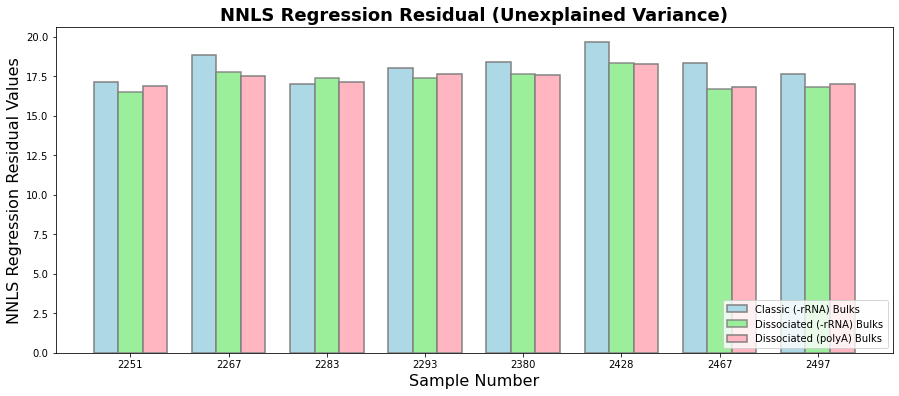

In [37]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = calc_res_tot_bulks.values[0]
dissociated_bulks_values = calc_res_tot_dissbulks.values[0]
dissociatedpolya_bulks_values = calc_res_tot_disspolyabulks.values[0]

# Create x-coordinates for the bars
x_coordinates = np.arange(len(classic_bulks_values))
# Width of each bar
bar_width = 0.25

plt.figure(figsize=(15, 6))

# Plot "Classic Bulks" residuals
plt.bar(x_coordinates, classic_bulks_values, width=bar_width, alpha=1, label='Classic (-rRNA) Bulks',
                        color='lightblue', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width, dissociated_bulks_values, width=bar_width, alpha=0.9, label='Dissociated (-rRNA) Bulks', 
                        color='lightgreen', edgecolor='grey', linewidth=1.5)

# Plot "Dissociated Bulks" residuals next to the "Classic Bulks" bars
plt.bar(x_coordinates + bar_width + bar_width, dissociatedpolya_bulks_values, width=bar_width, alpha=1, 
                label='Dissociated (polyA) Bulks', color="lightpink", edgecolor='grey', linewidth=1.5)

plt.xlabel('Sample Number', fontsize=16)
plt.ylabel('NNLS Regression Residual Values', fontsize = '16')

# Make the title bold
plt.title('NNLS Regression Residual (Unexplained Variance)', fontweight='bold', fontsize = '18')

plt.xticks(x_coordinates + bar_width, ['2251', '2267', '2283', '2293', '2380', '2428', '2467', '2497'])  # Adjust x-axis labels

# Move the legend to the upper right corner
plt.legend(loc='lower right')

plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


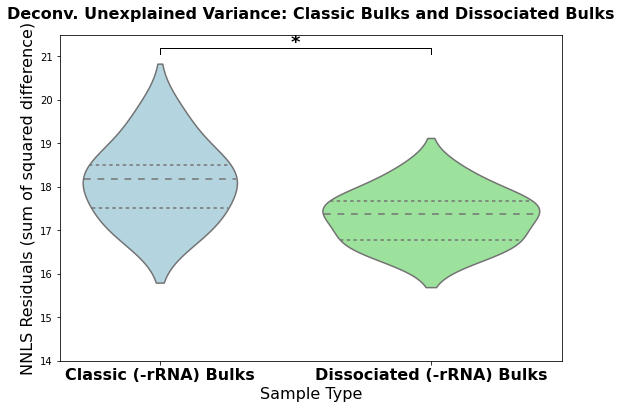

In [38]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_bulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1.4, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.1, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    x1, x2 = 0, 1
    y1, y2 = max_val + 1.4, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-.25, "N.S.", ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial', x=0.5, y=1.03)

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Classic Bulks and Dissociated Bulks', fontsize=16, 
                fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14, 21.5)
plt.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


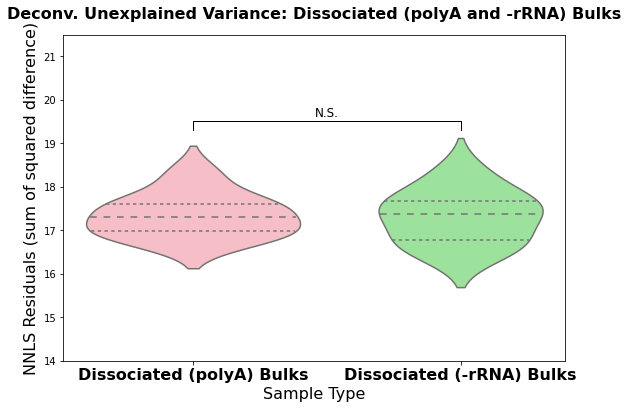

In [39]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = calc_res_tot_disspolyabulks.values[0]
bulk_type_2 = calc_res_tot_dissbulks.values[0]

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['BulkType1'] * len(bulk_type_1) +
                                  ['BulkType2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', 
                palette=['lightpink', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, 
                fontname='Arial',fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1),max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1, max_val +1.55
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', 
                    fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    significance_label = f"Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 1, max_val +1.2
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2+0.03, s='N.S.', ha='center', va='bottom', fontsize=12, 
                    fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('NNLS Residuals (sum of squared difference)', fontsize=16, fontname='Arial')
plt.title('Deconv. Unexplained Variance: Dissociated (polyA and -rRNA) Bulks', 
                fontsize=16, fontname='Arial', fontweight='bold', x=0.5, y=1.03)
plt.ylim(14, 21.5)
plt.show()

## Residuals Prep

Putting bulks together for multiplication:

Recreate Matrices:

In [40]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
bulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_bulks.T)
bulks_recreated_mat_all = bulks_recreated_mat_all.T
bulks_recreated_mat_all.columns = gene_ids
bulks_recreated_mat_all   

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.370035  0.590624  0.196663  0.317998  0.396335  0.086780  0.097859   
2467  0.375353  0.460852  0.208324  0.241406  0.379934  0.075147  0.110266   
2380  0.225198  0.662998  0.225696  0.442084  0.463775  0.100638  0.106176   
2293  0.376114  0.637676  0.266069  0.172915  0.437305  0.101279  0.109029   
2283  0.351721  0.512182  0.206150  0.302751  0.402321  0.079698  0.107373   
2428  0.326124  0.415070  0.217174  0.302325  0.377933  0.062584  0.117475   
2251  0.303986  0.731092  0.245447  0.323604  0.426225  0.082810  0.102112   
2267  0.260925  0.704998  0.251931  0.349342  0.476912  0.121985  0.109721   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.804935  0.358409  0.059368  ...  0.723561  0.246004  0.301323   
2467  0.746879  0.359160  0.049798  ...  0.716295  0.237791  0.345201   
2380  0.896060  0.444000  0.212883  ...  0.680140  0.205722  0.328054   
2293  0.817174  0.311685  0.041893  ...  0.822645  0.239607  0.326936   
2283  0.769112  0.378732  0.080183  ...  0.713534  0.242784  0.355684   
2428  0.766071  0.448682  0.053134  ...  0.616365  0.219418  0.340341   
2251  0.974521  0.437905  0.086884  ...  0.698125  0.186596  0.255591   
2267  0.922079  0.371130  0.192682  ...  0.776742  0.205038  0.308047   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.309892  0.201782  0.203159  0.237706  0.196955  0.337059  0.631282  
2467  0.317591  0.212103  0.191744  0.262293  0.200740  0.392308  0.584840  
2380  0.340940  0.162949  0.216385  0.201121  0.235510  0.363680  0.656423  
2293  0.232293  0.227093  0.261545  0.185800  0.221895  0.316045  0.746894  
2283  0.337643  0.207780  0.194547  0.266316  0.211760  0.389037  0.605241  
2428  0.364285  0.188841  0.194568  0.254588  0.223722  0.441851  0.496910  
2251  0.290775  0.162777  0.240205  0.142362  0.223055  0.348633  0.565282  
2267  0.271270  0.177920  0.241604  0.175010  0.221854  0.317958  0.742659  

[8 rows x 4584 columns]

In [41]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
dissbulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_dissbulks.T)
dissbulks_recreated_mat_all = dissbulks_recreated_mat_all.T
dissbulks_recreated_mat_all.columns = gene_ids
dissbulks_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.371464  0.685468  0.183966  0.336801  0.431010  0.096567  0.084747   
2467  0.311702  0.782075  0.239611  0.319295  0.463283  0.094227  0.092164   
2380  0.309273  0.779831  0.212746  0.369929  0.488396  0.119481  0.089425   
2293  0.349512  0.667918  0.226844  0.218966  0.446481  0.096836  0.091448   
2283  0.375620  0.617464  0.195158  0.302644  0.424977  0.088539  0.093740   
2428  0.371772  0.624822  0.196558  0.213162  0.413971  0.077966  0.087353   
2251  0.272357  0.805750  0.202696  0.302762  0.486799  0.075649  0.072324   
2267  0.380909  0.809265  0.271573  0.156103  0.484790  0.105166  0.095337   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.820380  0.304243  0.126377  ...  0.791576  0.256446  0.303165   
2467  0.931610  0.370170  0.149447  ...  0.779740  0.212782  0.297612   
2380  0.914347  0.307739  0.227209  ...  0.842687  0.232178  0.304305   
2293  0.823928  0.275697  0.179519  ...  0.835972  0.224379  0.314107   
2283  0.801810  0.321912  0.113795  ...  0.785867  0.252383  0.335260   
2428  0.787617  0.276141  0.130327  ...  0.792949  0.226236  0.309409   
2251  0.894333  0.306530  0.306147  ...  0.804752  0.191533  0.315853   
2267  0.880459  0.274950  0.118679  ...  0.896578  0.233386  0.265606   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.280153  0.208265  0.211844  0.242225  0.179499  0.285917  0.694307  
2467  0.269682  0.188326  0.247257  0.174471  0.216671  0.310008  0.672721  
2380  0.254810  0.192465  0.238405  0.207784  0.188901  0.267541  0.751812  
2293  0.221454  0.213918  0.238047  0.211720  0.180859  0.290707  0.713494  
2283  0.297593  0.214367  0.208099  0.260017  0.189625  0.330235  0.652405  
2428  0.239543  0.209031  0.205920  0.221615  0.165576  0.306508  0.647074  
2251  0.230884  0.179931  0.226806  0.182217  0.173961  0.284899  0.646800  
2267  0.147672  0.218805  0.324428  0.109880  0.203239  0.230658  0.796065  

[8 rows x 4584 columns]

In [42]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
disspolyabulks_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_disspolyabulks.T)
disspolyabulks_recreated_mat_all = disspolyabulks_recreated_mat_all.T
disspolyabulks_recreated_mat_all.columns = gene_ids
disspolyabulks_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.379753  0.690016  0.176970  0.332625  0.432649  0.101677  0.080389   
2467  0.337745  0.831207  0.232195  0.305600  0.483168  0.115349  0.082053   
2380  0.317790  0.783403  0.209490  0.333101  0.487647  0.126924  0.085209   
2293  0.369809  0.656004  0.220158  0.202002  0.447423  0.107115  0.090240   
2283  0.391379  0.634375  0.189597  0.296897  0.432261  0.097430  0.088422   
2428  0.387519  0.618564  0.186484  0.171147  0.409141  0.084102  0.080570   
2251  0.271402  0.817068  0.189353  0.303935  0.496518  0.080246  0.064441   
2267  0.404237  0.843477  0.265298  0.139934  0.476397  0.117101  0.086194   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.786462  0.273076  0.128775  ...  0.807100  0.269334  0.305234   
2467  0.876755  0.282666  0.162801  ...  0.854653  0.246591  0.303002   
2380  0.877616  0.254969  0.231274  ...  0.869324  0.237661  0.294977   
2293  0.789954  0.230553  0.175781  ...  0.871151  0.239865  0.317040   
2283  0.765155  0.279804  0.115346  ...  0.818766  0.272211  0.341607   
2428  0.725677  0.209818  0.131924  ...  0.820587  0.238356  0.303451   
2251  0.849513  0.262593  0.340223  ...  0.827732  0.204552  0.325397   
2267  0.860841  0.219836  0.113067  ...  0.927477  0.244827  0.252656   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.268316  0.217351  0.210372  0.250307  0.173137  0.262437  0.745128  
2467  0.229033  0.214574  0.256410  0.190419  0.202792  0.240350  0.823222  
2380  0.218510  0.200712  0.238248  0.201432  0.174111  0.231293  0.818447  
2293  0.203595  0.226271  0.235978  0.225613  0.169080  0.266119  0.770473  
2283  0.282030  0.229341  0.210735  0.272929  0.183789  0.298489  0.725494  
2428  0.201277  0.222215  0.201378  0.223456  0.146410  0.264154  0.725241  
2251  0.214419  0.189383  0.222563  0.195422  0.162180  0.254328  0.708108  
2267  0.126863  0.230117  0.312467  0.122362  0.189031  0.191074  0.878631  

[8 rows x 4584 columns]

In [43]:
calc_prop_tot_combo

Fat cell  Plasma cells  Monocytes   T cells  Endothelial cells  \
2497  0.234732      0.093747   0.000000  0.000000           0.010588   
2467  0.282812      0.086438   0.000000  0.000000           0.000000   
2380  0.331956      0.000000   0.098713  0.000000           0.244849   
2293  0.192189      0.012907   0.000000  0.027042           0.000000   
2283  0.302276      0.044255   0.000000  0.000000           0.056722   
2428  0.381439      0.067955   0.000000  0.000000           0.000000   
2251  0.242891      0.227990   0.000000  0.000000           0.015470   
2267  0.234787      0.015564   0.139632  0.000000           0.217499   
2497  0.153515      0.118364   0.013429  0.000000           0.108636   
2467  0.192474      0.145715   0.000000  0.000000           0.127875   
2380  0.132260      0.108569   0.103544  0.000000           0.252123   
2293  0.126055      0.141982   0.044830  0.000000           0.154680   
2283  0.198400      0.112210   0.000000  0.000000           0.093090   
2428  0.130455      0.226844   0.000000  0.000000           0.099679   
2251  0.110402      0.304800   0.017788  0.000000           0.330047   
2267  0.049441      0.147351   0.000000  0.075491           0.028815   

      NK cells  Epithelial cells       ILC  Fibroblasts   B cells   DC  \
2497  0.000000          0.318064  0.004902     0.240550  0.000000  0.0   
2467  0.000000          0.540527  0.009099     0.000000  0.000000  0.0   
2380  0.000000          0.000000  0.000000     0.256031  0.000000  0.0   
2293  0.000000          0.347733  0.000000     0.000000  0.000000  0.0   
2283  0.000000          0.462433  0.000000     0.081894  0.000000  0.0   
2428  0.000000          0.469358  0.006075     0.000000  0.027949  0.0   
2251  0.000000          0.016404  0.000000     0.232847  0.004510  0.0   
2267  0.000000          0.000000  0.000000     0.203090  0.000000  0.0   
2497  0.000000          0.226013  0.000000     0.332187  0.000000  0.0   
2467  0.000000          0.057097  0.000000     0.232302  0.000000  0.0   
2380  0.000000          0.000000  0.000000     0.352009  0.000000  0.0   
2293  0.000000          0.238778  0.034016     0.076400  0.000000  0.0   
2283  0.000000          0.366043  0.000000     0.196514  0.000000  0.0   
2428  0.000000          0.343076  0.000000     0.078791  0.000000  0.0   
2251  0.000000          0.000000  0.000000     0.159320  0.000000  0.0   
2267  0.028705          0.018704  0.000000     0.144938  0.000000  0.0   

      Macrophages  pDC  Mast cells  Erythroid  
2497     0.054464  0.0    0.000000   0.042953  
2467     0.080036  0.0    0.001088   0.000000  
2380     0.042902  0.0    0.000000   0.025550  
2293     0.415003  0.0    0.005125   0.000000  
2283     0.052420  0.0    0.000000   0.000000  
2428     0.047224  0.0    0.000000   0.000000  
2251     0.249333  0.0    0.000000   0.010554  
2267     0.181141  0.0    0.000000   0.008287  
2497     0.006987  0.0    0.000000   0.040870  
2467     0.243354  0.0    0.000000   0.001184  
2380     0.046561  0.0    0.000000   0.004934  
2293     0.183258  0.0    0.000000   0.000000  
2283     0.033744  0.0    0.000000   0.000000  
2428     0.098506  0.0    0.000000   0.022649  
2251     0.077643  0.0    0.000000   0.000000  
2267     0.490901  0.0    0.000000   0.015654

In [44]:
#recreate matrix with calculated proportion nnls and multiplying by the used reference
combo_recreated_mat_all = pd.DataFrame(all_refs @ calc_prop_tot_combo.T)
combo_recreated_mat_all = combo_recreated_mat_all.T
combo_recreated_mat_all.columns = gene_ids
combo_recreated_mat_all 

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497  0.370035  0.590624  0.196663  0.317998  0.396335  0.086780  0.097859   
2467  0.375353  0.460852  0.208324  0.241406  0.379934  0.075147  0.110266   
2380  0.225198  0.662998  0.225696  0.442084  0.463775  0.100638  0.106176   
2293  0.376114  0.637676  0.266069  0.172915  0.437305  0.101279  0.109029   
2283  0.351721  0.512182  0.206150  0.302751  0.402321  0.079698  0.107373   
2428  0.326124  0.415070  0.217174  0.302325  0.377933  0.062584  0.117475   
2251  0.303986  0.731092  0.245447  0.323604  0.426225  0.082810  0.102112   
2267  0.260925  0.704998  0.251931  0.349342  0.476912  0.121985  0.109721   
2497  0.371464  0.685468  0.183966  0.336801  0.431010  0.096567  0.084747   
2467  0.311702  0.782075  0.239611  0.319295  0.463283  0.094227  0.092164   
2380  0.309273  0.779831  0.212746  0.369929  0.488396  0.119481  0.089425   
2293  0.349512  0.667918  0.226844  0.218966  0.446481  0.096836  0.091448   
2283  0.375620  0.617464  0.195158  0.302644  0.424977  0.088539  0.093740   
2428  0.371772  0.624822  0.196558  0.213162  0.413971  0.077966  0.087353   
2251  0.272357  0.805750  0.202696  0.302762  0.486799  0.075649  0.072324   
2267  0.380909  0.809265  0.271573  0.156103  0.484790  0.105166  0.095337   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.804935  0.358409  0.059368  ...  0.723561  0.246004  0.301323   
2467  0.746879  0.359160  0.049798  ...  0.716295  0.237791  0.345201   
2380  0.896060  0.444000  0.212883  ...  0.680140  0.205722  0.328054   
2293  0.817174  0.311685  0.041893  ...  0.822645  0.239607  0.326936   
2283  0.769112  0.378732  0.080183  ...  0.713534  0.242784  0.355684   
2428  0.766071  0.448682  0.053134  ...  0.616365  0.219418  0.340341   
2251  0.974521  0.437905  0.086884  ...  0.698125  0.186596  0.255591   
2267  0.922079  0.371130  0.192682  ...  0.776742  0.205038  0.308047   
2497  0.820380  0.304243  0.126377  ...  0.791576  0.256446  0.303165   
2467  0.931610  0.370170  0.149447  ...  0.779740  0.212782  0.297612   
2380  0.914347  0.307739  0.227209  ...  0.842687  0.232178  0.304305   
2293  0.823928  0.275697  0.179519  ...  0.835972  0.224379  0.314107   
2283  0.801810  0.321912  0.113795  ...  0.785867  0.252383  0.335260   
2428  0.787617  0.276141  0.130327  ...  0.792949  0.226236  0.309409   
2251  0.894333  0.306530  0.306147  ...  0.804752  0.191533  0.315853   
2267  0.880459  0.274950  0.118679  ...  0.896578  0.233386  0.265606   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497  0.309892  0.201782  0.203159  0.237706  0.196955  0.337059  0.631282  
2467  0.317591  0.212103  0.191744  0.262293  0.200740  0.392308  0.584840  
2380  0.340940  0.162949  0.216385  0.201121  0.235510  0.363680  0.656423  
2293  0.232293  0.227093  0.261545  0.185800  0.221895  0.316045  0.746894  
2283  0.337643  0.207780  0.194547  0.266316  0.211760  0.389037  0.605241  
2428  0.364285  0.188841  0.194568  0.254588  0.223722  0.441851  0.496910  
2251  0.290775  0.162777  0.240205  0.142362  0.223055  0.348633  0.565282  
2267  0.271270  0.177920  0.241604  0.175010  0.221854  0.317958  0.742659  
2497  0.280153  0.208265  0.211844  0.242225  0.179499  0.285917  0.694307  
2467  0.269682  0.188326  0.247257  0.174471  0.216671  0.310008  0.672721  
2380  0.254810  0.192465  0.238405  0.207784  0.188901  0.267541  0.751812  
2293  0.221454  0.213918  0.238047  0.211720  0.180859  0.290707  0.713494  
2283  0.297593  0.214367  0.208099  0.260017  0.189625  0.330235  0.652405  
2428  0.239543  0.209031  0.205920  0.221615  0.165576  0.306508  0.647074  
2251  0.230884  0.179931  0.226806  0.182217  0.173961  0.284899  0.646800  
2267  0.147672  0.218805  0.324428  0.109880  0.203239  0.230658  0.796065  

[16 rows x 4584 columns]

## **Calculate Residuals:**

1. Residual uses:

pseudobulks - recreated_mat_all (reference used normalized (all_refs) * calculated proportions (calc_prop_tot))

In [45]:
#Classic Bulks: Residual as the the difference between the recreated matrix and pseudobulks.
res = bulks.values - bulks_recreated_mat_all.values
residuals_bulks = pd.DataFrame(res, columns = bulks_recreated_mat_all.columns, index = sample_ids)
residuals_bulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.339159  0.409376  0.013067  0.017752 -0.155500 -0.009933  0.114844   
2467 -0.341197  0.539148  0.016083  0.028329 -0.053698  0.215976  0.032103   
2380 -0.218801  0.337002 -0.013489  0.305937 -0.171714 -0.039093  0.000810   
2293 -0.358740  0.362324  0.070852 -0.094561 -0.111966 -0.050860  0.143066   
2283 -0.276866  0.487818  0.113484 -0.068452 -0.156793  0.000647  0.010151   
2428 -0.289187  0.584930 -0.012670 -0.215839 -0.002257  0.115794 -0.045403   
2251 -0.282735  0.268908 -0.054719  0.072545 -0.186437 -0.003580  0.025390   
2267 -0.252944  0.295002  0.002584 -0.052259 -0.185742 -0.028870 -0.005964   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.195065 -0.126723 -0.014540  ... -0.444075 -0.174645 -0.222188   
2467  0.253121 -0.020155 -0.039583  ... -0.384313 -0.146496 -0.141543   
2380  0.103940 -0.029953 -0.104132  ... -0.529698 -0.145942 -0.260332   
2293  0.182826 -0.081393 -0.010210  ... -0.530011 -0.129230 -0.225416   
2283  0.230888 -0.106506  0.018876  ... -0.357969 -0.151959 -0.139600   
2428  0.233929  0.551318 -0.034666  ... -0.447896 -0.119418 -0.239891   
2251  0.025479 -0.036771 -0.002670  ... -0.486408 -0.107104 -0.169016   
2267  0.077921 -0.089419 -0.080056  ... -0.597310 -0.152716 -0.184485   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.141560  0.098746 -0.154215  0.256085  0.293634  0.071422  0.368718  
2467 -0.093503  0.109665 -0.119921  0.018934  0.312236  0.384977  0.106577  
2380 -0.153438  0.312202 -0.176900 -0.072738  0.286626 -0.155443  0.105053  
2293 -0.172335  0.057366 -0.149125 -0.056005  0.294900  0.223234  0.002237  
2283 -0.056683  0.222142 -0.104720  0.491226  0.788240  0.126720 -0.269886  
2428  0.042022  0.117916 -0.163487  0.182349  0.438891  0.377969 -0.243306  
2251 -0.195280  0.078847 -0.122672  0.124448  0.523069  0.123860  0.312017  
2267 -0.126128  0.287066 -0.152923 -0.023365  0.327379 -0.058417  0.257341  

[8 rows x 4584 columns]

In [46]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
res = diss_bulks.values - dissbulks_recreated_mat_all.values
residuals_dissbulks = pd.DataFrame(res, columns = dissbulks_recreated_mat_all.columns, index = sample_ids)
residuals_dissbulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.328714  0.314532 -0.002116  0.124768 -0.197947  0.042533  0.034605   
2467 -0.282583  0.217925 -0.082513  0.074709 -0.214873  0.054962 -0.032848   
2380 -0.286841  0.220169 -0.016598  0.065317 -0.169963  0.249015 -0.028693   
2293 -0.336196  0.332082  0.068604  0.194106 -0.131892  0.009691  0.000932   
2283 -0.330765  0.382536  0.022329  0.013701 -0.172668  0.047206 -0.023506   
2428 -0.303498  0.375178 -0.003848 -0.033667 -0.083978  0.588627 -0.051380   
2251 -0.254443  0.194250 -0.029717  0.155994 -0.200741  0.111884 -0.013265   
2267 -0.358405  0.190735 -0.081489  0.004534 -0.184821 -0.044358 -0.018250   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.179620 -0.134111 -0.014186  ... -0.460210 -0.194165 -0.224826   
2467  0.068390 -0.065320 -0.045913  ... -0.514435 -0.134412 -0.154534   
2380  0.085653 -0.056330 -0.081945  ... -0.614532 -0.176644 -0.213480   
2293  0.176072 -0.127834 -0.096017  ... -0.568543 -0.151974 -0.207580   
2283  0.198190 -0.158723  0.006310  ... -0.468046 -0.181854 -0.183875   
2428  0.212383  0.221234 -0.048104  ... -0.582987 -0.184757 -0.245172   
2251  0.105667 -0.044823 -0.009733  ... -0.592587 -0.150947 -0.219007   
2267  0.119541 -0.133224 -0.024594  ... -0.670824 -0.173296 -0.182055   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.156244  0.210553 -0.166273  0.270774  0.305940  0.072791  0.305693  
2467 -0.157521  0.053253 -0.154508  0.041584  0.490450  0.112755  0.327279  
2380 -0.059483  0.391328 -0.187795 -0.050756  0.415410  0.068947  0.248188  
2293 -0.008677  0.492382 -0.112378  0.006606  0.226664  0.088797  0.286506  
2283 -0.014594  0.617811 -0.130488  0.212435  0.724000  0.253175  0.059078  
2428 -0.065920  0.494636 -0.178757  0.122327  0.334369  0.439371 -0.045818  
2251 -0.090654  0.419616 -0.152352  0.085927  0.267162  0.159023  0.226209  
2267 -0.129717  0.274839 -0.199221 -0.022020  0.267183  0.045850  0.203935  

[8 rows x 4584 columns]

In [47]:
#Dissociated dissbulks: Residual as the the difference between the recreated matrix and pseudodissbulks.
residuals_disspolyabulks = pd.DataFrame()
res = disspolya_bulks.values - disspolyabulks_recreated_mat_all.values
residuals_disspolyabulks = pd.DataFrame(res, columns = disspolyabulks_recreated_mat_all.columns, index = sample_ids)
residuals_disspolyabulks

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.356856  0.309984 -0.007702  0.161349 -0.222954 -0.041678  0.036663   
2467 -0.309166  0.168793 -0.062693  0.133921 -0.238770 -0.014831 -0.031794   
2380 -0.307258  0.216597 -0.005581  0.160491 -0.192126 -0.054471 -0.037246   
2293 -0.362951  0.343996  0.072360  0.264561 -0.197707 -0.060766  0.007187   
2283 -0.374865  0.365625  0.020905  0.051571 -0.183923 -0.044125 -0.015049   
2428 -0.359236  0.381436  0.009428 -0.020764 -0.140567  0.070649 -0.054126   
2251 -0.262117  0.182932 -0.045010  0.172818 -0.250038 -0.011704 -0.019366   
2267 -0.392180  0.156523 -0.069935  0.027645 -0.228612 -0.080755 -0.010181   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497 -0.065414 -0.101239 -0.043008  ... -0.507255 -0.211375 -0.231255   
2467  0.123245 -0.041028 -0.085146  ... -0.508949 -0.156913 -0.162868   
2380  0.122384 -0.000179 -0.123674  ... -0.632425 -0.179927 -0.213515   
2293  0.210046 -0.113498 -0.111224  ... -0.580288 -0.182402 -0.183196   
2283  0.117198 -0.114245 -0.005600  ... -0.482632 -0.202393 -0.164342   
2428  0.274323  0.106354 -0.057422  ... -0.577537 -0.178571 -0.257463   
2251  0.150487 -0.020840 -0.106235  ... -0.619912 -0.161333 -0.222922   
2267  0.139159 -0.064490 -0.044917  ... -0.685982 -0.179473 -0.167556   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.188291  0.172871 -0.147502  0.229233  0.398065  0.045569  0.254872  
2467 -0.162021  0.025488 -0.074097  0.060680  0.773616  0.132751  0.176778  
2380 -0.110022  0.417230 -0.131282 -0.082539  0.443831  0.023370  0.181553  
2293 -0.027659  0.427815 -0.047036 -0.003092  0.270761  0.030183  0.229527  
2283 -0.039127  0.498741 -0.090747  0.158318  0.816211  0.176657  0.274506  
2428 -0.094813  0.491528 -0.168036  0.063513  0.326813  0.430965  0.261215  
2251 -0.113295  0.382754 -0.120595  0.040591  0.273380  0.105769  0.291892  
2267 -0.116204  0.231553 -0.112037 -0.037437  0.329780  0.028054  0.121369  

[8 rows x 4584 columns]

In [48]:
#Dissociated combo: Residual as the the difference between the recreated matrix and pseudocombo.
residuals_combo = pd.DataFrame()
res = combo.values - combo_recreated_mat_all.values
residuals_combo = pd.DataFrame(res, columns = combo_recreated_mat_all.columns)
residuals_combo.index = np.concatenate([residuals_bulks.index.values, residuals_dissbulks.index.values])
residuals_combo

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
2497 -0.339159  0.409376  0.013067  0.017752 -0.155500 -0.009933  0.114844   
2467 -0.341197  0.539148  0.016083  0.028329 -0.053698  0.215976  0.032103   
2380 -0.218801  0.337002 -0.013489  0.305937 -0.171714 -0.039093  0.000810   
2293 -0.358740  0.362324  0.070852 -0.094561 -0.111966 -0.050860  0.143066   
2283 -0.276866  0.487818  0.113484 -0.068452 -0.156793  0.000647  0.010151   
2428 -0.289187  0.584930 -0.012670 -0.215839 -0.002257  0.115794 -0.045403   
2251 -0.282735  0.268908 -0.054719  0.072545 -0.186437 -0.003580  0.025390   
2267 -0.252944  0.295002  0.002584 -0.052259 -0.185742 -0.028870 -0.005964   
2497 -0.328714  0.314532 -0.002116  0.124768 -0.197947  0.042533  0.034605   
2467 -0.282583  0.217925 -0.082513  0.074709 -0.214873  0.054962 -0.032848   
2380 -0.286841  0.220169 -0.016598  0.065317 -0.169963  0.249015 -0.028693   
2293 -0.336196  0.332082  0.068604  0.194106 -0.131892  0.009691  0.000932   
2283 -0.330765  0.382536  0.022329  0.013701 -0.172668  0.047206 -0.023506   
2428 -0.303498  0.375178 -0.003848 -0.033667 -0.083978  0.588627 -0.051380   
2251 -0.254443  0.194250 -0.029717  0.155994 -0.200741  0.111884 -0.013265   
2267 -0.358405  0.190735 -0.081489  0.004534 -0.184821 -0.044358 -0.018250   

         ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1  \
2497  0.195065 -0.126723 -0.014540  ... -0.444075 -0.174645 -0.222188   
2467  0.253121 -0.020155 -0.039583  ... -0.384313 -0.146496 -0.141543   
2380  0.103940 -0.029953 -0.104132  ... -0.529698 -0.145942 -0.260332   
2293  0.182826 -0.081393 -0.010210  ... -0.530011 -0.129230 -0.225416   
2283  0.230888 -0.106506  0.018876  ... -0.357969 -0.151959 -0.139600   
2428  0.233929  0.551318 -0.034666  ... -0.447896 -0.119418 -0.239891   
2251  0.025479 -0.036771 -0.002670  ... -0.486408 -0.107104 -0.169016   
2267  0.077921 -0.089419 -0.080056  ... -0.597310 -0.152716 -0.184485   
2497  0.179620 -0.134111 -0.014186  ... -0.460210 -0.194165 -0.224826   
2467  0.068390 -0.065320 -0.045913  ... -0.514435 -0.134412 -0.154534   
2380  0.085653 -0.056330 -0.081945  ... -0.614532 -0.176644 -0.213480   
2293  0.176072 -0.127834 -0.096017  ... -0.568543 -0.151974 -0.207580   
2283  0.198190 -0.158723  0.006310  ... -0.468046 -0.181854 -0.183875   
2428  0.212383  0.221234 -0.048104  ... -0.582987 -0.184757 -0.245172   
2251  0.105667 -0.044823 -0.009733  ... -0.592587 -0.150947 -0.219007   
2267  0.119541 -0.133224 -0.024594  ... -0.670824 -0.173296 -0.182055   

         ZNRF3      ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
2497 -0.141560  0.098746 -0.154215  0.256085  0.293634  0.071422  0.368718  
2467 -0.093503  0.109665 -0.119921  0.018934  0.312236  0.384977  0.106577  
2380 -0.153438  0.312202 -0.176900 -0.072738  0.286626 -0.155443  0.105053  
2293 -0.172335  0.057366 -0.149125 -0.056005  0.294900  0.223234  0.002237  
2283 -0.056683  0.222142 -0.104720  0.491226  0.788240  0.126720 -0.269886  
2428  0.042022  0.117916 -0.163487  0.182349  0.438891  0.377969 -0.243306  
2251 -0.195280  0.078847 -0.122672  0.124448  0.523069  0.123860  0.312017  
2267 -0.126128  0.287066 -0.152923 -0.023365  0.327379 -0.058417  0.257341  
2497 -0.156244  0.210553 -0.166273  0.270774  0.305940  0.072791  0.305693  
2467 -0.157521  0.053253 -0.154508  0.041584  0.490450  0.112755  0.327279  
2380 -0.059483  0.391328 -0.187795 -0.050756  0.415410  0.068947  0.248188  
2293 -0.008677  0.492382 -0.112378  0.006606  0.226664  0.088797  0.286506  
2283 -0.014594  0.617811 -0.130488  0.212435  0.724000  0.253175  0.059078  
2428 -0.065920  0.494636 -0.178757  0.122327  0.334369  0.439371 -0.045818  
2251 -0.090654  0.419616 -0.152352  0.085927  0.267162  0.159023  0.226209  
2267 -0.129717  0.274839 -0.199221 -0.022020  0.267183  0.045850  0.203935  

[16 rows x 4584 columns]

## Comparing Residuals

In [49]:
adip_markers = np.intersect1d(adip_markers, residuals_bulks.columns)
diss_response= np.intersect1d(diss_response, residuals_bulks.columns)
cibersort_genes= np.intersect1d(cibersort_genes, residuals_bulks.columns)

Residual Correlation: Classic vs. Dissociated

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


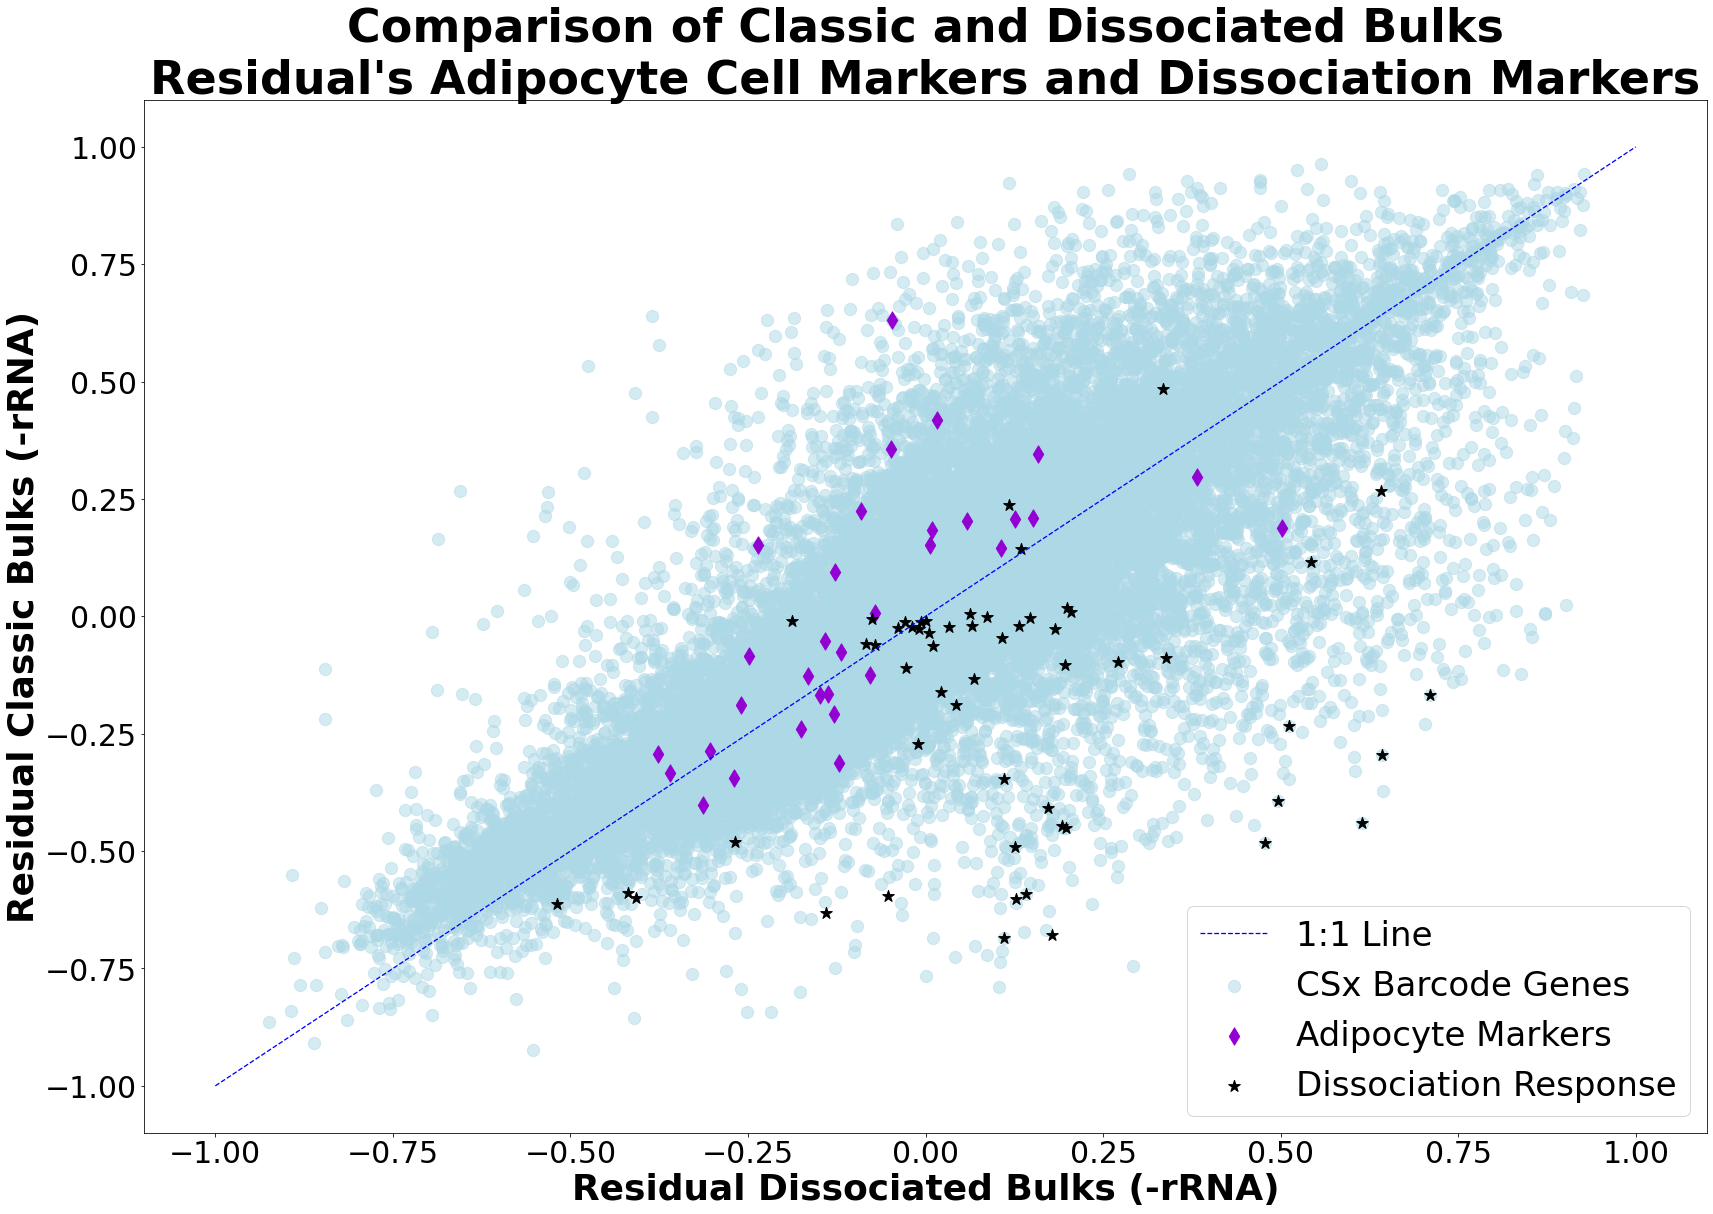

In [50]:
# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(28,19))
# Plot CIBERSORT genes
genes_of_interest = cibersort_genes
for gene in genes_of_interest:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=0.5, c='lightblue', s=150,
                    label='CSx Barcode Genes' if gene == genes_of_interest[0] else "")

# Plot Adipocyte markers
for gene in adip_markers:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='darkviolet', marker='d', s=150,
                    label='Adipocyte Markers' if gene == adip_markers[0] else "")

# Plot Dissociation Response genes
for gene in diss_response:
    gene_data_bulks = residuals_bulks[gene]
    gene_data_dissbulks = residuals_dissbulks[gene]
    plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c='black', marker='*', s=150,
                    label='Dissociation Response' if gene == diss_response[0] else "")


# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1.3, linestyle='--')

# Set axis labels and title
plt.title("Comparison of Classic and Dissociated Bulks\nResidual's Adipocyte Cell Markers and Dissociation Markers", 
                fontsize=46, fontname='Arial', fontweight='bold', x=0.5, y=1.0003)
plt.ylabel('Residual Classic Bulks (-rRNA)', fontsize=36, fontname='Arial', fontweight='bold')
plt.xlabel('Residual Dissociated Bulks (-rRNA)', fontsize=36, fontname='Arial', fontweight='bold')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Add legend
plt.legend(fontsize=34, markerscale=1)

# Show the plot
plt.show()

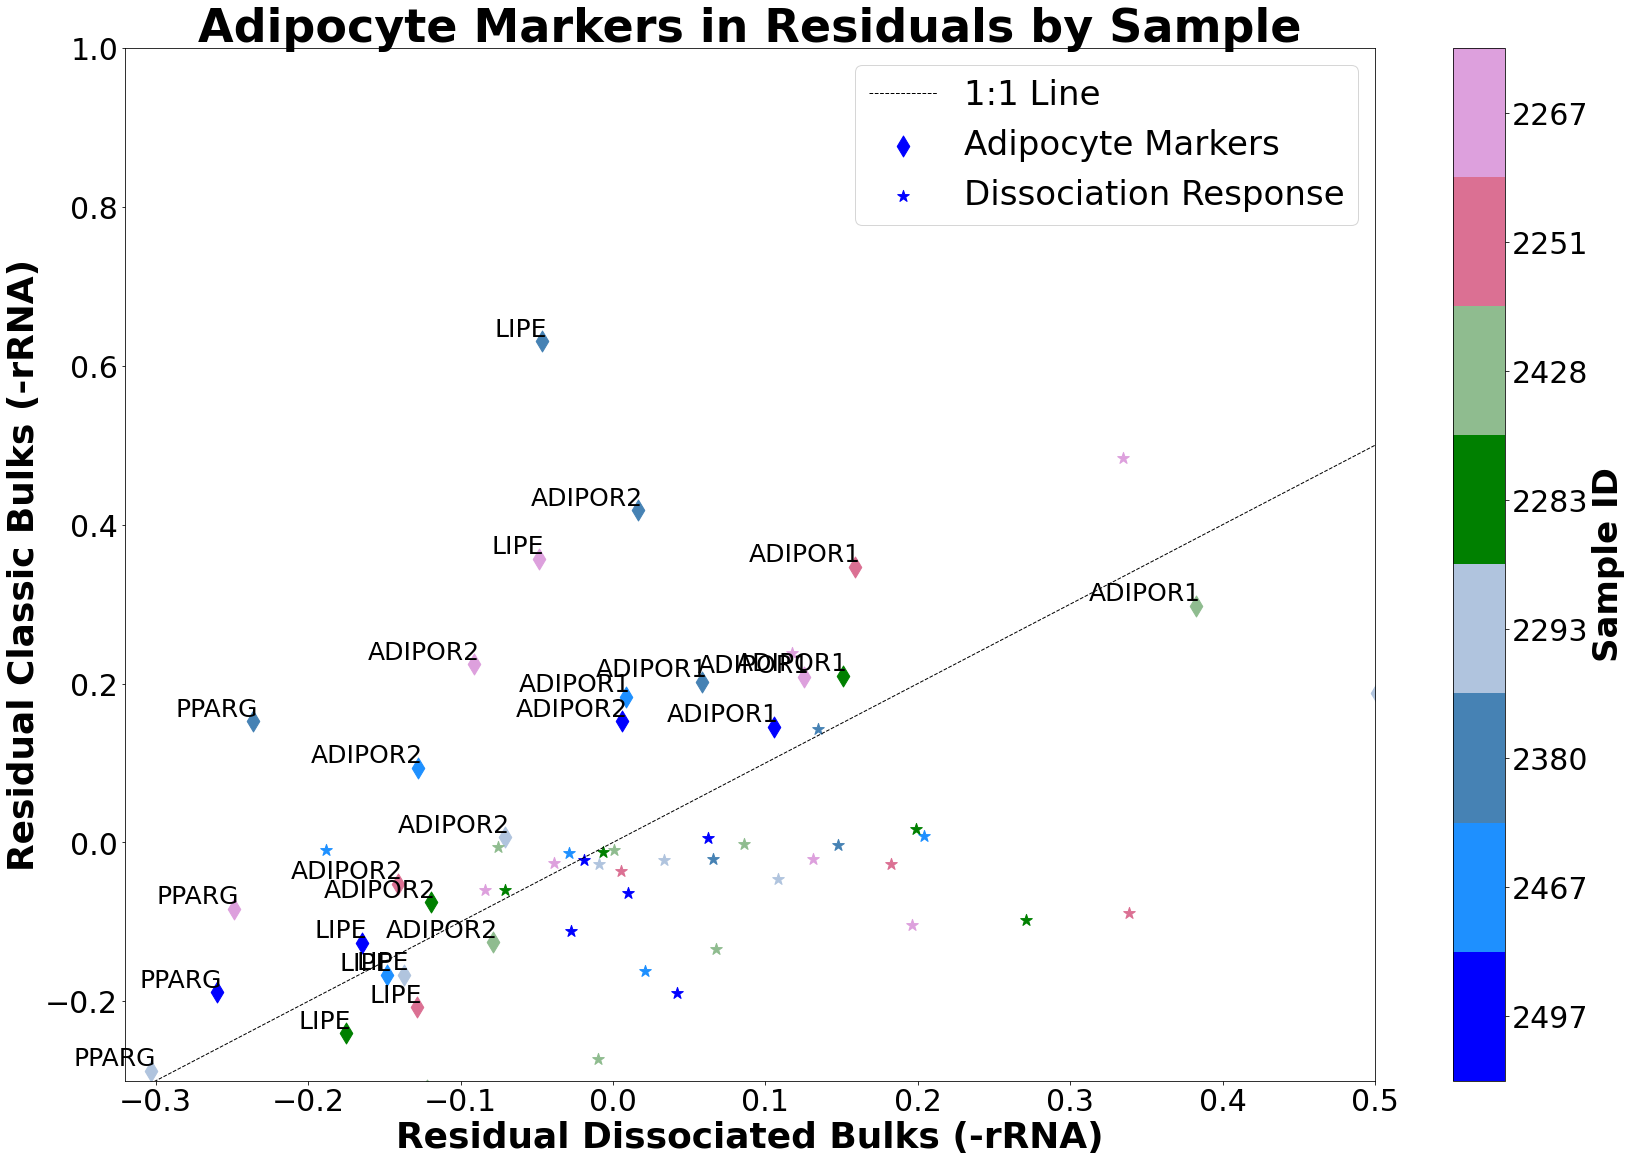

In [51]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_bulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 110

# Create a sc_atter plot with labels for multiple genes
plt.figure(figsize=(28,19))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=220,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=25)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "",s=150)

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='black', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals by Sample',  fontsize=46, fontname='Arial', fontweight='bold', x=0.5, y=1.0003)
plt.ylabel('Residual Values of Classic Bulks (-rRNA)', fontsize=26, fontname='Arial')
plt.xlabel('Residual Values of Dissociated Bulks (-rRNA)', fontsize=26, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)
ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(24)
    text.set_fontname('Arial')

#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)),label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold', fontsize=34)
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Set colorbar tick font size
colorbar.ax.tick_params(labelsize=30)

plt.ylabel('Residual Classic Bulks (-rRNA)', fontsize=36, fontname='Arial', fontweight='bold')
plt.xlabel('Residual Dissociated Bulks (-rRNA)', fontsize=36, fontname='Arial', fontweight='bold')
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Add legend
plt.legend(fontsize=34, markerscale=1)

# Show the plot
plt.show()


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


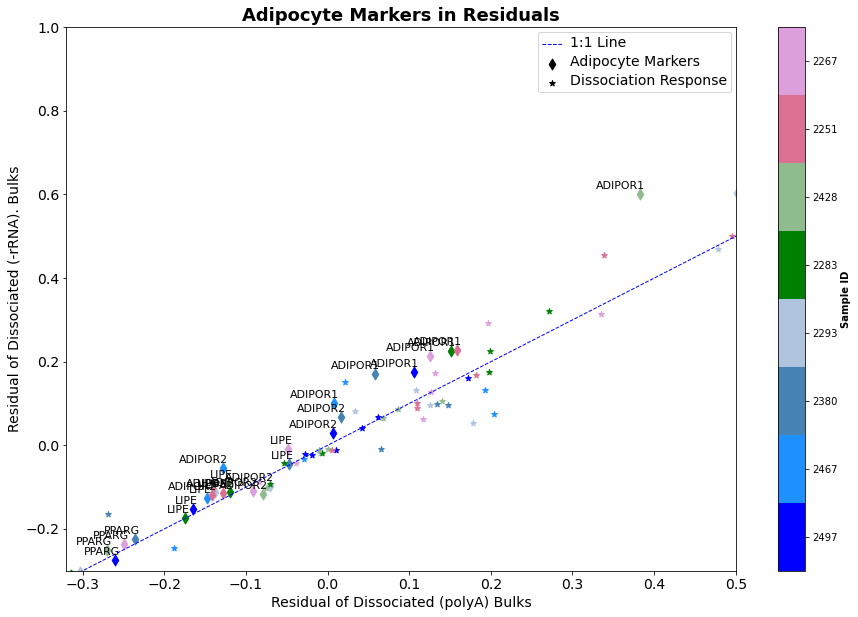

In [52]:
#making copy for numerated index:
res_dissbulks_copy = residuals_dissbulks.copy()
res_bulks_copy = residuals_disspolyabulks.copy()

res_dissbulks_copy.index = range(0,8)
res_bulks_copy.index = range(0,8)

row_indices = sample_ids *2
# Define custom colors
custom_colors = ['blue', 'dodgerblue','steelblue','lightsteelblue','green','darkseagreen', 'palevioletred', 'plum']

# Create a custom colormap
cmap_custom = mcolors.ListedColormap(custom_colors)
marker_size = 100

# Create a scatter plot with labels for multiple genes
plt.figure(figsize=(15, 10))

# Get unique colors for each sample using the previously defined custom colormap
unique_colors = mcolors.ListedColormap(custom_colors)(np.arange(len(res_bulks_copy)))
# Plot each gene for both bulks and dissbulks
for sample_idx, sample_color in enumerate(unique_colors):

    # Plot Adipocyte markers
    for gene in adip_markers:

        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        marker_size = 60  # Increase size for the first Adipocyte marker
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='d', s=marker_size,
                    label='Adipocyte Markers' if gene == adip_markers[0] and sample_idx == 0 else "")
        plt.annotate(str(gene), (gene_data_dissbulks, gene_data_bulks), textcoords="offset points", xytext=(5, 5),
                     ha='right', fontsize=11)

    # Plot Dissociation Response genes
    for gene in diss_response:
        gene_data_bulks = res_bulks_copy.at[sample_idx, gene]
        gene_data_dissbulks = res_dissbulks_copy.at[sample_idx, gene]
        plt.scatter(gene_data_dissbulks, gene_data_bulks, alpha=1, c=[sample_color], marker='*',
                    label='Dissociation Response' if gene == diss_response[0] and sample_idx == 0 else "")

# Plot 1:1 Line
plt.plot([-1, 1], [-1, 1], label='1:1 Line', color='blue', linewidth=1, linestyle='--')

# Set axis labels and title
plt.title('Adipocyte Markers in Residuals', fontsize=18, fontname='Arial', fontweight='bold')
plt.ylabel('Residual of Dissociated (-rRNA). Bulks', fontsize=14, fontname='Arial')
plt.xlabel('Residual of Dissociated (polyA) Bulks', fontsize=14, fontname='Arial')

# Add legend
legend = plt.legend()
plt.xlim(-0.32, 0.5)
plt.ylim(-0.3, 1)

ax = plt.gca()
leg = ax.get_legend()
leg.legendHandles[1].set_color('black')
leg.legendHandles[2].set_color('black')

# Set font size and font family for legend
for text in legend.get_texts():
    text.set_fontsize(14)
    text.set_fontname('Arial')

# Set font size for tick labels
plt.xticks(fontsize=14, fontname='Arial')
plt.yticks(fontsize=14, fontname='Arial')
#add colorbar 
sc_ = plt.scatter([], [], c=[], cmap=cmap_custom, marker='d', s=marker_size)
colorbar = plt.colorbar(sc_, ticks=np.arange(len(custom_colors)), label='Sample Index', orientation='vertical')
colorbar.set_label("Sample ID", fontweight='bold')
colorbar.set_ticks([0+1/16,1/8+1/16,2/8+1/16,3/8+1/16,4/8+1/16,5/8+1/16,6/8+1/16,7/8+1/16,8/8+1/16])
colorbar.set_ticklabels(sample_ids)
# Show the plot
plt.show()


## Top Genes per Sample's Residual:

Analyzing the main genes in the Residual of the samples with high adipocyte markers:

In [53]:
# Extract the top genes
top_genes_per_sample_bulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_bulks.values[num, :]  

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices]  
    top_genes_per_sample_bulk[num] = gene_names_top_10
top_genes_per_sample_bulk.columns = sample_ids
top_genes_per_sample_bulk                                

2497        2467     2380     2293    2283      2428    2251     2267
0    STAB1  AC136475.3  TNFSF14   NUP210    DTX4      ACPP  ATP8B2    ITPR3
1   NBEAL2        LY75  SLCO2B1     HID1   F13A1  B4GALNT3   ITGB4  SIGLEC1
2  RAPGEF3       CIITA      PPL     LY75     SRC      FGD5  NBEAL2   NBEAL2
3    F13A1     PLEKHA6     MRC1   NBEAL2   STAB1      CRB2   MEGF6    MUC16
4    PLCG1         TNC  FAM110C     PSD4   OBSCN    NUP210    TEP1  COL27A1
5    CD163       OBSCN    MUC16    ITGB4   PLCG1     ANPEP   OBSCN     IL7R
6     MYRF      TBC1D2    F13A1  NADSYN1  NBEAL2     CLCN5   FUCA1   SLC7A2
7     CD93       STAB1    CSF1R    KMT2D    SDC1       TNC   ABCC5   CHI3L1
8      CGN         PVR    KMT2D   CELSR1    MEG8     CMYA5   WDFY4    KMT2D
9    KMT2D     RAPGEF3     C1QC    ITGA3   WDR91     PLCG1   MPEG1  SLCO2B1

In [54]:
# Extract the top genes
top_genes_per_sample_dissbulk = pd.DataFrame()

for num in range(0,8):

    row = residuals_dissbulks.values[num, :]

    # Get the indices of the top 15 genes with the highest expression
    top_10_genes_indices = np.argsort(row)[::-1][:10]

    # Extract the gene names corresponding to the top 15 indices
    gene_names_top_10 = residuals_bulks.columns[top_10_genes_indices] 

    top_genes_per_sample_dissbulk[num] = gene_names_top_10
top_genes_per_sample_dissbulk.columns = sample_ids
top_genes_per_sample_dissbulk       

2497     2467     2380    2293     2283     2428     2251      2267
0    STAB1   CELSR1  TNFSF14   OBSCN  TFCP2L1  TFCP2L1    ITGA3       HK3
1   NBEAL2    OBSCN      PPL   TUFT1   SEMA7A  NECTIN4   NBEAL2    NBEAL2
2     MYRF  RAPGEF3    MEGF6   PLCG1    STAB1    OBSCN    PLCG1  ARHGEF17
3    PLCG1   NBEAL2    OBSCN  CELSR1     LDB1     PSD4    KMT2D      PSD4
4  RAPGEF3    ITGA3    ITGA3    YOD1   NBEAL2    PLCG1  FAM110C     THSD4
5   MFSD2A    PLCG1    ITPR3    PSD4    OBSCN    TUFT1      TTN     KMT2D
6     FLT1   MICAL1  SLC12A7  NUP210    PLCG1     YOD1   AMOTL2       TNC
7    ITGA3    ABCC5    ITGB4  NBEAL2   CELSR1   CELSR1    STAB1    AMOTL2
8   SEC24C     TEP1   SEMA3B  SLC7A2    WDR91  PLEKHG3     H6PD     LTBP2
9    ITPR3  SIGLEC1    LAMA3   LAMB3  PLEKHG5    ANPEP    ITPR3     MUC16

## Distributions of Residuals

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

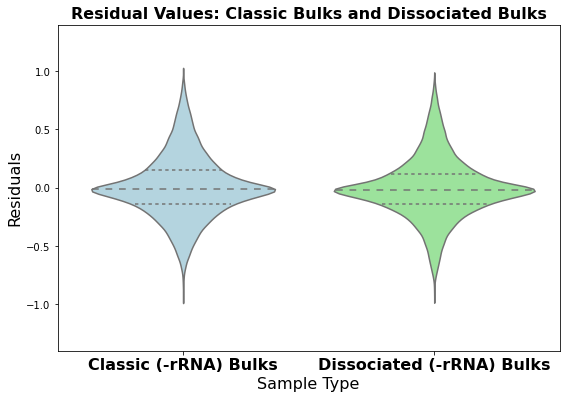

In [55]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
classic_bulks_values = residuals_bulks.values.flatten()
dissociated_bulks_values = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(classic_bulks_values) +
                                  ['Dissociated Bulks'] * len(dissociated_bulks_values),
                   'Residuals': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values: Classic Bulks and Dissociated Bulks', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

#These plots look very similar: could be due to certain genes being high in one distribution but low in the other one, 
#and the other way around, making them look visually the same but it's a different set of genes driving the high and lows.

Dissociated (polyA) Bulks and Dissociated (-rRNA) Bulks

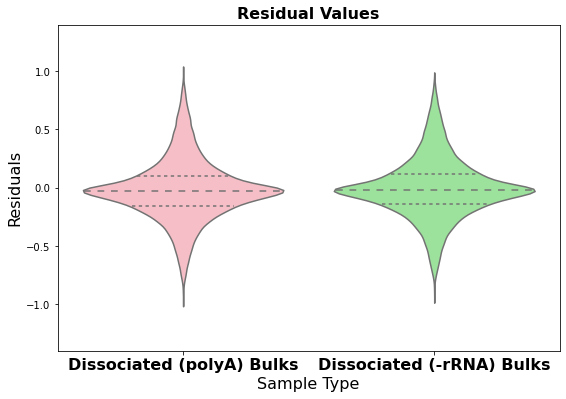

In [56]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
bulk_type_1 = residuals_disspolyabulks.values.flatten()
bulk_type_2 = residuals_dissbulks.values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals', data=df, ax=ax, inner='quartile', palette=[ 'lightpink','lightgreen'])
# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (polyA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold', fontname='Arial')

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals', fontsize=16, fontname='Arial')
plt.title('Residual Values', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

#These plots look very similar: could be due to certain genes being high in one distribution but low in the other one, 
#and the other way around, making them look visually the same but it's a different set of genes driving the high and lows.

**Distributions: Only Adipocyte Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

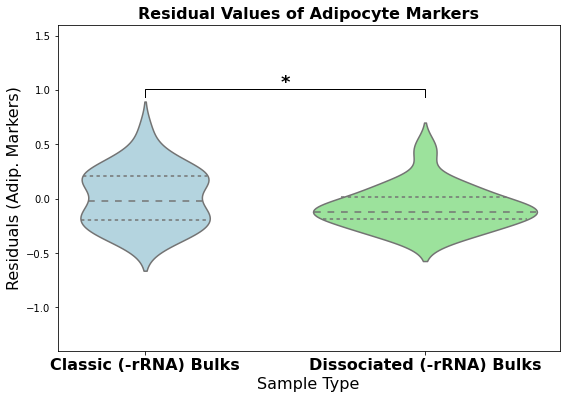

In [57]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue','lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.15, max_val+0.22
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

Dissociated (-rRNA) Bulks and Dissociated (polyA) Bulks

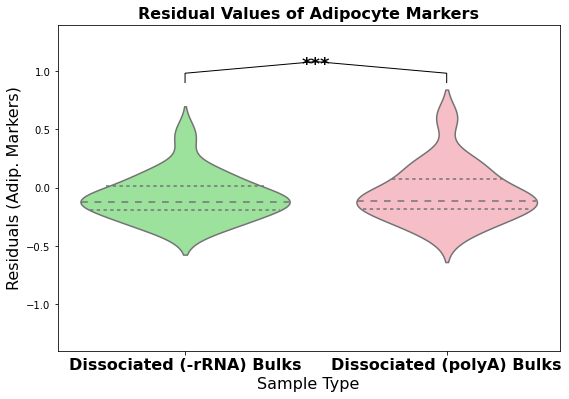

In [58]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

bulk_type_1 = residuals_dissbulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (Adip. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])

# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38# Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()


Classic (-rRNA) Bulks and Dissociated (polyA) Bulks

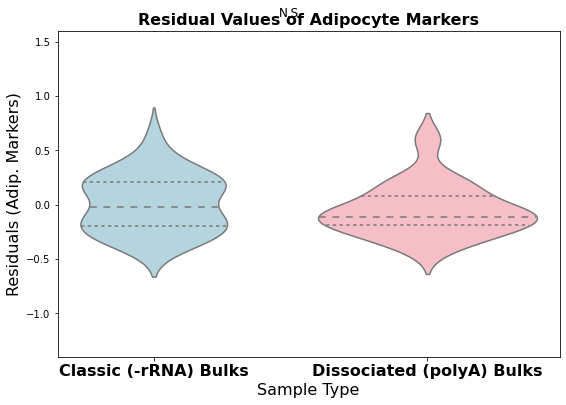

In [59]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, adip_markers)

classic_bulks_values = residuals_bulks[adip_intersect].values.flatten()
dissociated_bulks_values = residuals_disspolyabulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(classic_bulks_values) +
                                  ['Bulktype2'] * len(dissociated_bulks_values),
                   'Residuals (Adip. Markers)': np.concatenate([classic_bulks_values, dissociated_bulks_values])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Adip. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(classic_bulks_values, dissociated_bulks_values)

# Set a significance level (e.g., 0.05)
alpha = 0.05

#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.3, 1.4 # Adjusted higher y-coordinate
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Adip. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Adipocyte Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()

**Distributions: Only Dissociation Markers**

Classic (-rRNA) Bulks and Dissociated (-rRNA) Bulks

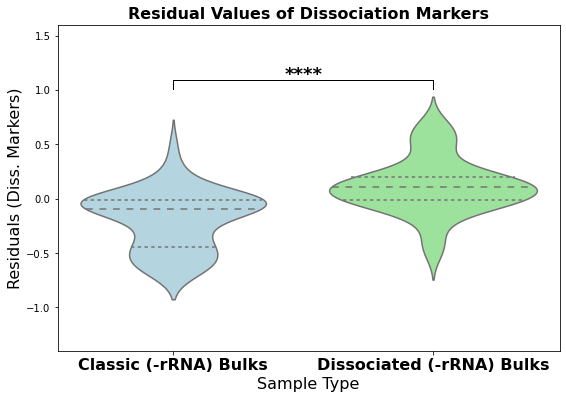

In [60]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
adip_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_bulks[adip_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[adip_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Bulktype1'] * len(bulk_type_1) +
                                  ['Bulktype2'] * len(bulk_type_2),
                   'Residuals (Diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (Diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightgreen'])

# Add labels to the x-axis
ax.set_xticklabels(['Classic (-rRNA) Bulks', 'Dissociated (-rRNA) Bulks'], fontsize=16, fontname='Arial', fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2-0.03, asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = 1.6, 1.7
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results
    
plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.6)
plt.show()


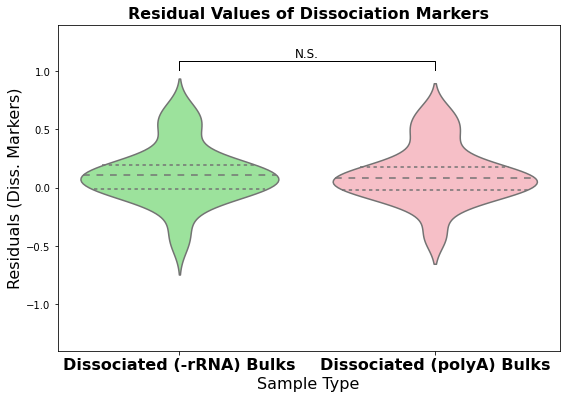

In [61]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_dissbulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_disspolyabulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightgreen', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

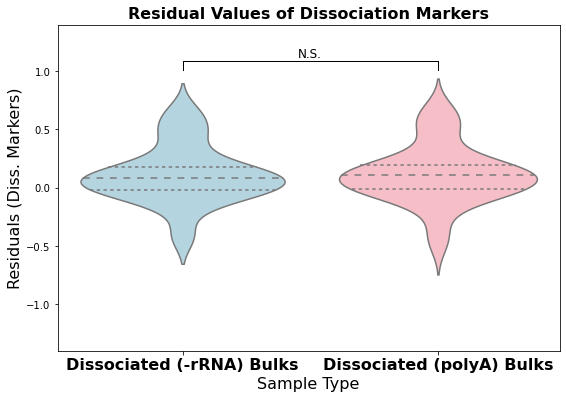

In [62]:
# Sample data for "Classic Bulks" and "Dissociated Bulks"
diss_intersect = np.intersect1d(residuals_bulks.columns, diss_response)

bulk_type_1 = residuals_disspolyabulks[diss_intersect].values.flatten()
bulk_type_2 = residuals_dissbulks[diss_intersect].values.flatten()

# Combine data into a DataFrame
df = pd.DataFrame({'Sample Type': ['Classic Bulks'] * len(bulk_type_1) +
                                  ['Dissociated Bulks'] * len(bulk_type_2),
                   'Residuals (diss. Markers)': np.concatenate([bulk_type_1, bulk_type_2])})

# Create a figure and axis for violin plots
plt.figure(figsize=(9, 6))
ax = plt.gca()

# Create violin plots for the two datasets
sns.violinplot(x='Sample Type', y='Residuals (diss. Markers)', data=df, ax=ax, inner='quartile', palette=['lightblue', 'lightpink'])

# Add labels to the x-axis
ax.set_xticklabels(['Dissociated (-rRNA) Bulks', 'Dissociated (polyA) Bulks'], fontsize=16, fontweight='bold')

# Calculate p-value for the Wilcoxon signed-rank test
# Perform the paired t-test
t_statistic, p_value = stats.wilcoxon(bulk_type_1, bulk_type_2)

# Set a significance level (e.g., 0.05)
alpha = 0.05
#getting maximum value for significance line:
max_val = np.max([max(bulk_type_1), max(bulk_type_2)])
# Determine if the difference is statistically significant
if p_value < alpha:
    significance_label = f"Significant p={np.round(p_value, 3)} (p < 0.05)"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, (x1 + x2) / 2, x2, x2], [y1, y2, y2 + 0.1, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2 , asterisks, ha='center', va='bottom', fontsize=18, fontweight='bold', fontname='Arial')
else:
    significance_label = f"Not Significant p={np.round(p_value, 3)}"
    asterisks = vp.convert_pvalue_to_asterisks(p_value)
    x1, x2 = 0, 1
    y1, y2 = max_val + 0.3, max_val+0.38
    # Add a line and asterisks to indicate statistical significance
    plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], linewidth=1, color='black')
    plt.text((x1 + x2) / 2, y2, s='N.S.', ha='center', va='bottom', fontsize=12, fontname='Arial')
    # No asterisks for non-significant results

plt.xlabel('Sample Type', fontsize=16, fontname='Arial')
plt.ylabel('Residuals (Diss. Markers)', fontsize=16, fontname='Arial')
plt.title('Residual Values of Dissociation Markers', fontsize=16, fontname='Arial', fontweight='bold')
plt.ylim(-1.4, 1.4)
plt.show()

## PCA

Combo (Classic and Dissociated (-rRNA together))

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


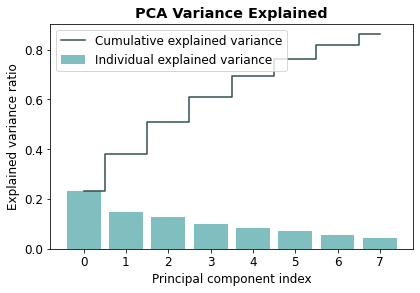

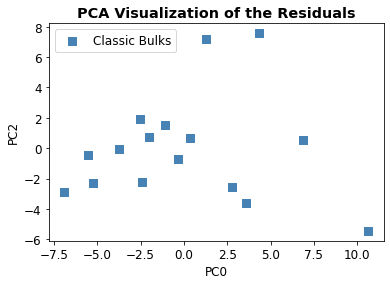

Component_0 Component_1 Component_2 Component_3 Component_4 Component_5  \
0          VTCN1     FAM107A        SDC1        PLK2      KIF26B       LAMA3   
1          PELI2      B3GNT5     PLEKHG5        RELT       INHBA        NAV2   
2         SPINT2     TFCP2L1        MEG8  AC245014.3      PDLIM3  AC136475.3   
3           HID1        IRS2      KCNMA1       IFRD1       UNC5B      RASSF8   
4           XAF1      SNHG17       CADM1   LINC00511     BHLHE41       NRXN3   
...          ...         ...         ...         ...         ...         ...   
4579         MGP      SLFN11        CCL2        MT1A     IGF2BP2        NET1   
4580        RND3      BTN3A1       USP53      DNAJC5     FAM107A      PGRMC1   
4581        PLAT         EHF      CHI3L1      PIK3R3     FAM110C      CREBZF   
4582       CLDN1        LY75       IGHG1      CHST15        CCL2       PTGDS   
4583     ALDH1A3       BIRC3        IGKC       F13A1       THSD4      NUP210   

     Component_6 Component_7  
0          CLDN1        EYA2  
1          MYH11      RNF152  
2          MERTK        CDH6  
3          IGLC3      IFI44L  
4         KCNMA1        ESR1  
...          ...         ...  
4579       STON2       EPHB6  
4580        DSG2      FBXO32  
4581       STMN1         CGN  
4582        CD36       KRT19  
4583       ERAP2        ASS1  

[4584 rows x 8 columns]

In [63]:
# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)
num_pca_components_combo = 8
pca_res = dict()
df = residuals_combo  # transposing to get length of genes instead of samples
pca_fit = PCA(n_components=num_pca_components_combo)
pca_results = pca_fit.fit_transform(df.values)

exp_var_pca = pca_fit.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# Plot variance explained
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', color='teal', label='Individual explained variance')
plt.step(range(0, len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid', color='darkslategrey', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.title("PCA Variance Explained", fontweight='bold')
plt.show()

# PCA Visualization
plt.scatter(pca_results[:, 0], pca_results[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# 'residuals_all.columns' contains the names of the genes
comp_genes= []
pca_genes = pd.DataFrame()
# Iterate through each component
for component_idx in range(num_pca_components_combo):
    # Calculate loadings for the current component
    loadings = pca_fit.components_.T * np.sqrt(pca_fit.explained_variance_)

    # Sort genes by their influence on the current component
    sorted_genes = residuals_bulks.columns[np.argsort(loadings[:, component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = pca_fit.components_.shape[1]
    top_genes = sorted_genes[-N:]

    pca_genes[component_idx] = top_genes[::-1]
    comp_genes = np.append(comp_genes, top_genes)
pca_genes.columns = ["Component_0","Component_1","Component_2", "Component_3",
                     "Component_4",  "Component_5", "Component_6", "Component_7"]                      
pca_genes   


In [64]:
# Separate the first and last 8 samples (by sample type)
first_half_samples = pca_results[:8]
second_half_samples = pca_results[-8:]

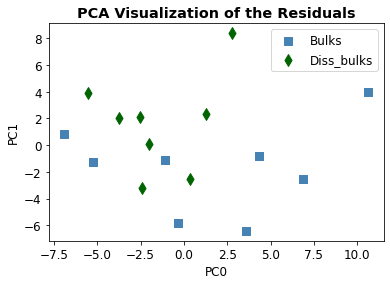

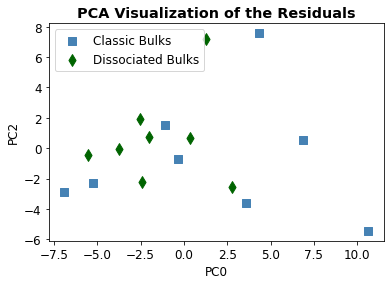

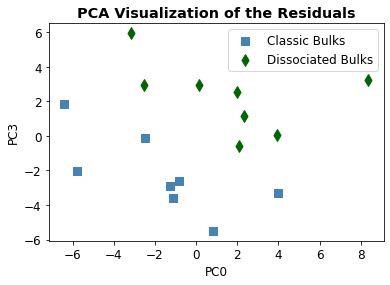

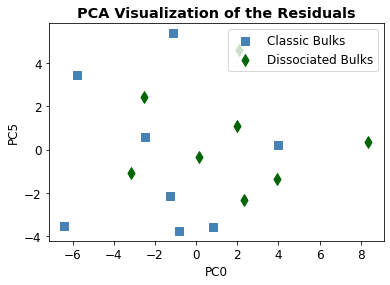

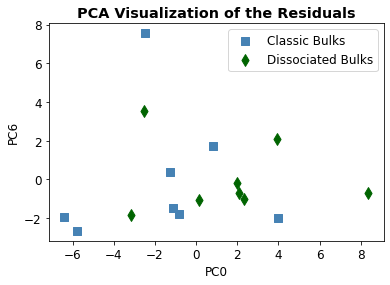

In [65]:
marker_size = 70

# Set font to Arial
font = {'family': 'Arial', 'weight': 'normal', 'size': 12}
plt.rc('font', **font)

# PCA Visualization of the Residuals
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 1], label="Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 1], label="Diss_bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC1")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 0], first_half_samples[:, 2], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 0], second_half_samples[:, 2], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC2")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 3], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 3], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC3")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 4], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 4], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC5")
plt.show()

# PCA Visualization
plt.scatter(first_half_samples[:, 1], first_half_samples[:, 5], label="Classic Bulks", c='steelblue', marker='s', s=marker_size)
plt.scatter(second_half_samples[:, 1], second_half_samples[:, 5], label="Dissociated Bulks", c='darkgreen', marker='d', s=marker_size)
plt.legend()
plt.title("PCA Visualization of the Residuals", fontweight='bold')
plt.xlabel("PC0")
plt.ylabel("PC6")
plt.show()



findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


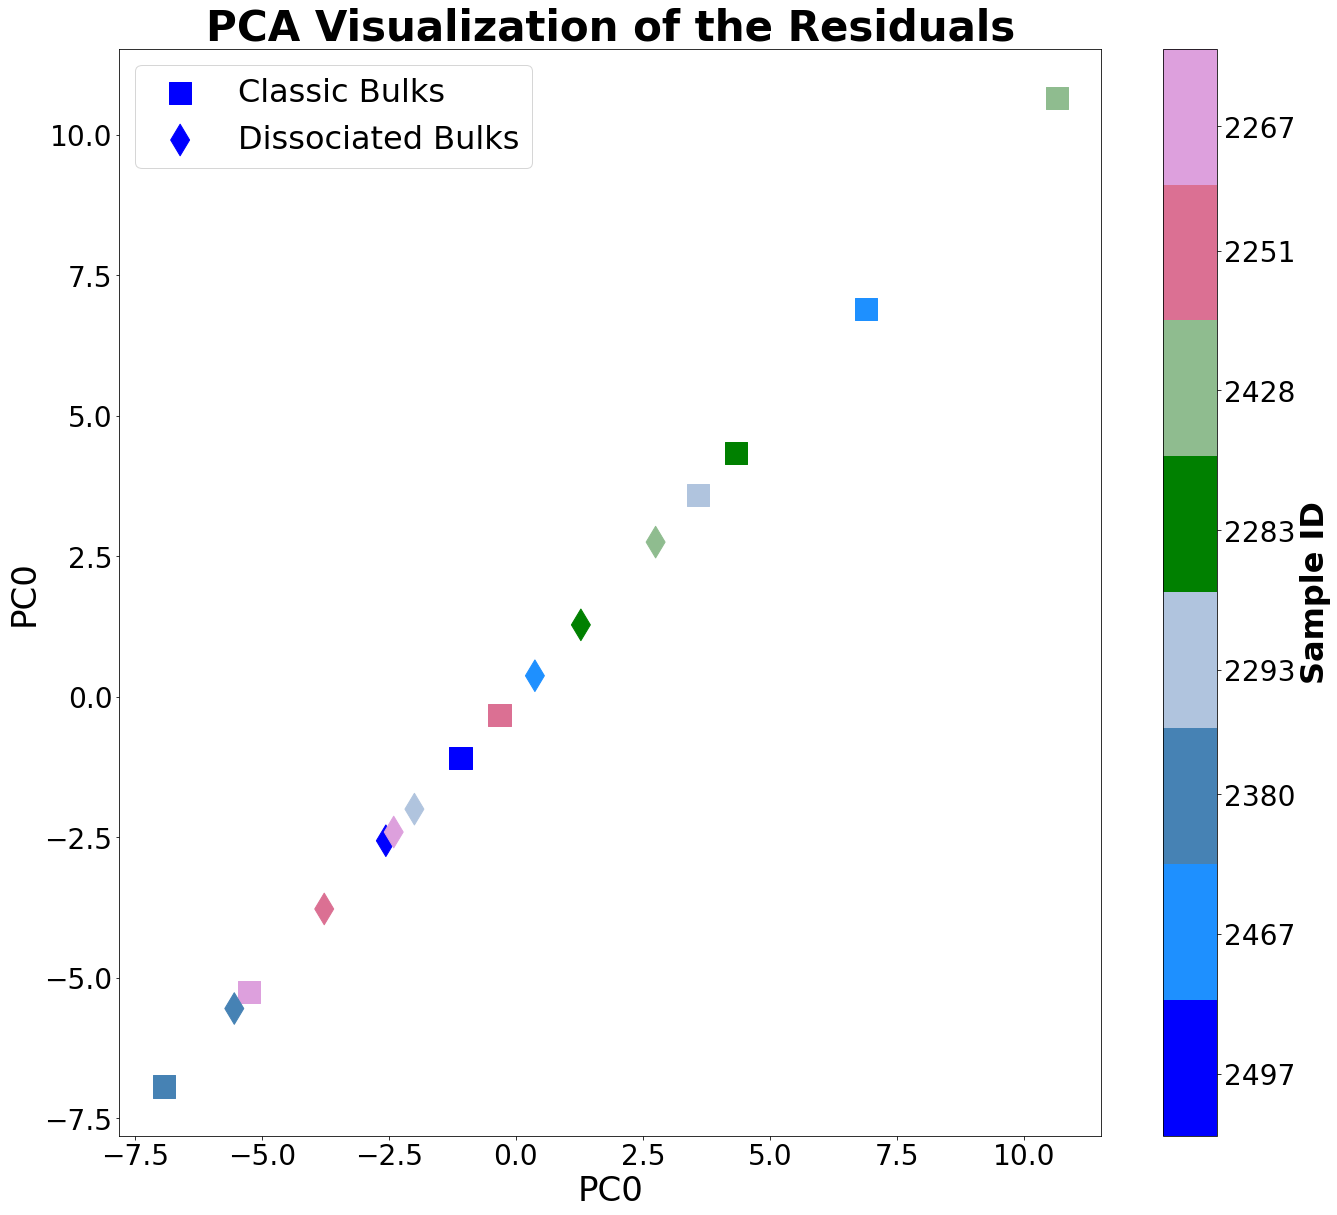

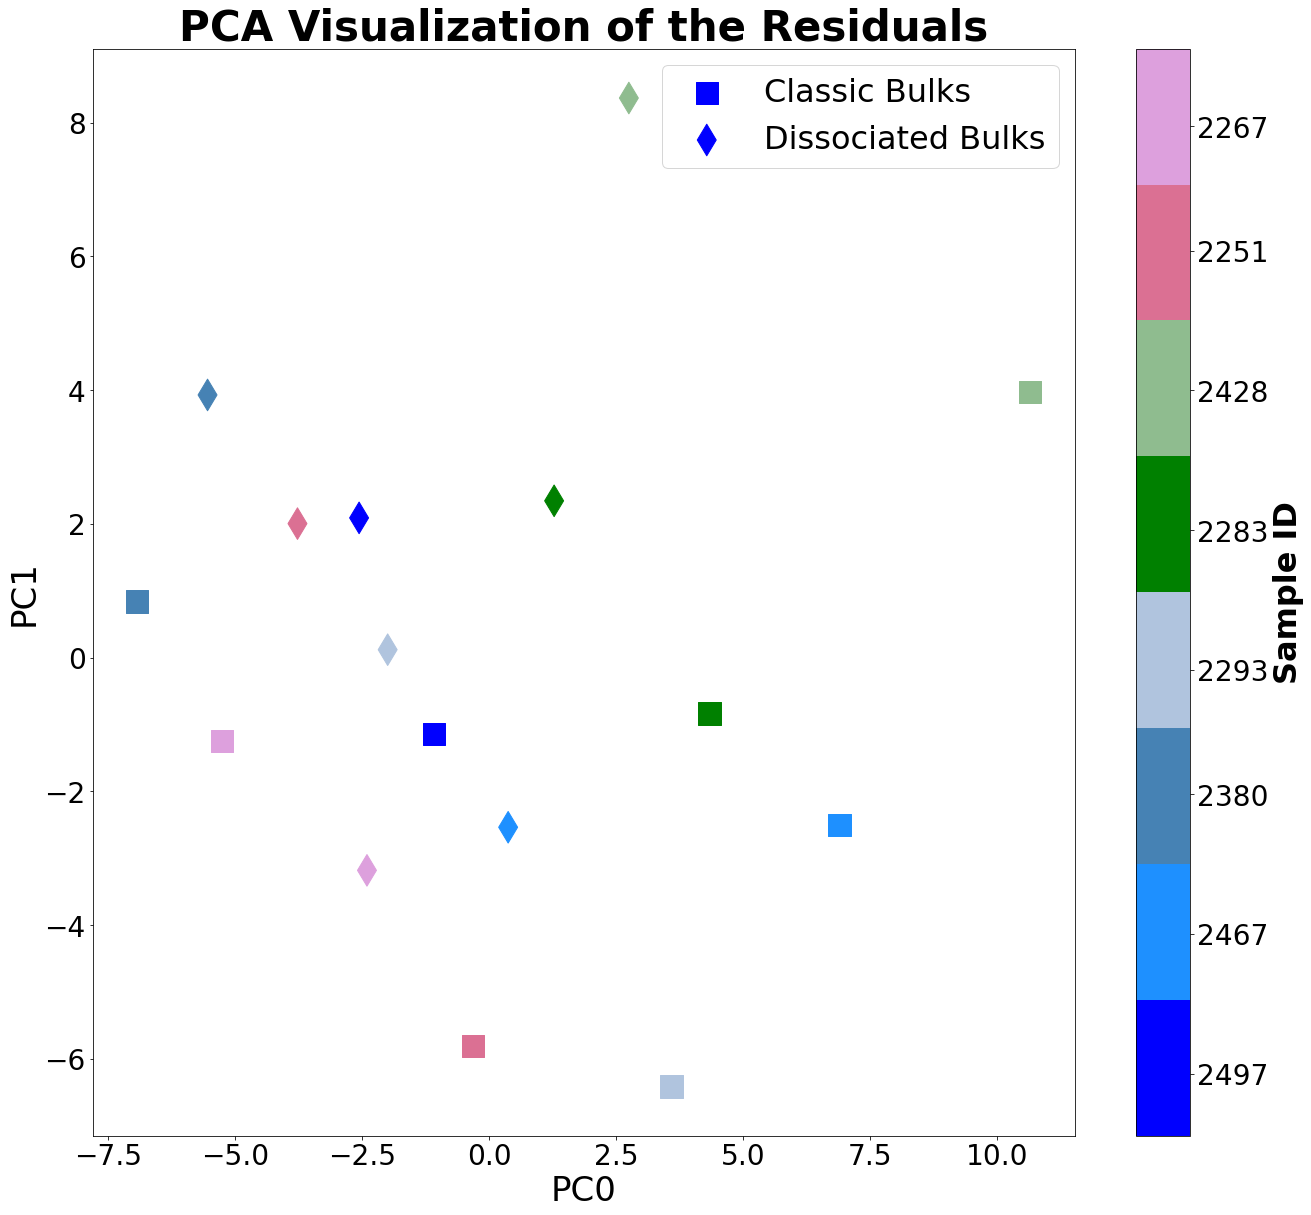

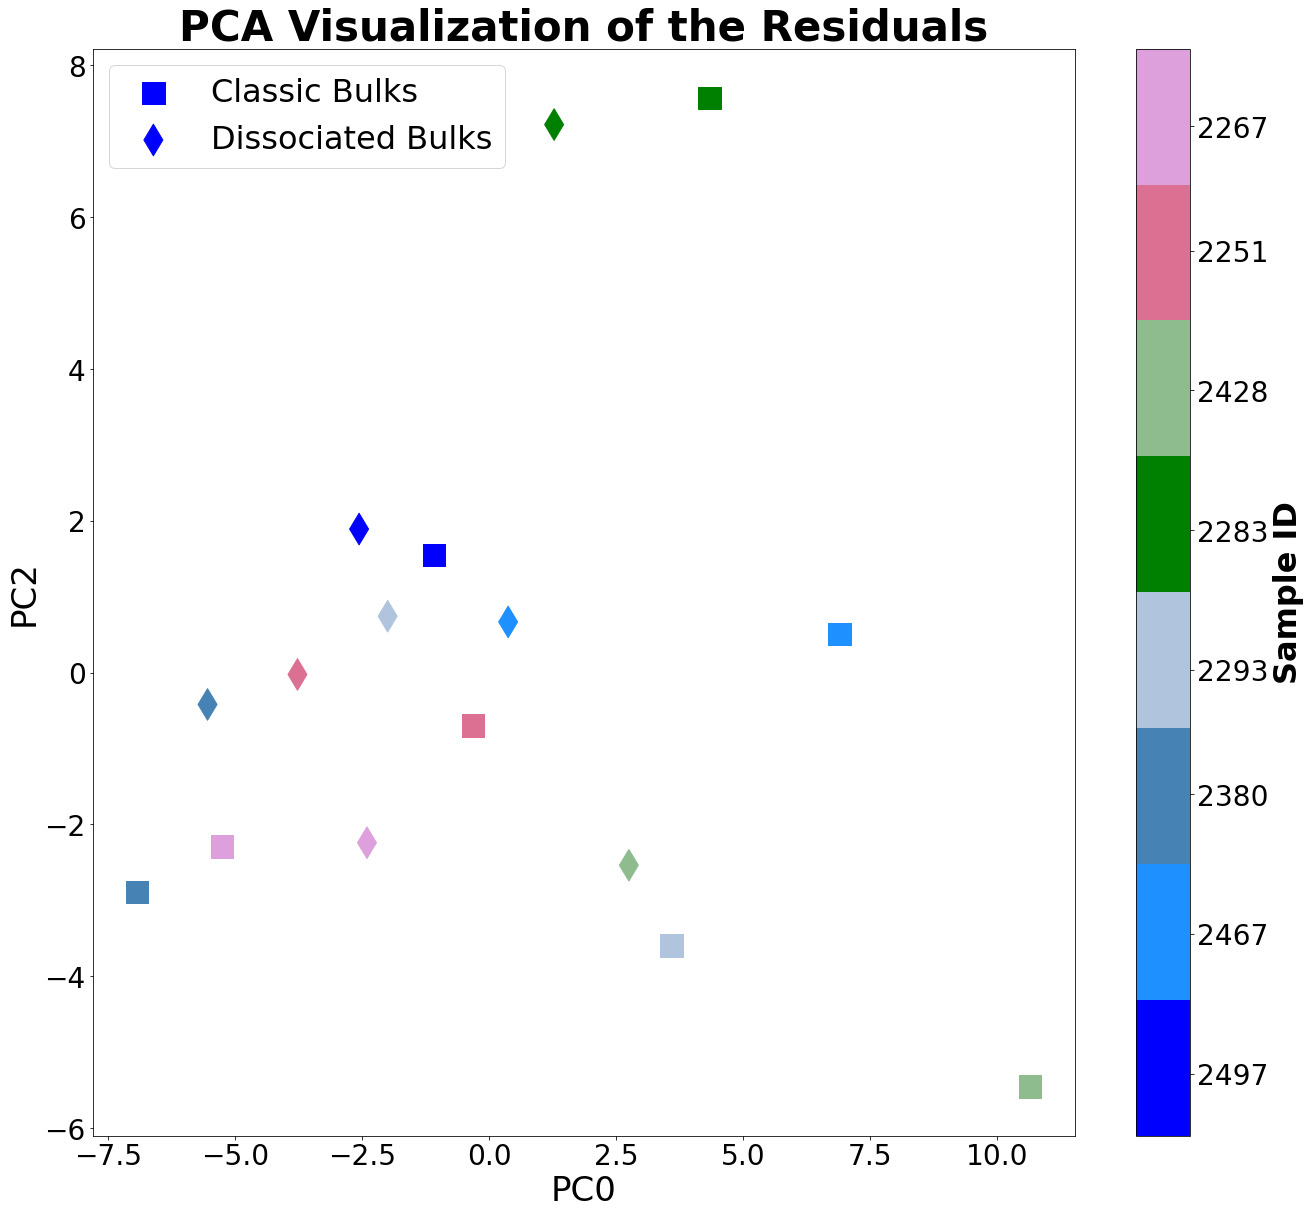

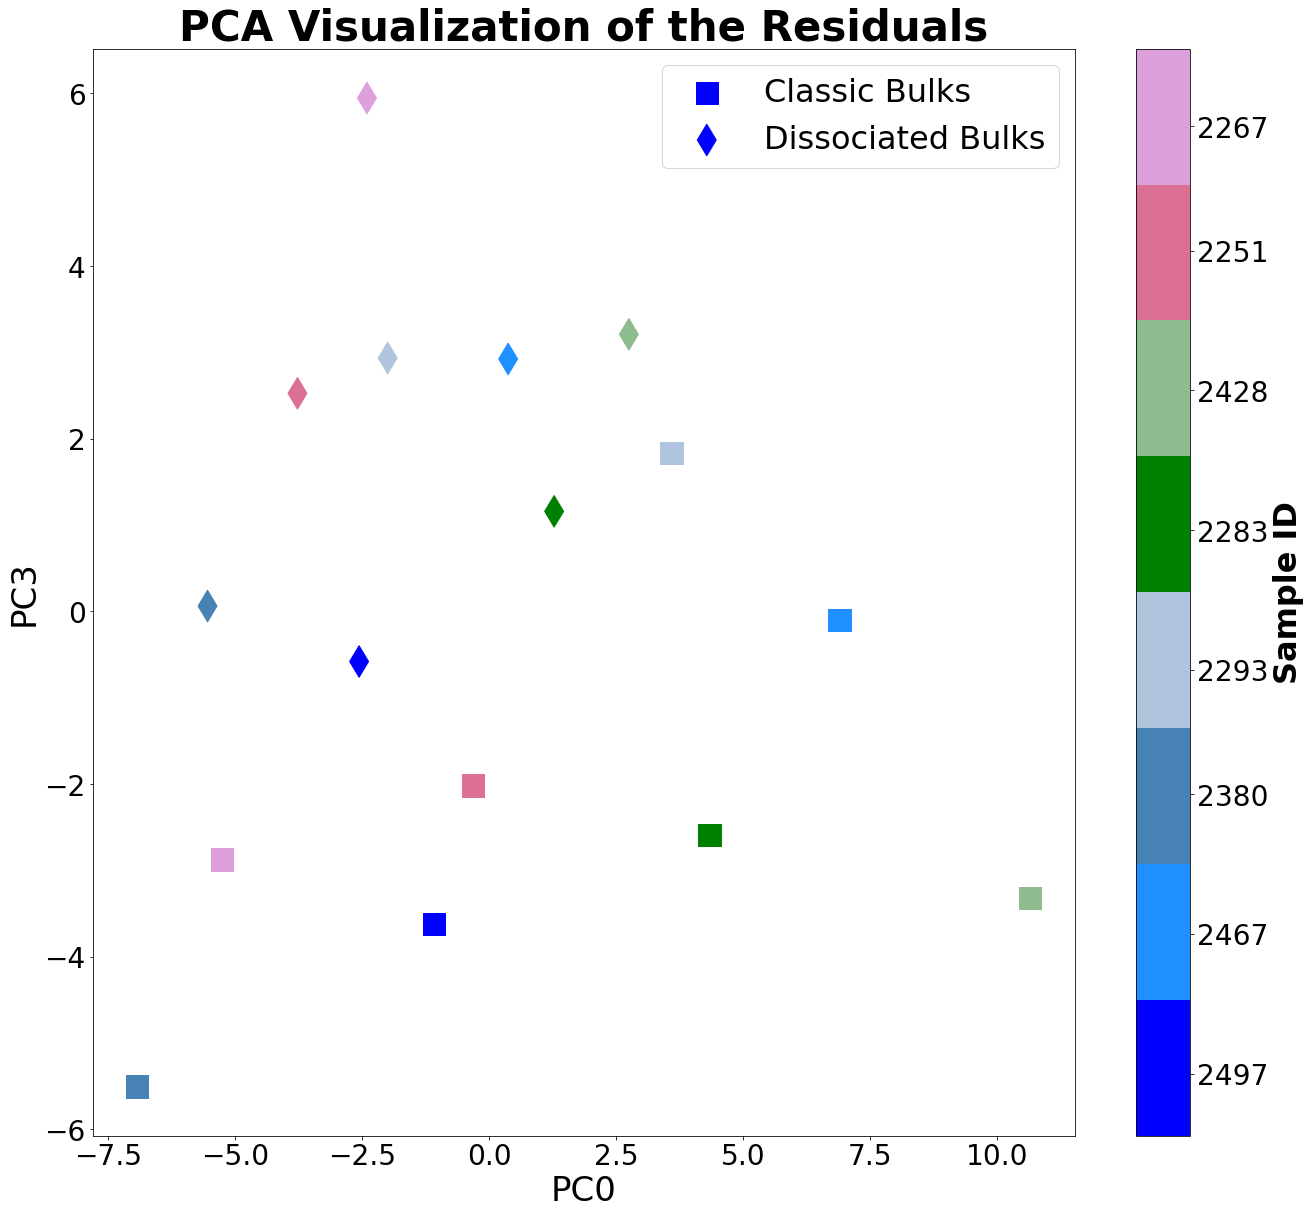

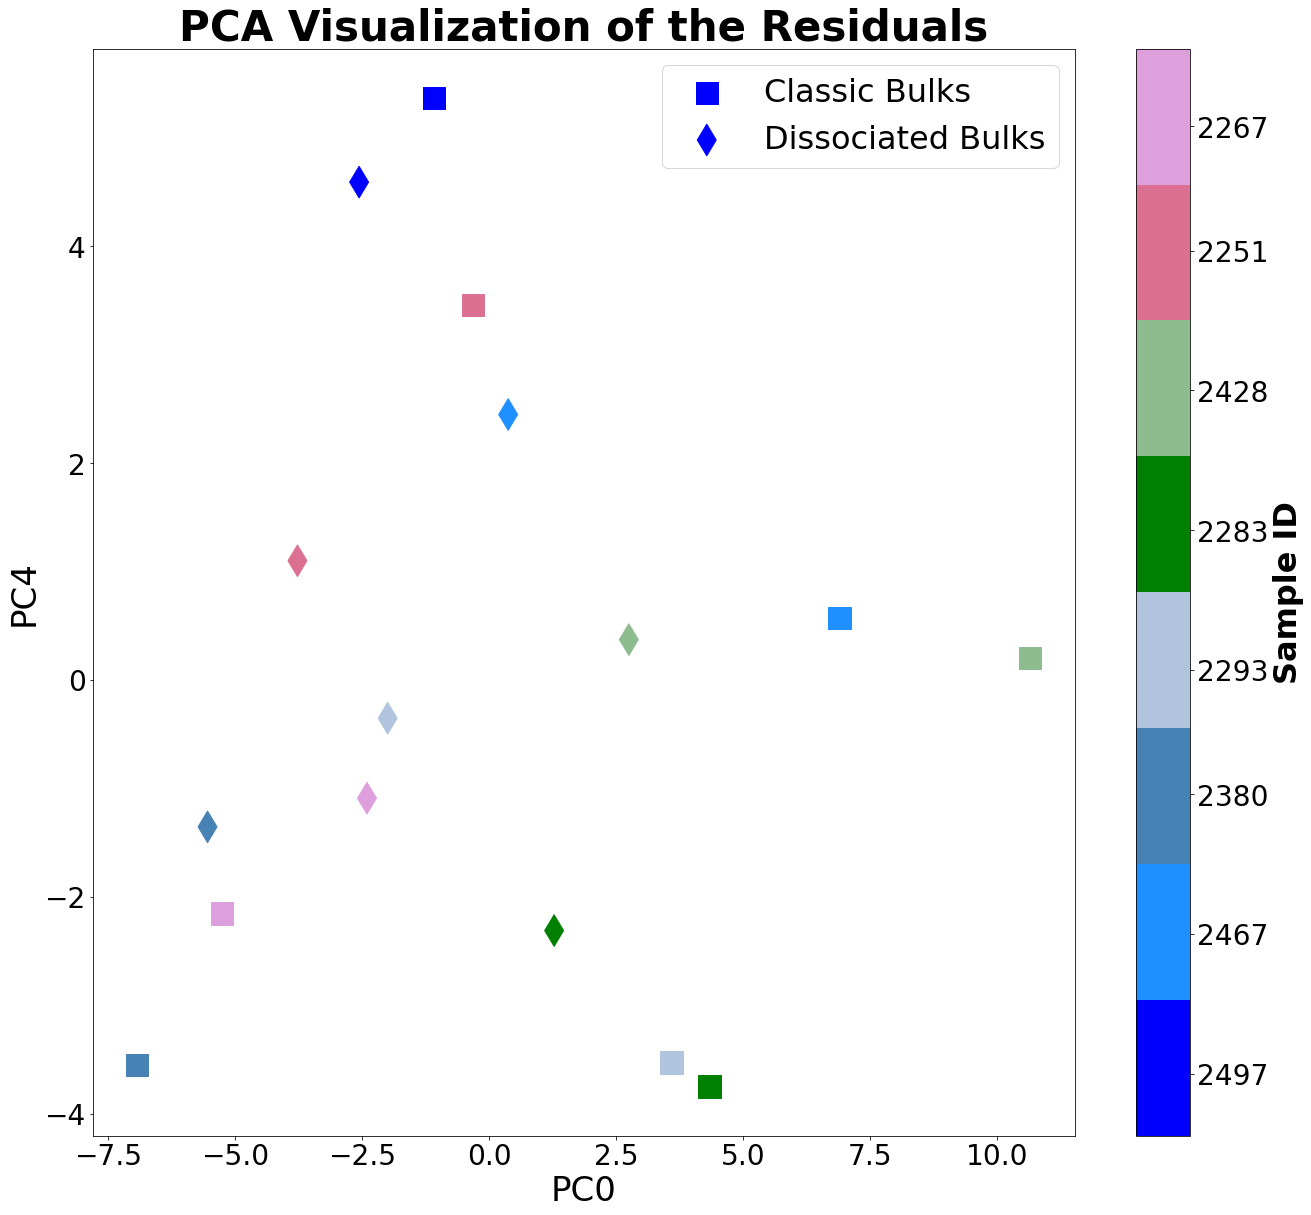

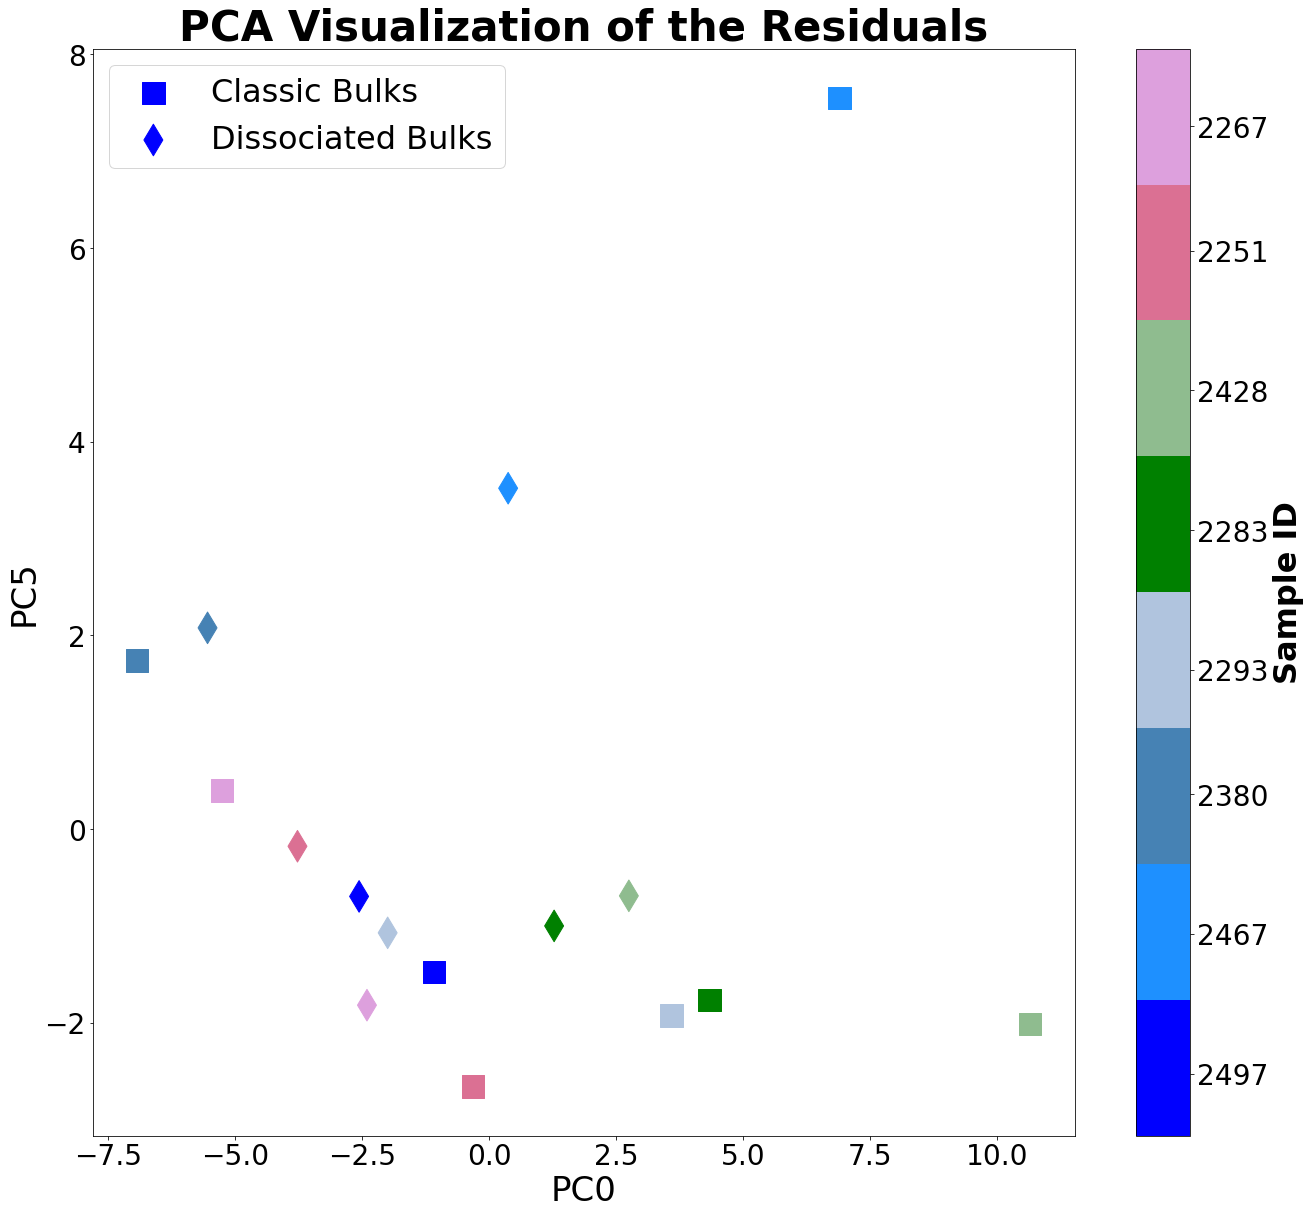

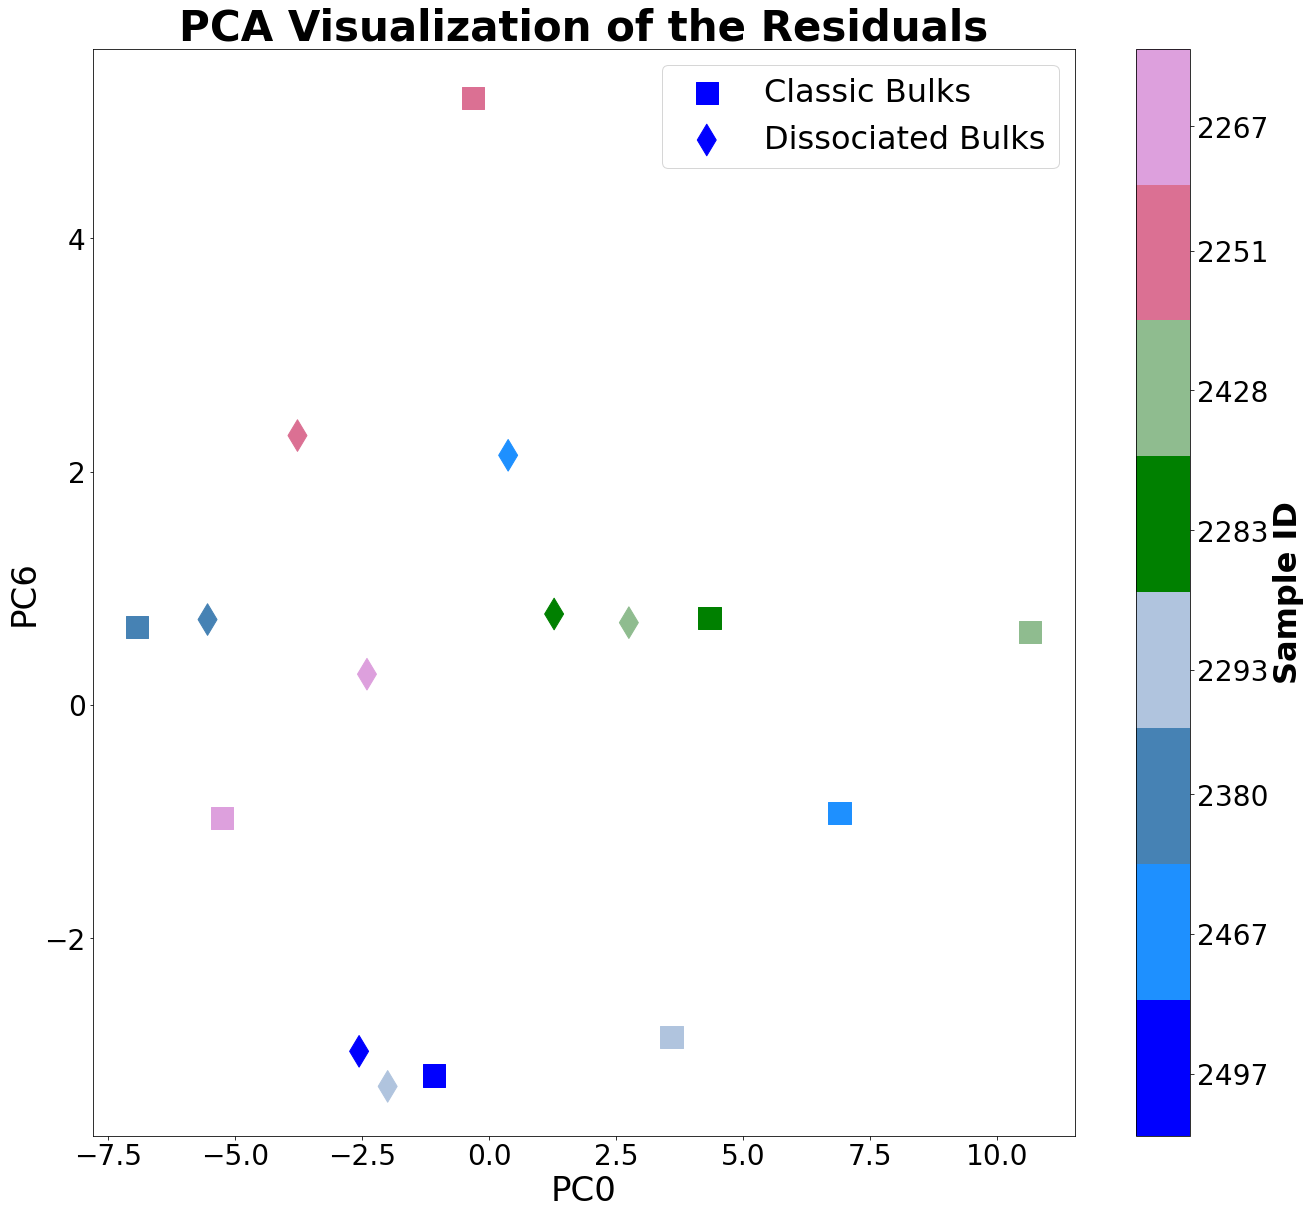

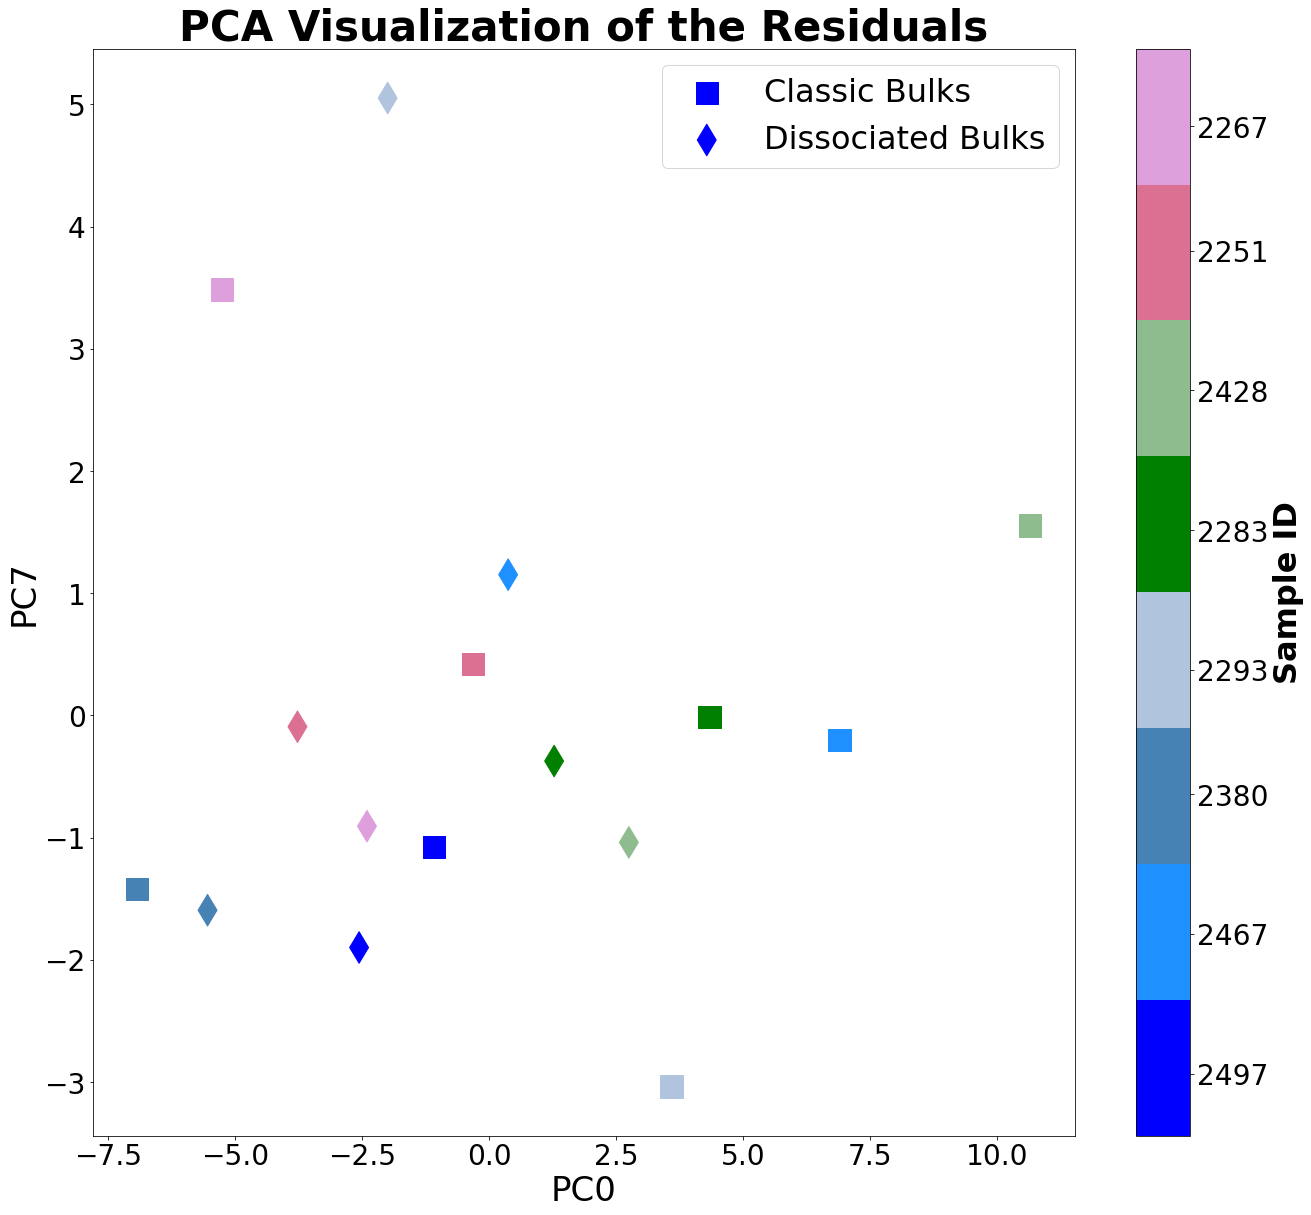

In [66]:
for idx in [0,1,2,3,4,5,6,7]:
    # Assuming `row_indices` contains the row indices of your samples
    row_indices = np.tile(range(1, 9), 2)
    plt.figure(figsize = (22,20))
    # Define custom colors
    custom_colors = ['blue','dodgerblue','steelblue','lightsteelblue','green','darkseagreen','palevioletred','plum']

    # Create a custom colormap
    cmap_custom = mcolors.ListedColormap(custom_colors)
    marker_size = 500

    # PCA Visualization
    scatter1 = plt.scatter(first_half_samples[:, 0], first_half_samples[:, idx], label="Classic Bulks", c=row_indices[:len(first_half_samples)], 
                                cmap=cmap_custom, marker='s', s=marker_size)
    scatter2 = plt.scatter(second_half_samples[:, 0], second_half_samples[:, idx], label="Dissociated Bulks", c=row_indices[len(first_half_samples):], 
                                cmap=cmap_custom, marker='d', s=marker_size)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    # Add colorbar for reference
    cbar = plt.colorbar()
    cbar.set_label('Sample ID', fontsize=32, fontweight='bold')

    # Adjust colorbar ticks to be centered between colors
    cbar.set_ticks([1.4, 2.3 ,3.2 ,4, 4.9 , 5.8 ,6.7 ,7.5])
    cbar.set_ticklabels(sample_ids )
    cbar.ax.tick_params(labelsize=28)
    # Change the color of the little marker in the legend
    legend = plt.legend(fontsize=32)

    plt.title("PCA Visualization of the Residuals", fontweight='bold', fontsize=42, fontname='Arial')
    plt.xlabel("PC0", fontsize=34, fontname='Arial')
    plt.ylabel(f"PC{idx}", fontsize=34, fontname='Arial')
    plt.show()

In [67]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = pd.DataFrame(pca_results)
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0        0.0     1.272506  0.223922
1        1.0    -1.863582  0.083489
2        2.0    -0.743139  0.469685
3        3.0    -4.220090  0.000856
4        4.0    -0.581800  0.569952
5        5.0    -0.027056  0.978797
6        6.0    -0.143790  0.887716
7        7.0    -0.070071  0.945128
Components with significantly different means:
   Component  T-Statistic   P-Value
3        3.0     -4.22009  0.000856


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


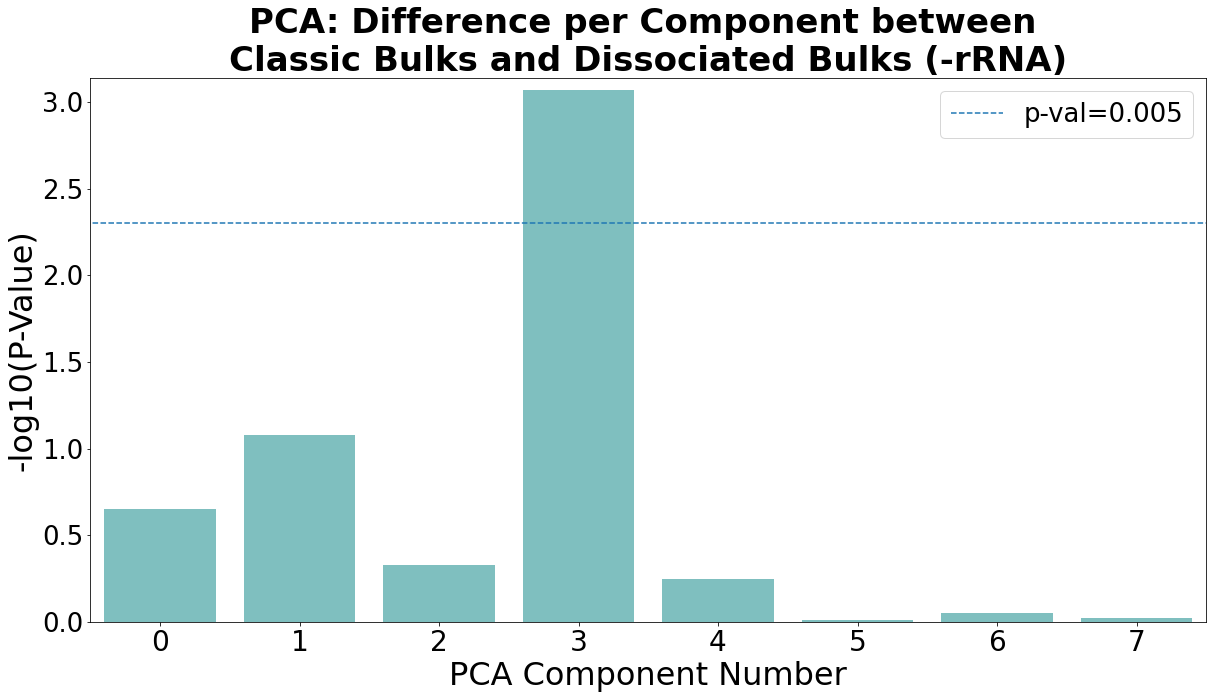

In [68]:
# Bar plot for each component
plt.figure(figsize=(20, 10))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)
plt.xlabel('PCA Component Number', fontsize=32, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=32, fontname='Arial')
plt.plot([-1,0,1,2,3,4,5,6,7,8],np.repeat(-np.log10(0.005),10),linestyle='--', label='p-val=0.005')
plt.title('PCA: Difference per Component between \nClassic Bulks and Dissociated Bulks (-rRNA)', 
            fontsize=34, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3,4,5,6,7], fontsize=28)
plt.yticks(fontsize=26)
plt.ylim(0,max(-np.log10(results['P-Value']))+0.07)
plt.legend(fontsize=26)
plt.xlim(-0.5,7.5)
plt.show()

And evaluating the GOrilla results (of combo residual):

In [69]:
# The sheets on the Excel
#for figure sized
num=0
if add_adipo:
    added = "PCA_genes_residuals_combo_ADIP.xlsx"
else:
    added ="PCA_genes_residuals_combo.xlsx"
sheet_names = ['Component_0','Component_1','Component_2','Component_3', 'Component_4', 'Component_5', 'Component_6', 'Component_7']  

In [70]:
#and exporting PCA genes per component for gene ontology analysis.

''' NOTE: You'll need to run GOrilla on these lists for the next part!'''
pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"{added}")
pca_genes.to_excel(pca_name_path, sheet_name = "PCA_Components_Genes")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


filtered: (30, 11)


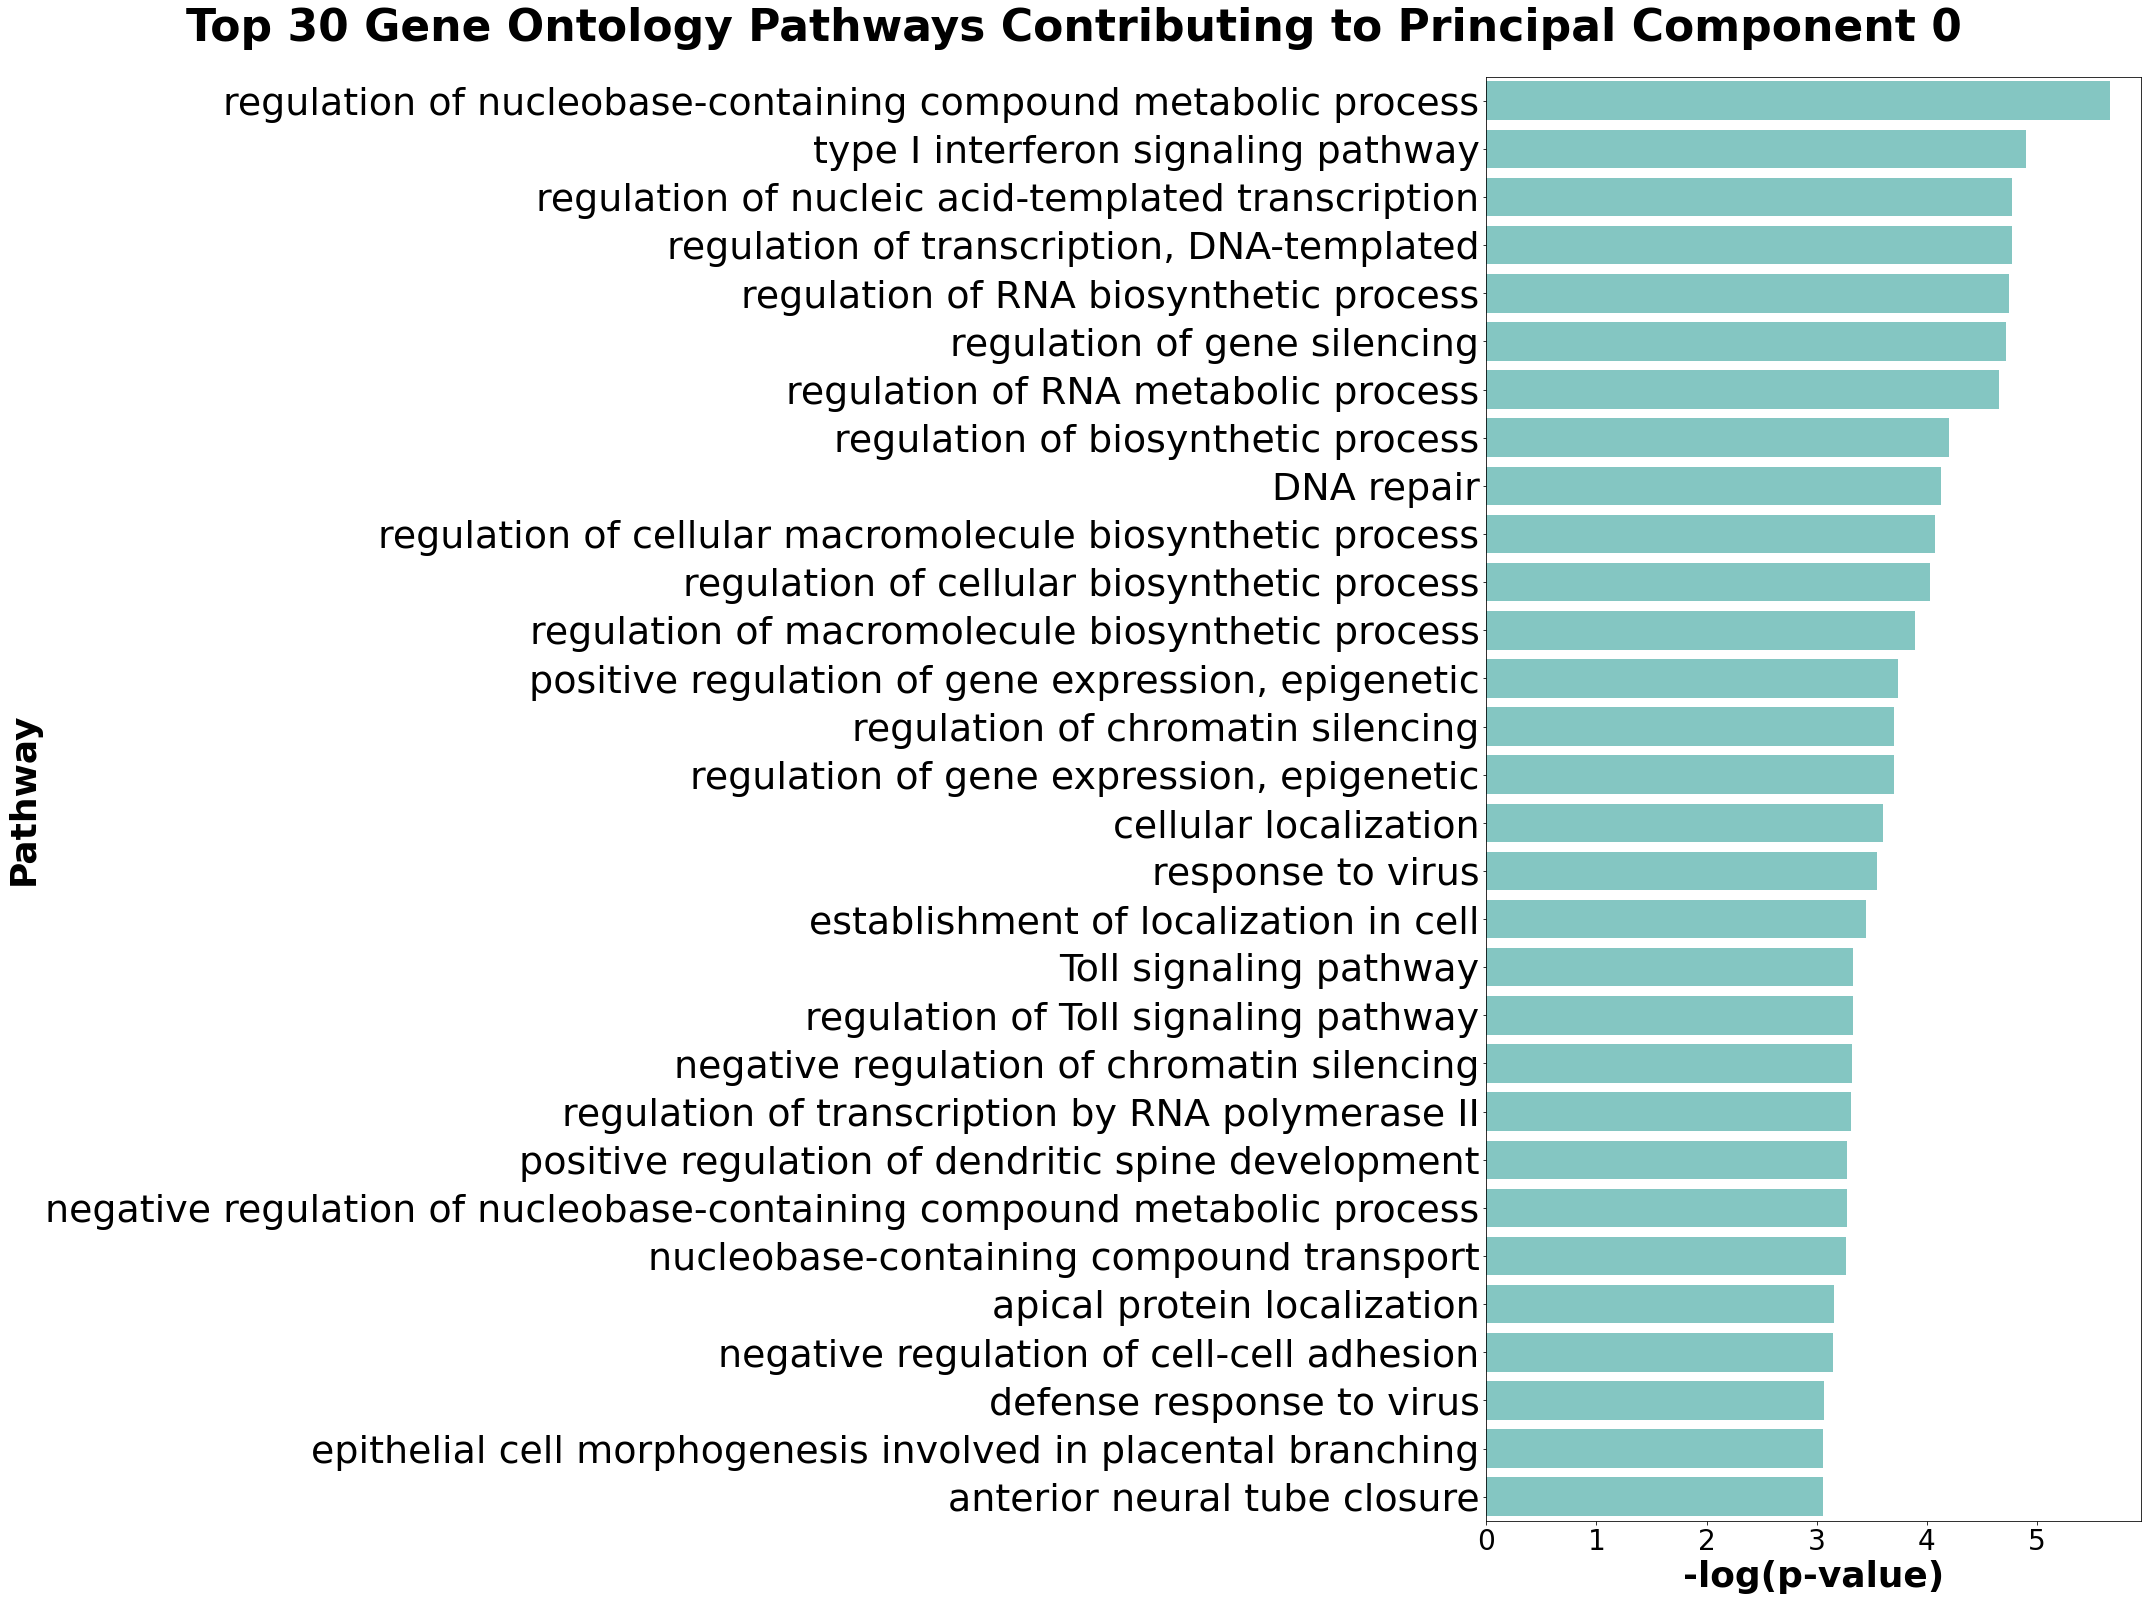

filtered: (30, 11)


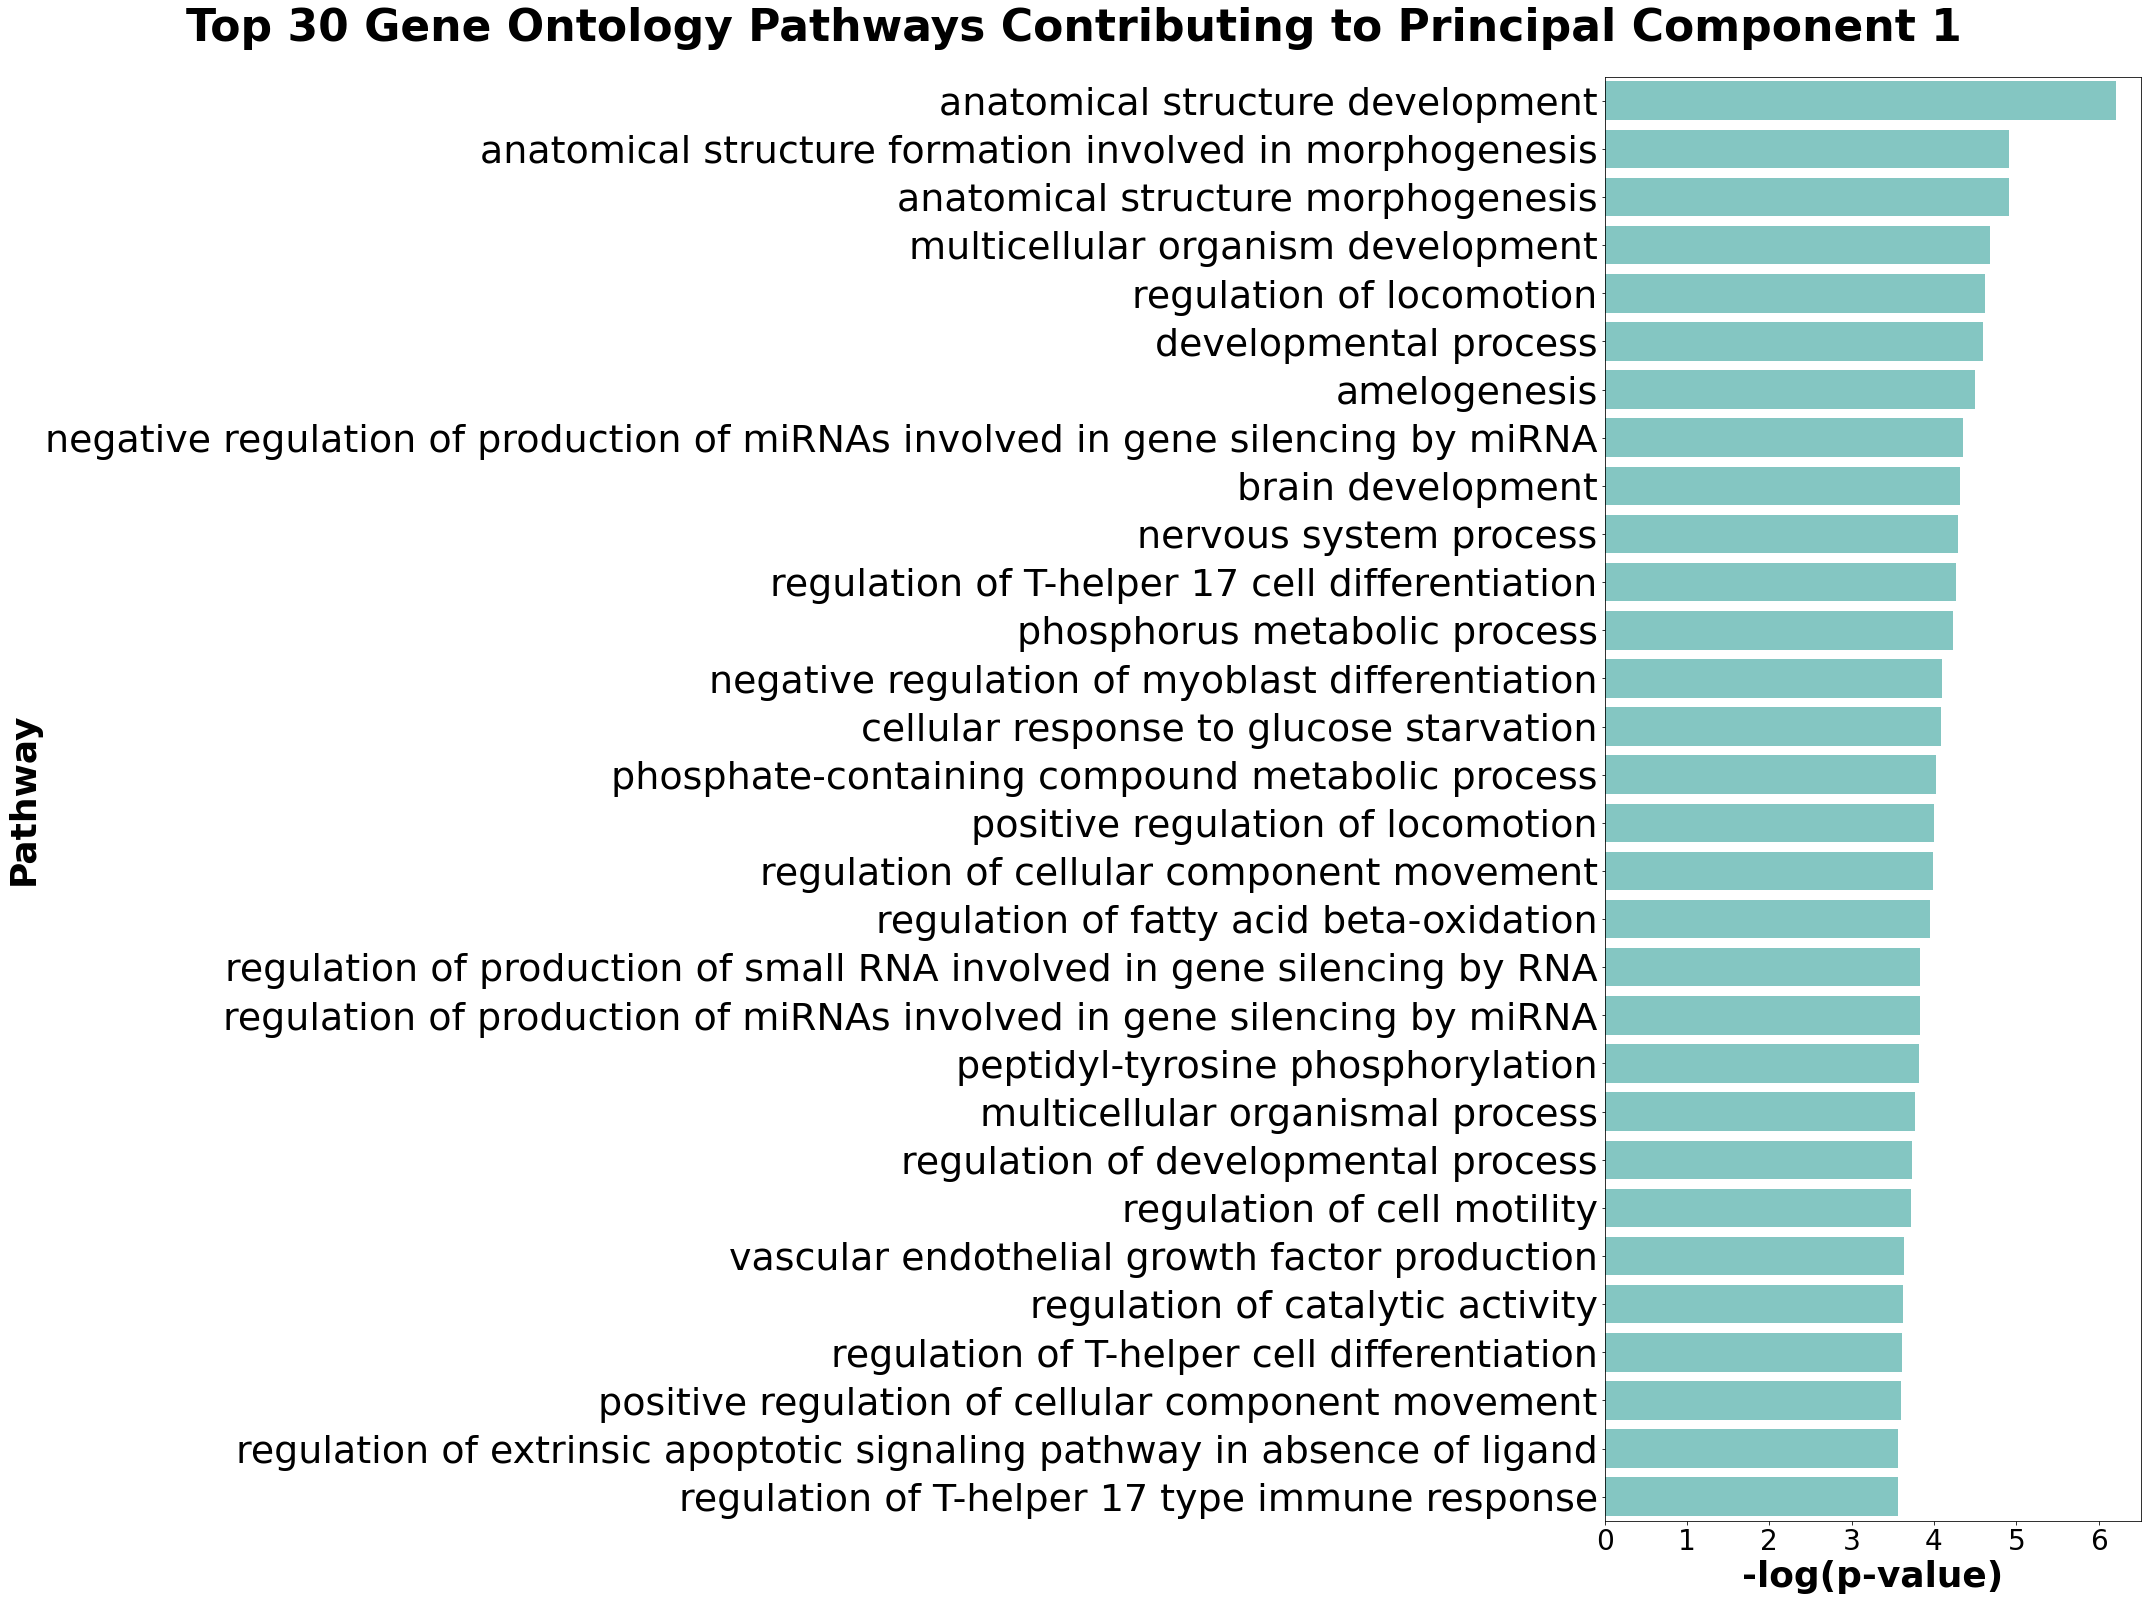

filtered: (30, 11)


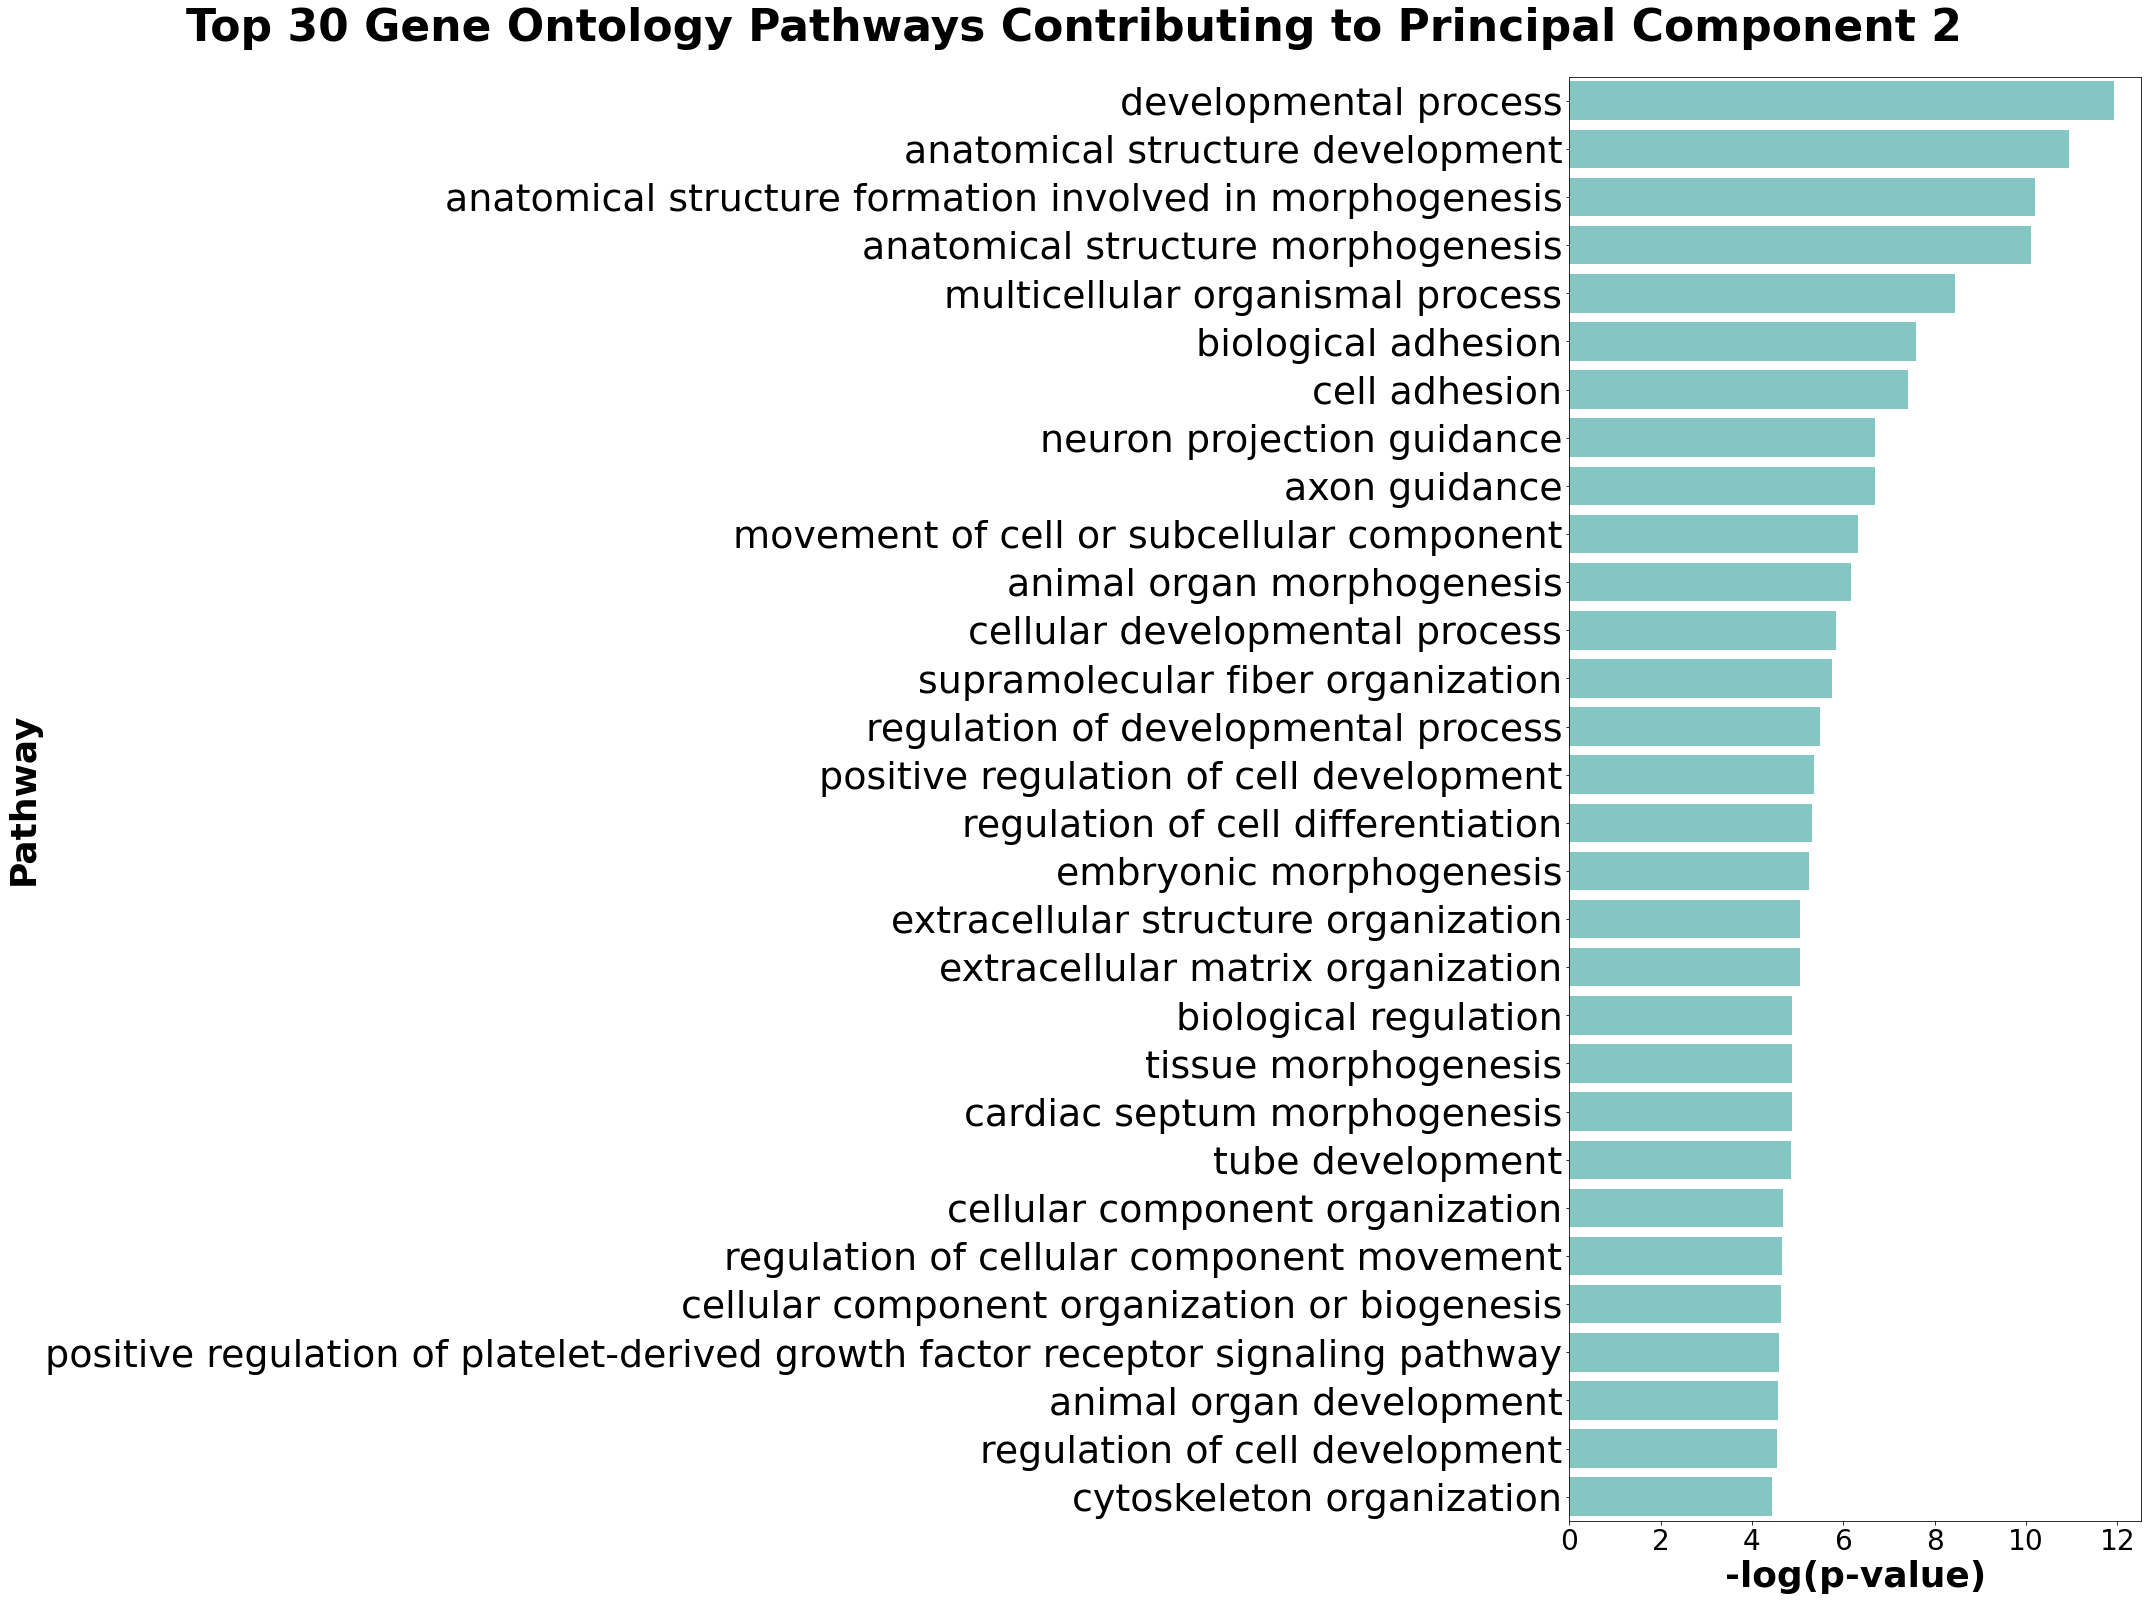

filtered: (30, 11)


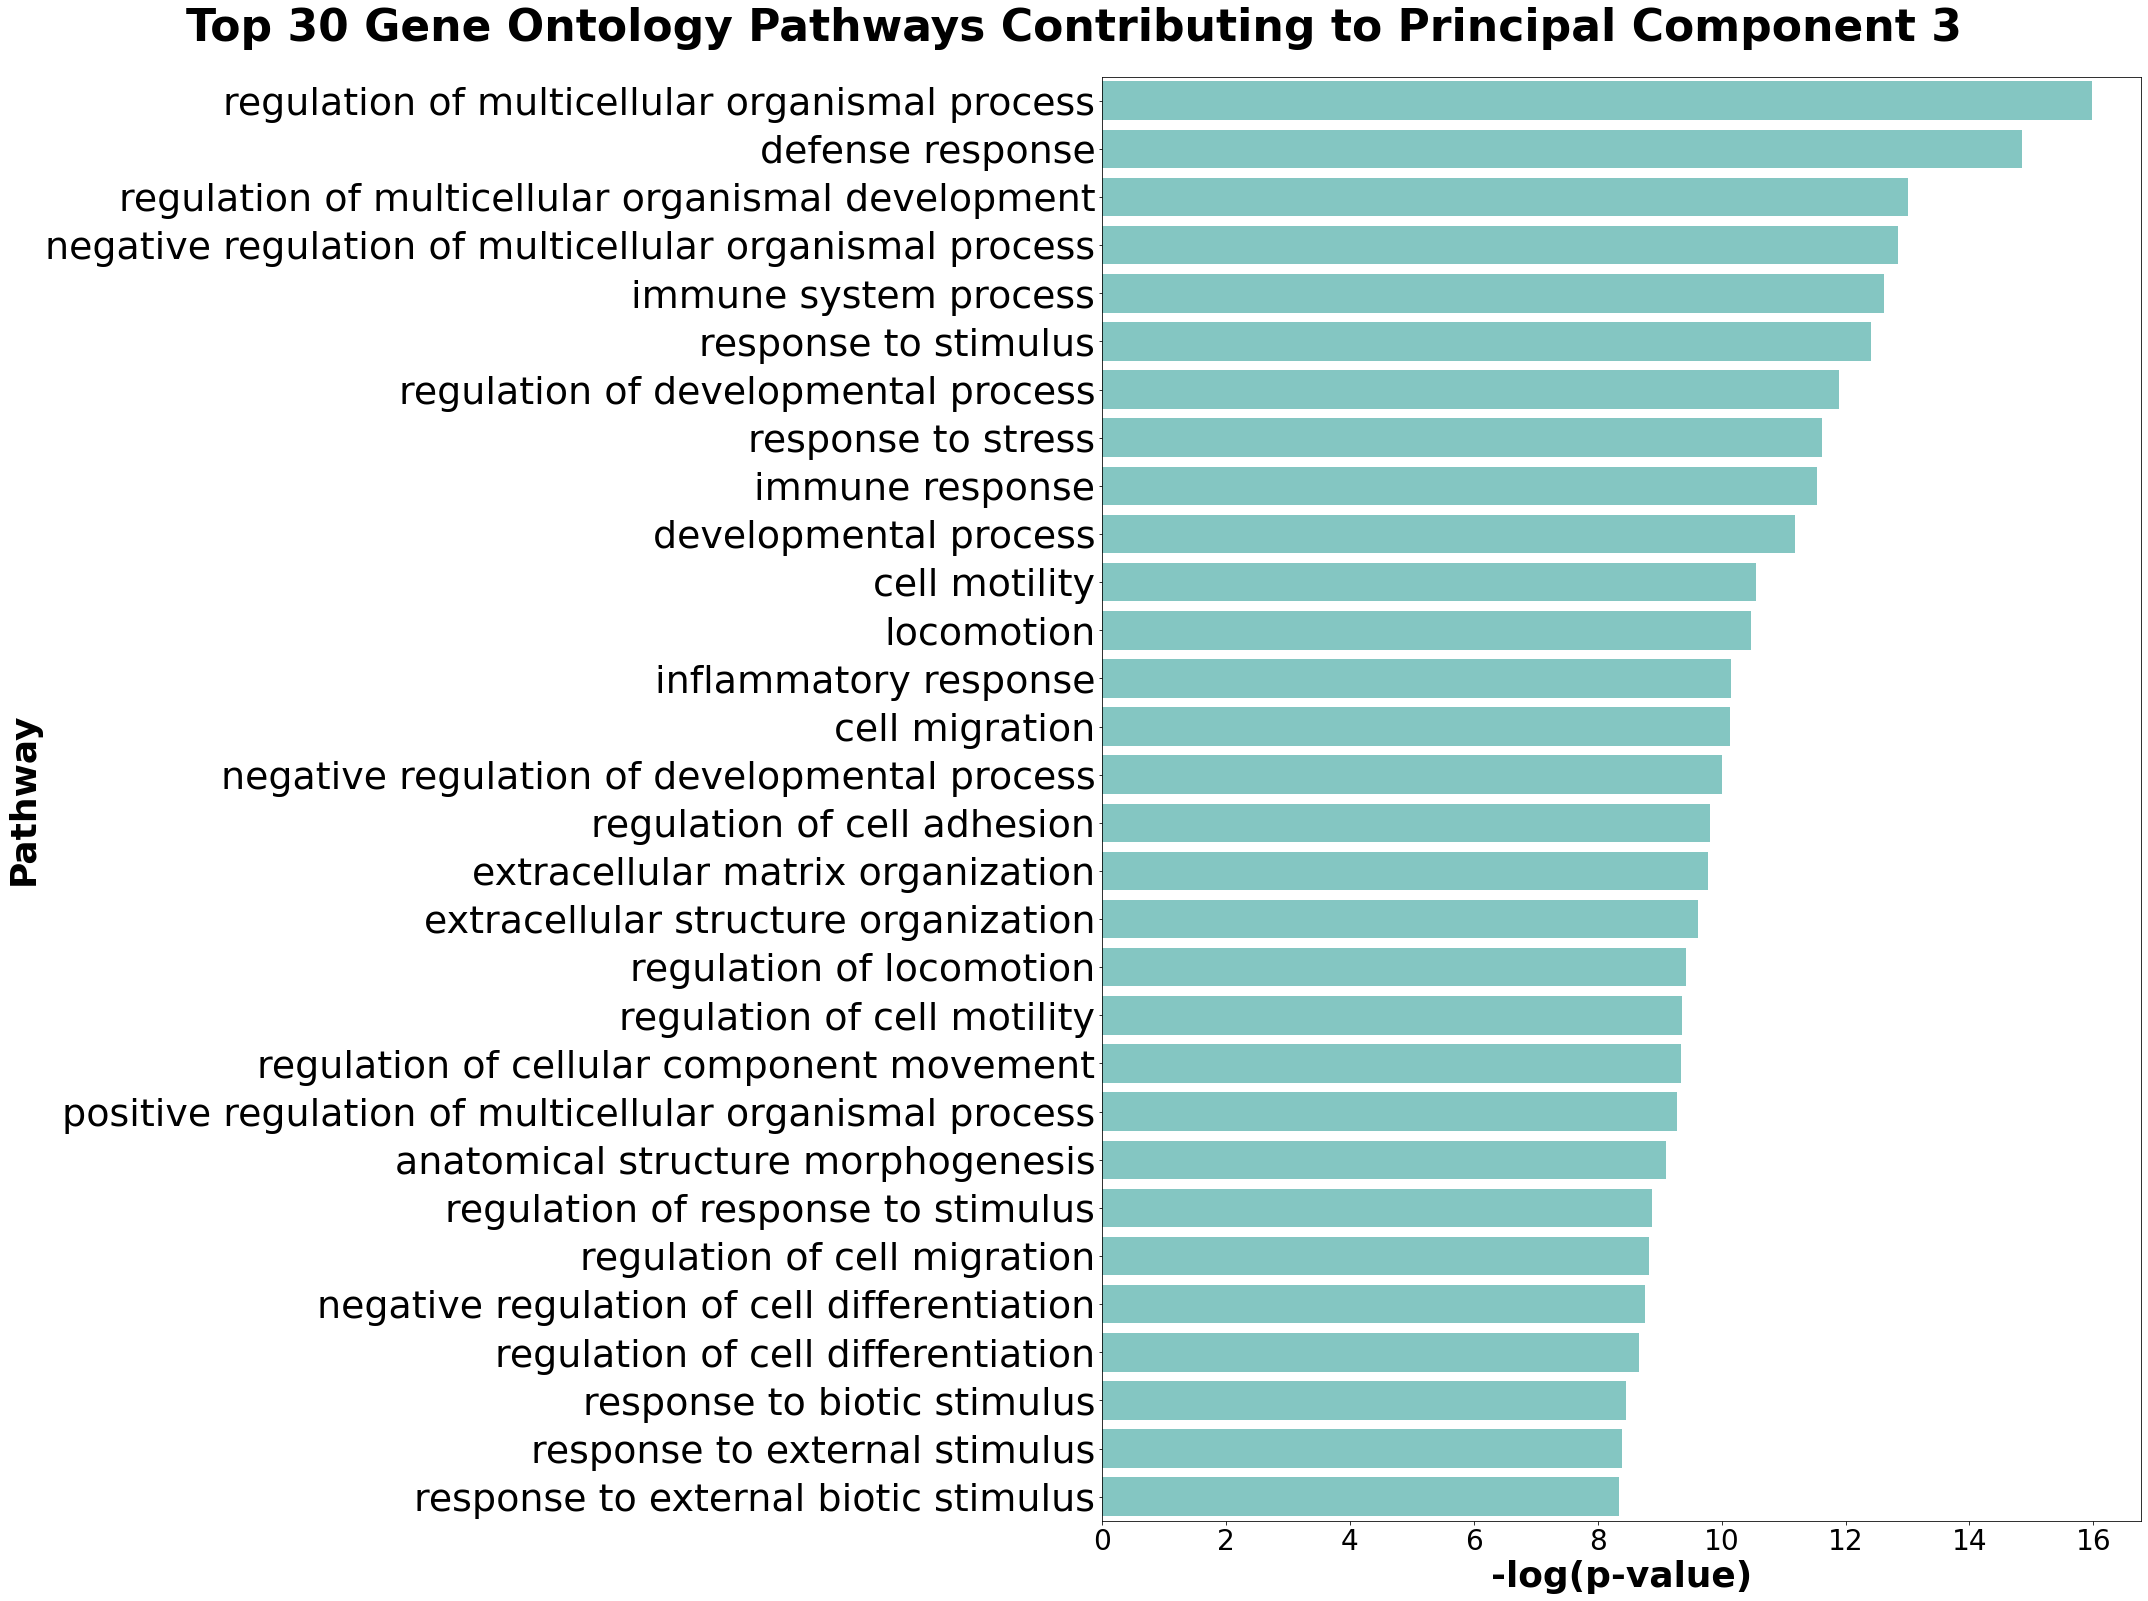

filtered: (30, 11)


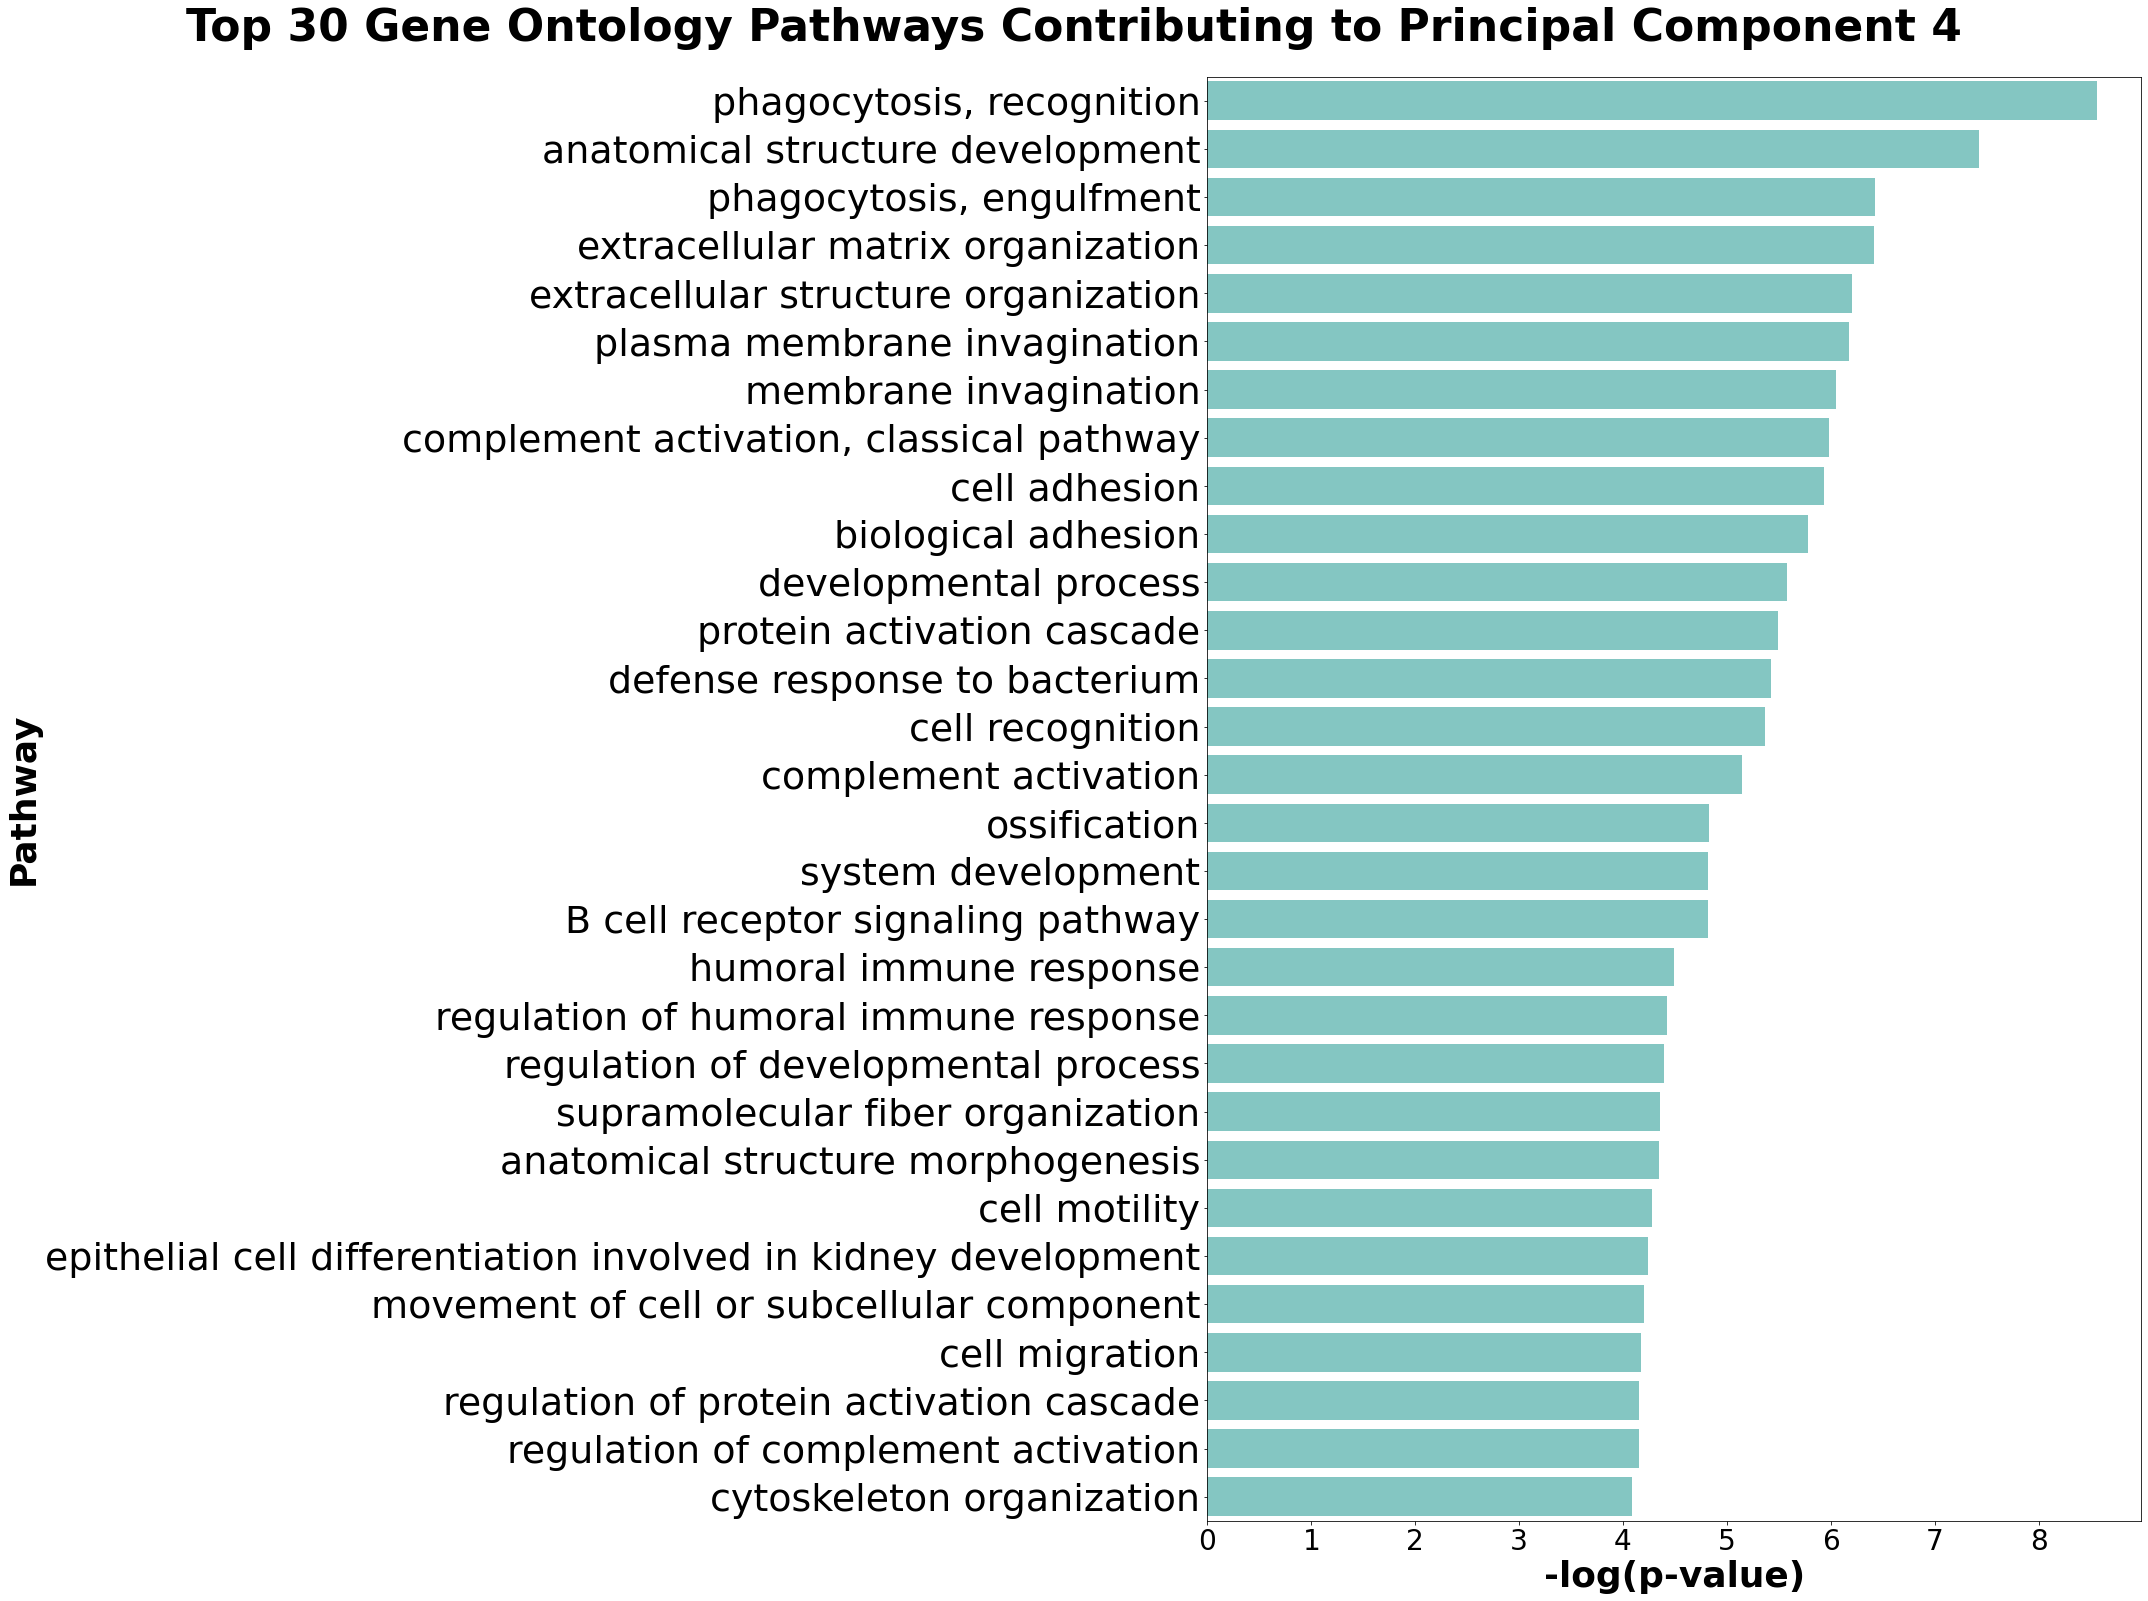

filtered: (30, 11)


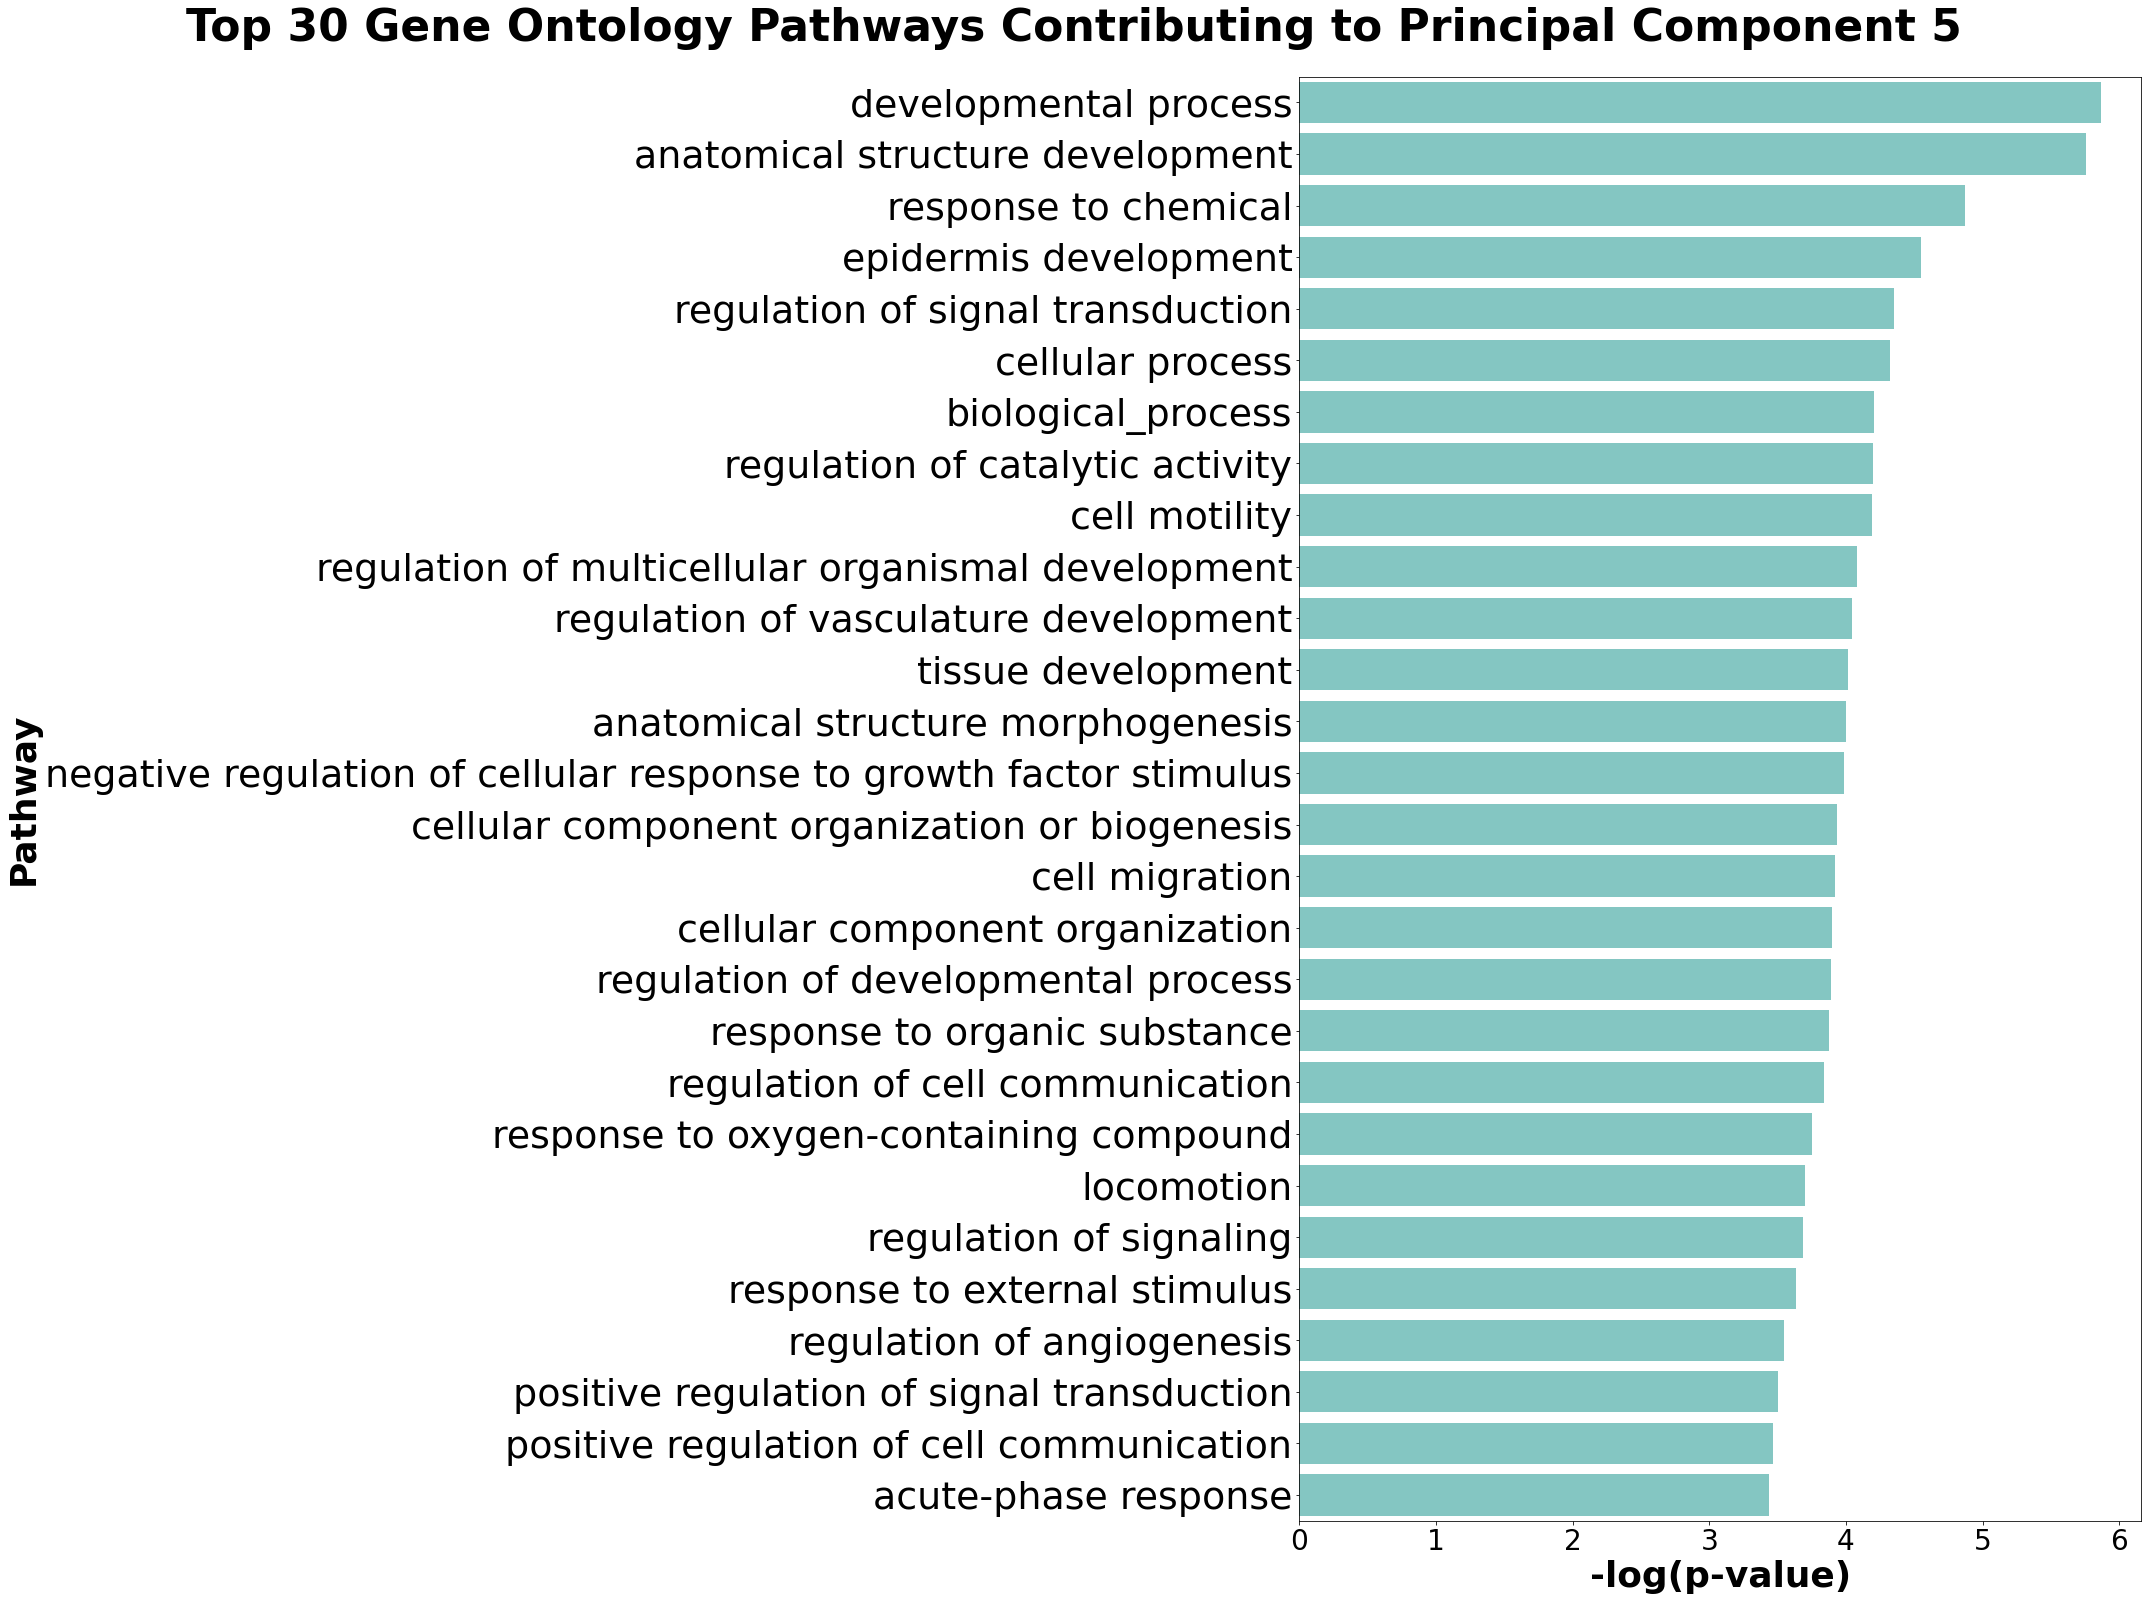

filtered: (30, 11)


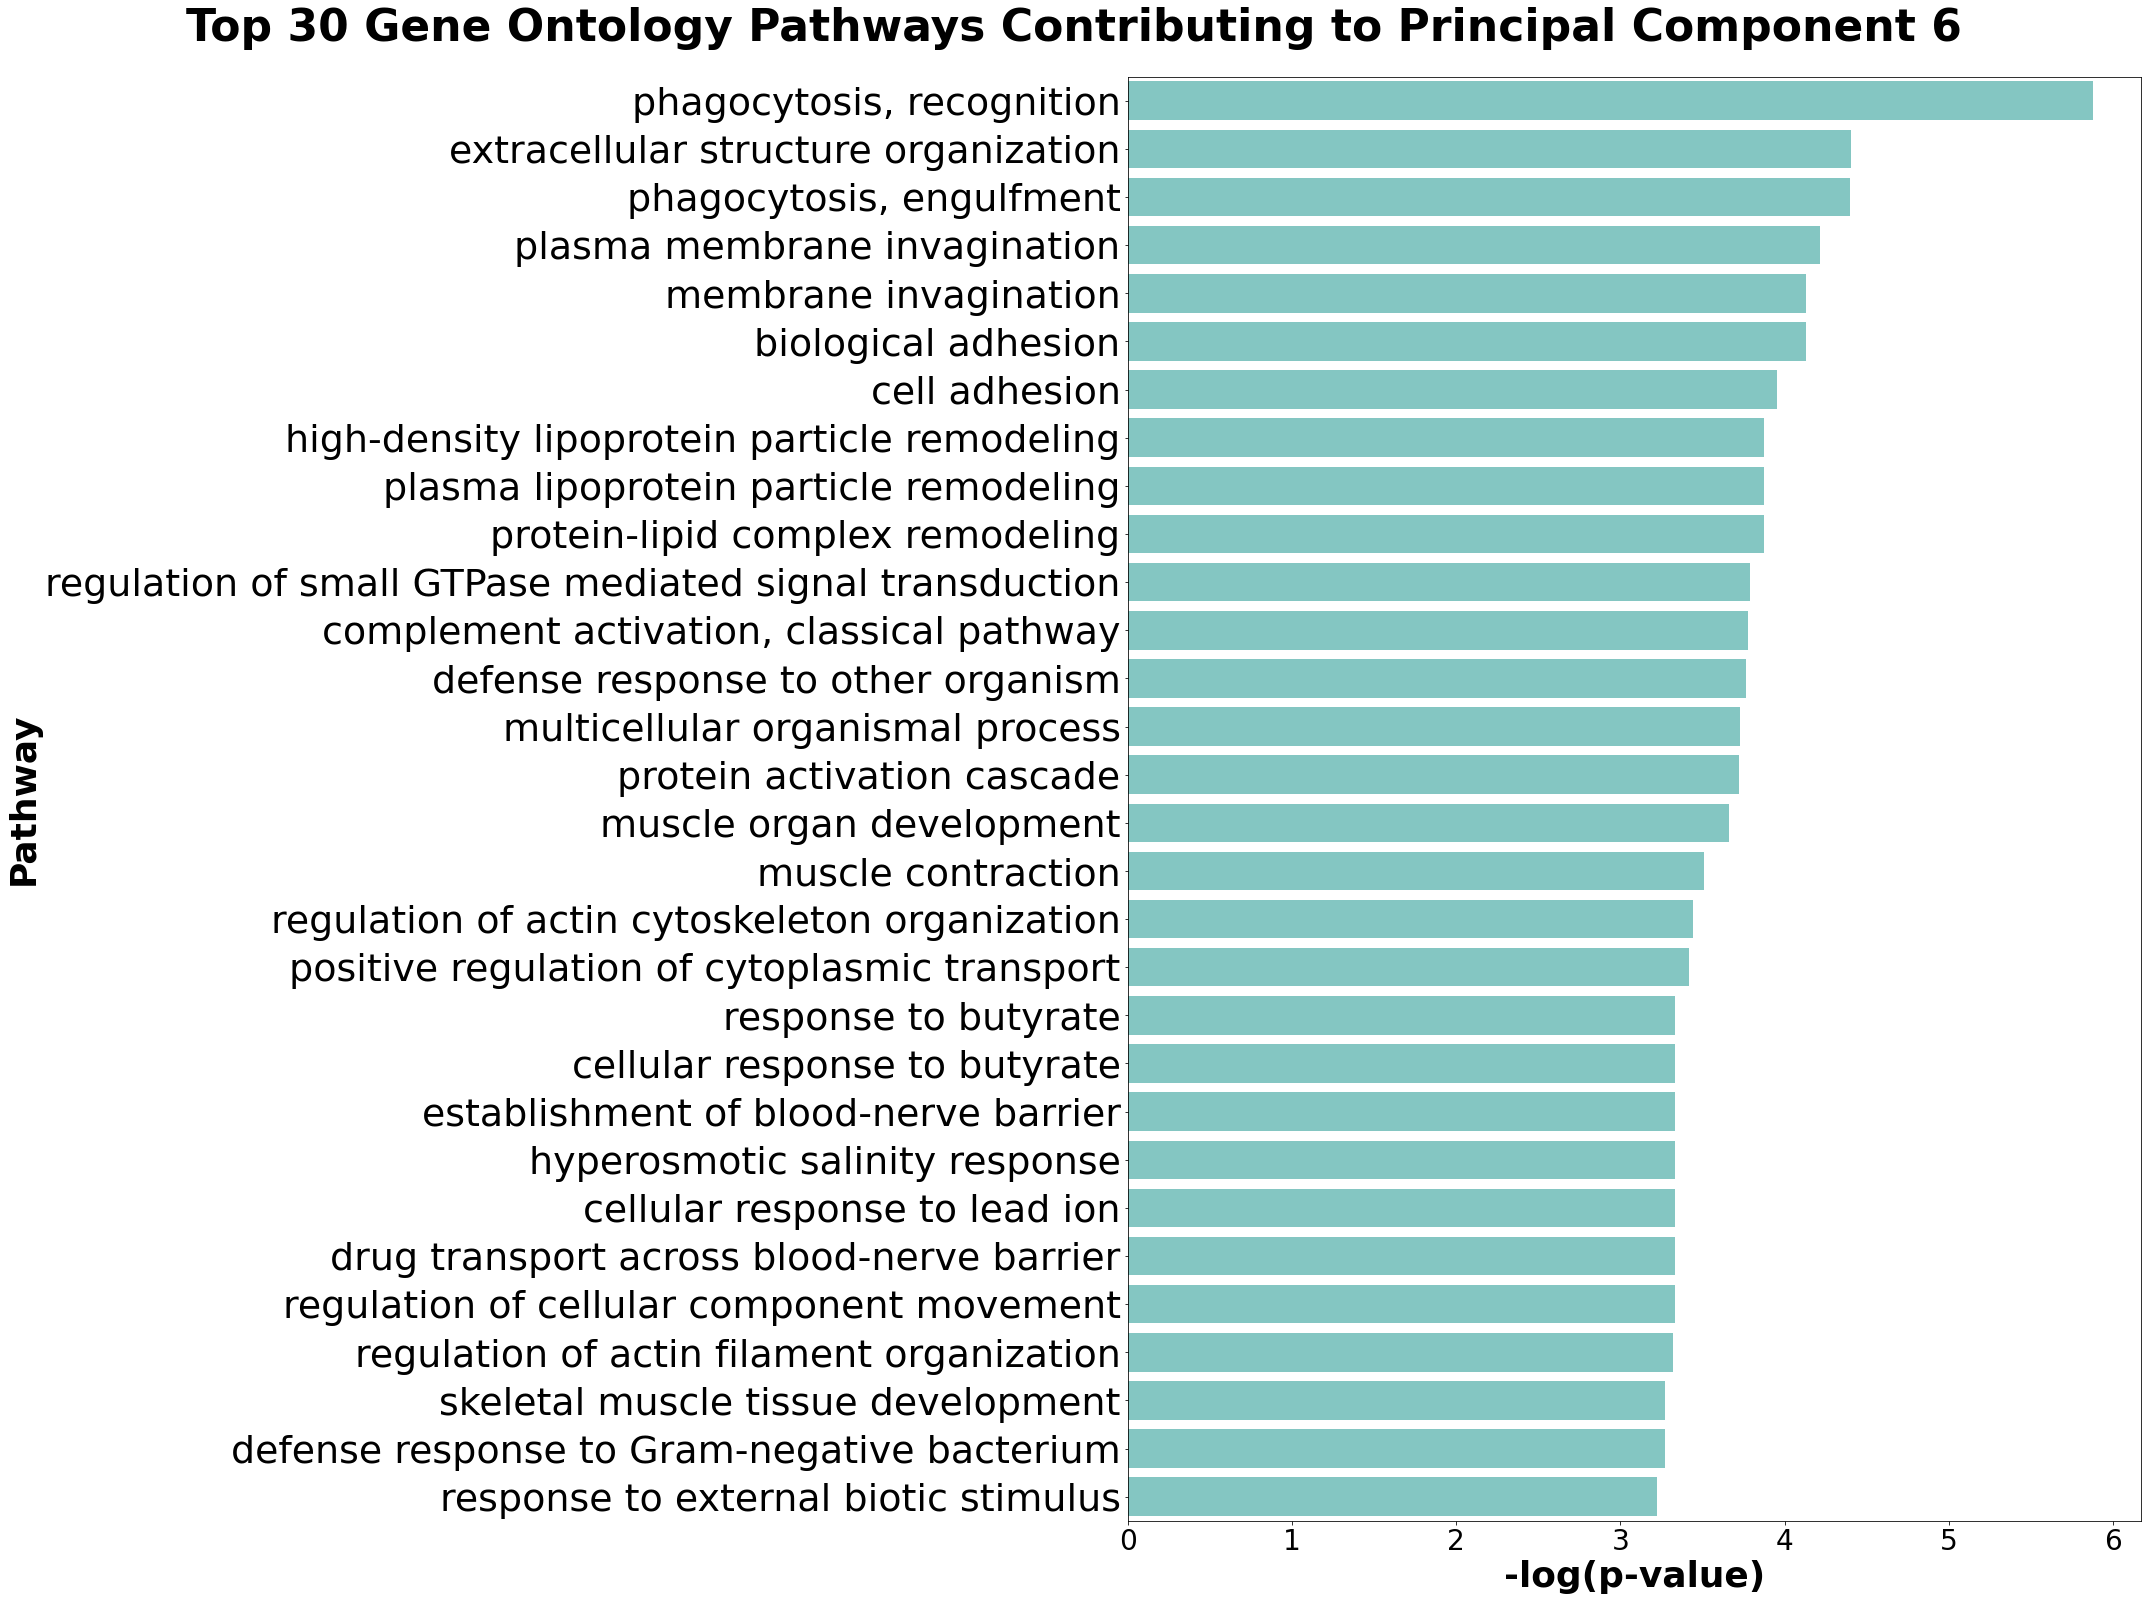

filtered: (30, 11)


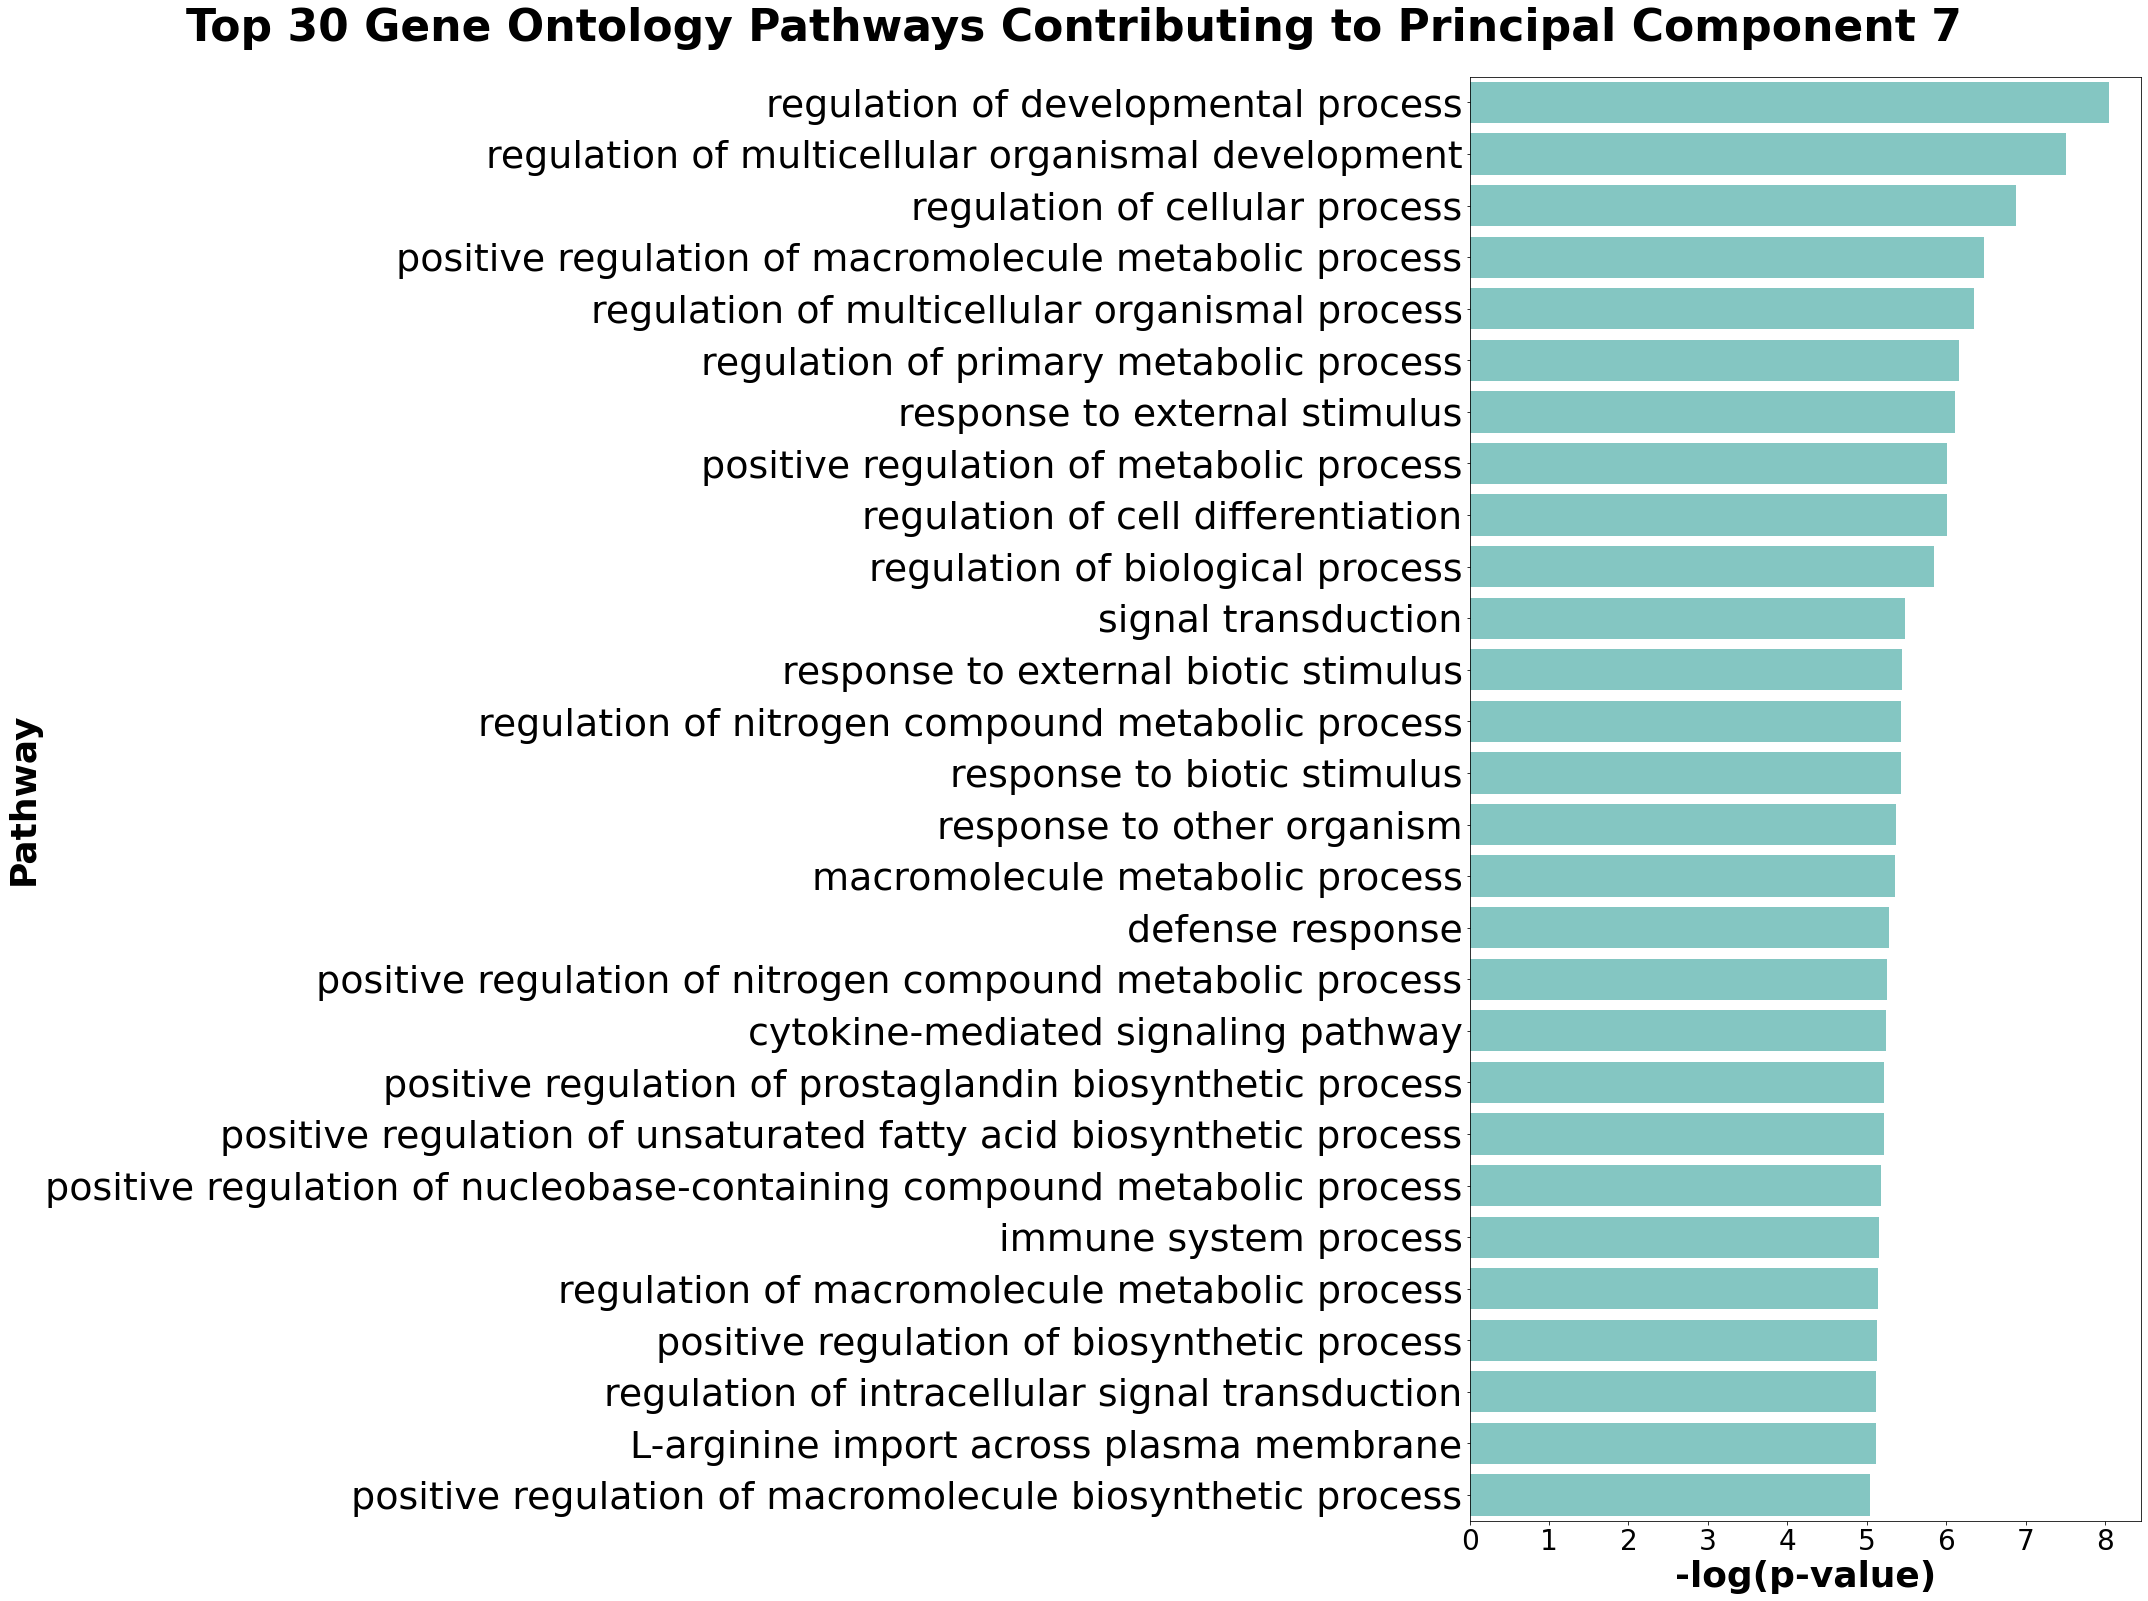

In [71]:
for sheet_name in sheet_names:
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"GOPROCESS_{added}")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # and 'p-value' containing the p-values
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")
    # Plotting the data
    num = num+1
    plt.figure(figsize=(30,22))  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=36, fontweight='bold')
    plt.ylabel('Pathway', fontsize=36, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Principal Component {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=44,  y=1.0005)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(38)
    plt.tight_layout()
    plt.xticks(fontsize=28)
    plt.show()

## NMF

Analyzing how close to negative the distributions of each residual are:

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


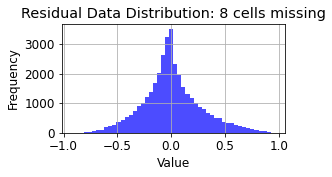

In [72]:
data = residuals_bulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

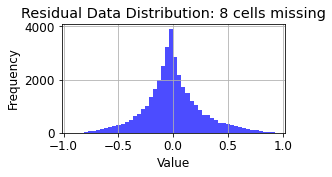

In [73]:
data = residuals_dissbulks.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Shifting distributions according to above plots, and calculating NMF:

0.9244300729061945


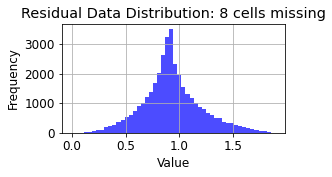

In [74]:
residuals_bulks_shift=residuals_bulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_bulks)))
    print(min_val)
    residuals_bulks_shift= residuals_bulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_bulks_shift[residuals_bulks_shift.values <= 0] = 0
data = residuals_bulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9244284684949222


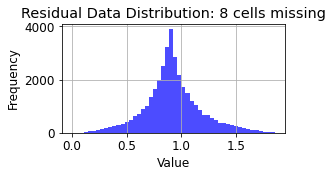

In [75]:
residuals_dissbulks_shift=residuals_dissbulks
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimally:
    min_val = abs(np.min(np.min(residuals_dissbulks)))
    print(min_val)
    residuals_dissbulks_shift= residuals_dissbulks + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_dissbulks_shift[residuals_dissbulks_shift.values <= 0] = 0
data = residuals_dissbulks_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

0.9244300729061945


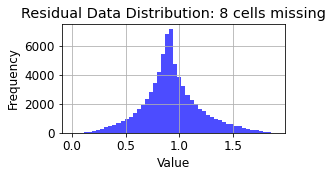

In [76]:
residuals_combo_shift=residuals_combo
if nmf_cut == "minimum_value":
    #calculate value to shift distributions minimcomboy:
    min_val = abs(np.min(np.min(residuals_combo)))
    print(min_val)
    residuals_combo_shift= residuals_combo + min_val
elif nmf_cut == "at_0":
    #cutting distribution at 0
    residuals_combo_shift[residuals_combo_shift.values <= 0] = 0
data = residuals_combo_shift.values
plt.figure(figsize=(4, 2)) 
plt.hist(data.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Residual Data Distribution: {num} cells missing')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### The combined residuals (classic and dissociated)

In [77]:
#nmf on residual combined
num_nmf_comp_combo = 4
nmf = NMF(n_components = num_nmf_comp_combo, init='nndsvd', max_iter=10000)
res_nmf_df = nmf.fit_transform(residuals_combo_shift)
res_nmf_combo = pd.DataFrame(res_nmf_df)
components_combo = pd.DataFrame(nmf.components_)
components_combo.columns = gene_ids
components_combo

A1BG       A2M     AAGAB      AASS      AATF      AATK      ABAT  \
0  0.079956  0.178708  0.125993  0.117377  0.110751  0.094383  0.144469   
1  0.059110  0.148169  0.089171  0.067078  0.093231  0.137254  0.082352   
2  0.107408  0.155776  0.133988  0.191179  0.103933  0.180915  0.130155   
3  0.055624  0.130007  0.096088  0.089388  0.068908  0.085995  0.089923   

      ABCA1     ABCA5     ABCB1  ...    ZNHIT1    ZNHIT3     ZNRF1     ZNRF3  \
0  0.143306  0.117419  0.126224  ...  0.061331  0.115456  0.106438  0.096898   
1  0.117858  0.149036  0.084580  ...  0.043594  0.074426  0.063937  0.094578   
2  0.149094  0.124930  0.123981  ...  0.030643  0.110023  0.098936  0.128651   
3  0.110578  0.055854  0.091715  ...  0.057317  0.070748  0.076637  0.082381   

       ZPR1     ZRSR2   ZSCAN18    ZSWIM8      ZXDC       ZYX  
0  0.094275  0.109822  0.117689  0.169156  0.145198  0.153529  
1  0.116266  0.072070  0.104747  0.123321  0.148583  0.056552  
2  0.252951  0.109830  0.134210  0.169214  0.118965  0.211732  
3  0.121720  0.079429  0.134457  0.167293  0.107830  0.089700  

[4 rows x 4584 columns]

In [78]:
# Separate the data into "classic bulks" and "dissociated bulks"
df = res_nmf_combo
classic_bulks = df.iloc[:8, :]
dissociated_bulks = df.iloc[8:, :]

# Perform t-test for each component
results = pd.DataFrame(columns=['Component', 'T-Statistic', 'P-Value'])

for column in df.columns:
    t_statistic, p_value = stats.ttest_ind(classic_bulks[column], dissociated_bulks[column])
    results = results.append({'Component': column, 'T-Statistic': t_statistic, 'P-Value': p_value}, ignore_index=True)

# Print the results
print(results)

# Identify components with significantly different means
significantly_different = results[results['P-Value'] < 0.05]
print("Components with significantly different means:")
print(significantly_different)

   Component  T-Statistic   P-Value
0        0.0     1.829419  0.088711
1        1.0     0.189204  0.852649
2        2.0    -1.499484  0.155958
3        3.0    -0.476755  0.640893
Components with significantly different means:
Empty DataFrame
Columns: [Component, T-Statistic, P-Value]
Index: []


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


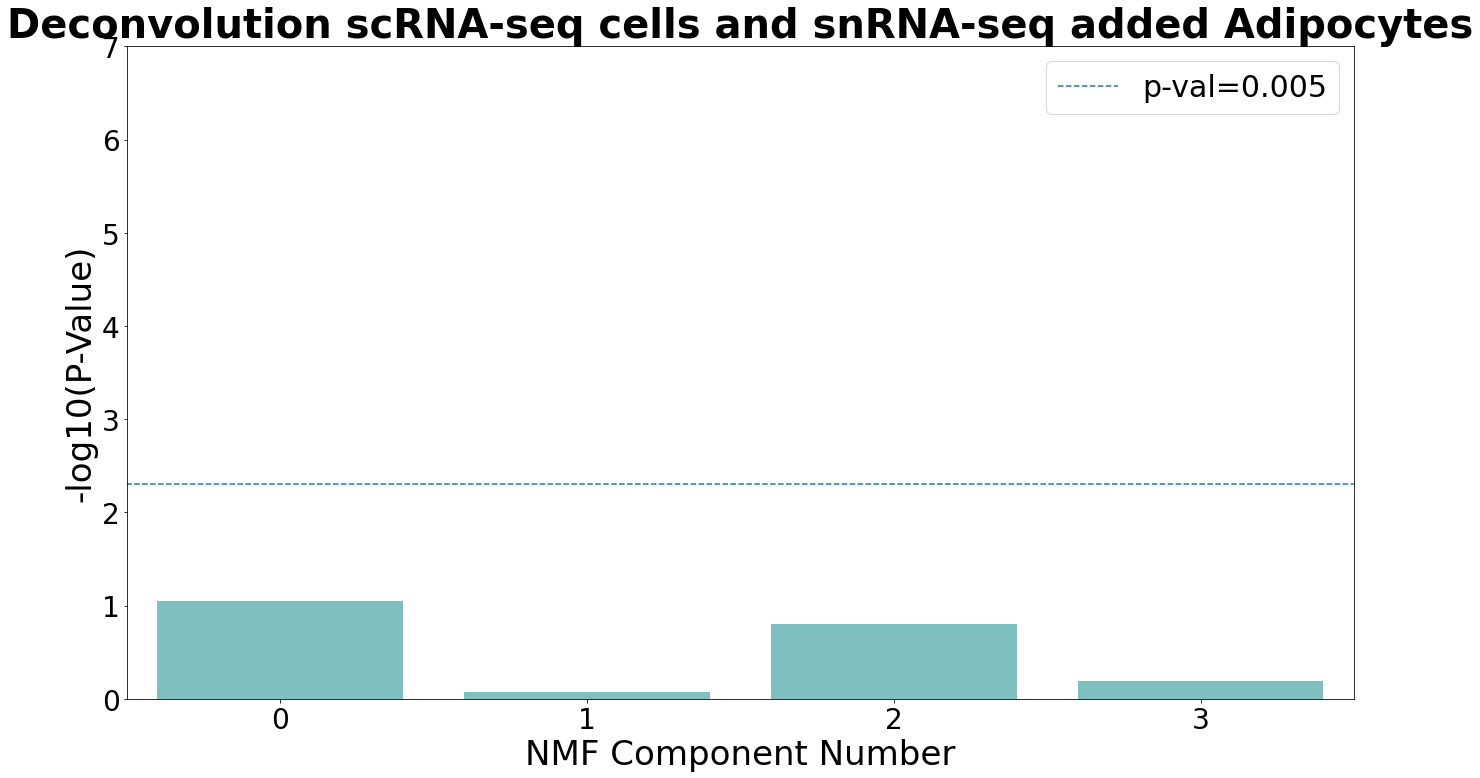

In [79]:
# Bar plot for each component
plt.figure(figsize=(22,12))
plt.bar(results['Component'], -np.log10(results['P-Value']), color='teal', alpha=0.5)

plt.xlabel('NMF Component Number', fontsize=34, fontname='Arial')
plt.ylabel('-log10(P-Value)', fontsize=34, fontname='Arial')
plt.plot([-1,0,1,2,3,4],np.repeat(-np.log10(0.005),6),linestyle='--', label='p-val=0.005')
if add_adipo == True:
    title_str = 'Deconvolution scRNA-seq cells and snRNA-seq added Adipocytes'
else:
    title_str ='Deconvolution only with scRNA-seq cells (No Adipocytes)'
plt.title(title_str, fontsize=40, fontname='Arial', fontweight='bold')
plt.xticks([0,1,2,3], fontsize=28)
plt.yticks(fontsize=28)
plt.ylim(0,7)
plt.xlim(-0.5,3.5)
plt.legend(fontsize=30)
plt.show()

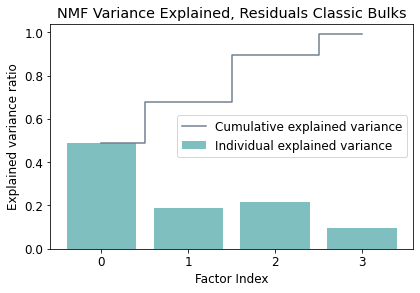

In [80]:
# W and H are your NMF results
V = residuals_combo_shift.values
W = res_nmf_combo.values
H = components_combo.values # Solve for H using least squares

# Calculate the explained variance for each component
explained_variance = []
for i in range(W.shape[1]):
    WH = np.dot(W[:, :i+1], H[:i+1, :])
    explained_variance.append(1 - np.linalg.norm(V - WH, 'fro')**2 / np.linalg.norm(V, 'fro')**2)

cum_sum = explained_variance

indiv_variance =  [cum_sum[0], 
                cum_sum[1] - cum_sum[0],
                cum_sum[2]- cum_sum[1],
                cum_sum[3] - cum_sum[2],
]

## plot variance explained
plt.bar(range(0,len(indiv_variance)), indiv_variance, alpha=0.5, align='center', label='Individual explained variance', color='teal')
plt.step(range(0,len(cum_sum)), cum_sum, where='mid',label='Cumulative explained variance', color='slategrey')
plt.ylabel('Explained variance ratio')
plt.xlabel('Factor Index')
plt.legend(loc='best')
plt.xticks([0,1,2,3])
plt.tight_layout()
plt.title(f"NMF Variance Explained, Residuals Classic Bulks")
plt.show()

In [81]:
W = res_nmf_combo.values
H = components_combo.values

nmf_genes_combo = pd.DataFrame()
num_components = num_nmf_comp_combo

# Iterate through each component
for component_idx in range(num_components):

    # Sort genes by their influence on the current component
    sorted_genes = residuals_combo.columns[np.argsort(H[component_idx])]

    # Visualize the top N genes that contribute the most to the current component
    N = len(sorted_genes)
    top_genes = sorted_genes[-N:]

    nmf_genes_combo[component_idx] = top_genes[::-1]
    
nmf_genes_combo.columns = ["Component_0","Component_1","Component_2","Component_3"]
nmf_genes_combo

Component_0 Component_1 Component_2 Component_3
0          CIITA     TFCP2L1         LIF     PLEKHG5
1           LY75        ACPP     ZC3H12A        SDC1
2           TAP2       ANPEP        RND3         PPL
3        SIGLEC1     RAPGEF3      KLHL21       LAMB3
4         SLFN11       VTCN1        CDH5       WDR91
...          ...         ...         ...         ...
4579         CKB      AKAP12       EVA1B       IGLC2
4580         ID1      CCDC80      CLEC2B        IGKC
4581         MGP     SELENOP    HIST1H1D       IGHG1
4582      B3GNT5       IGHA1     TNFSF10        MT1M
4583        IRS2        CDK6       VAMP5       CRYAB

[4584 rows x 4 columns]

And plotting gene ontology analysis pathways.

NOTE: You'll have to run GOrilla for this part!

In [82]:
# The sheets on the Excel
if add_adipo:
    added = "NMF_genes_residuals_combo_ADIP.xlsx"
else:
    added ="NMF_genes_residuals_combo.xlsx"
sheet_names = ['Component_0','Component_1','Component_2','Component_3']  

In [83]:
#Exporting NMF genes per component.
nmf_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"{added}")
nmf_genes_combo.to_excel(nmf_name_path, sheet_name = "NMF_Components_Genes")

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


filtered: (30, 11)


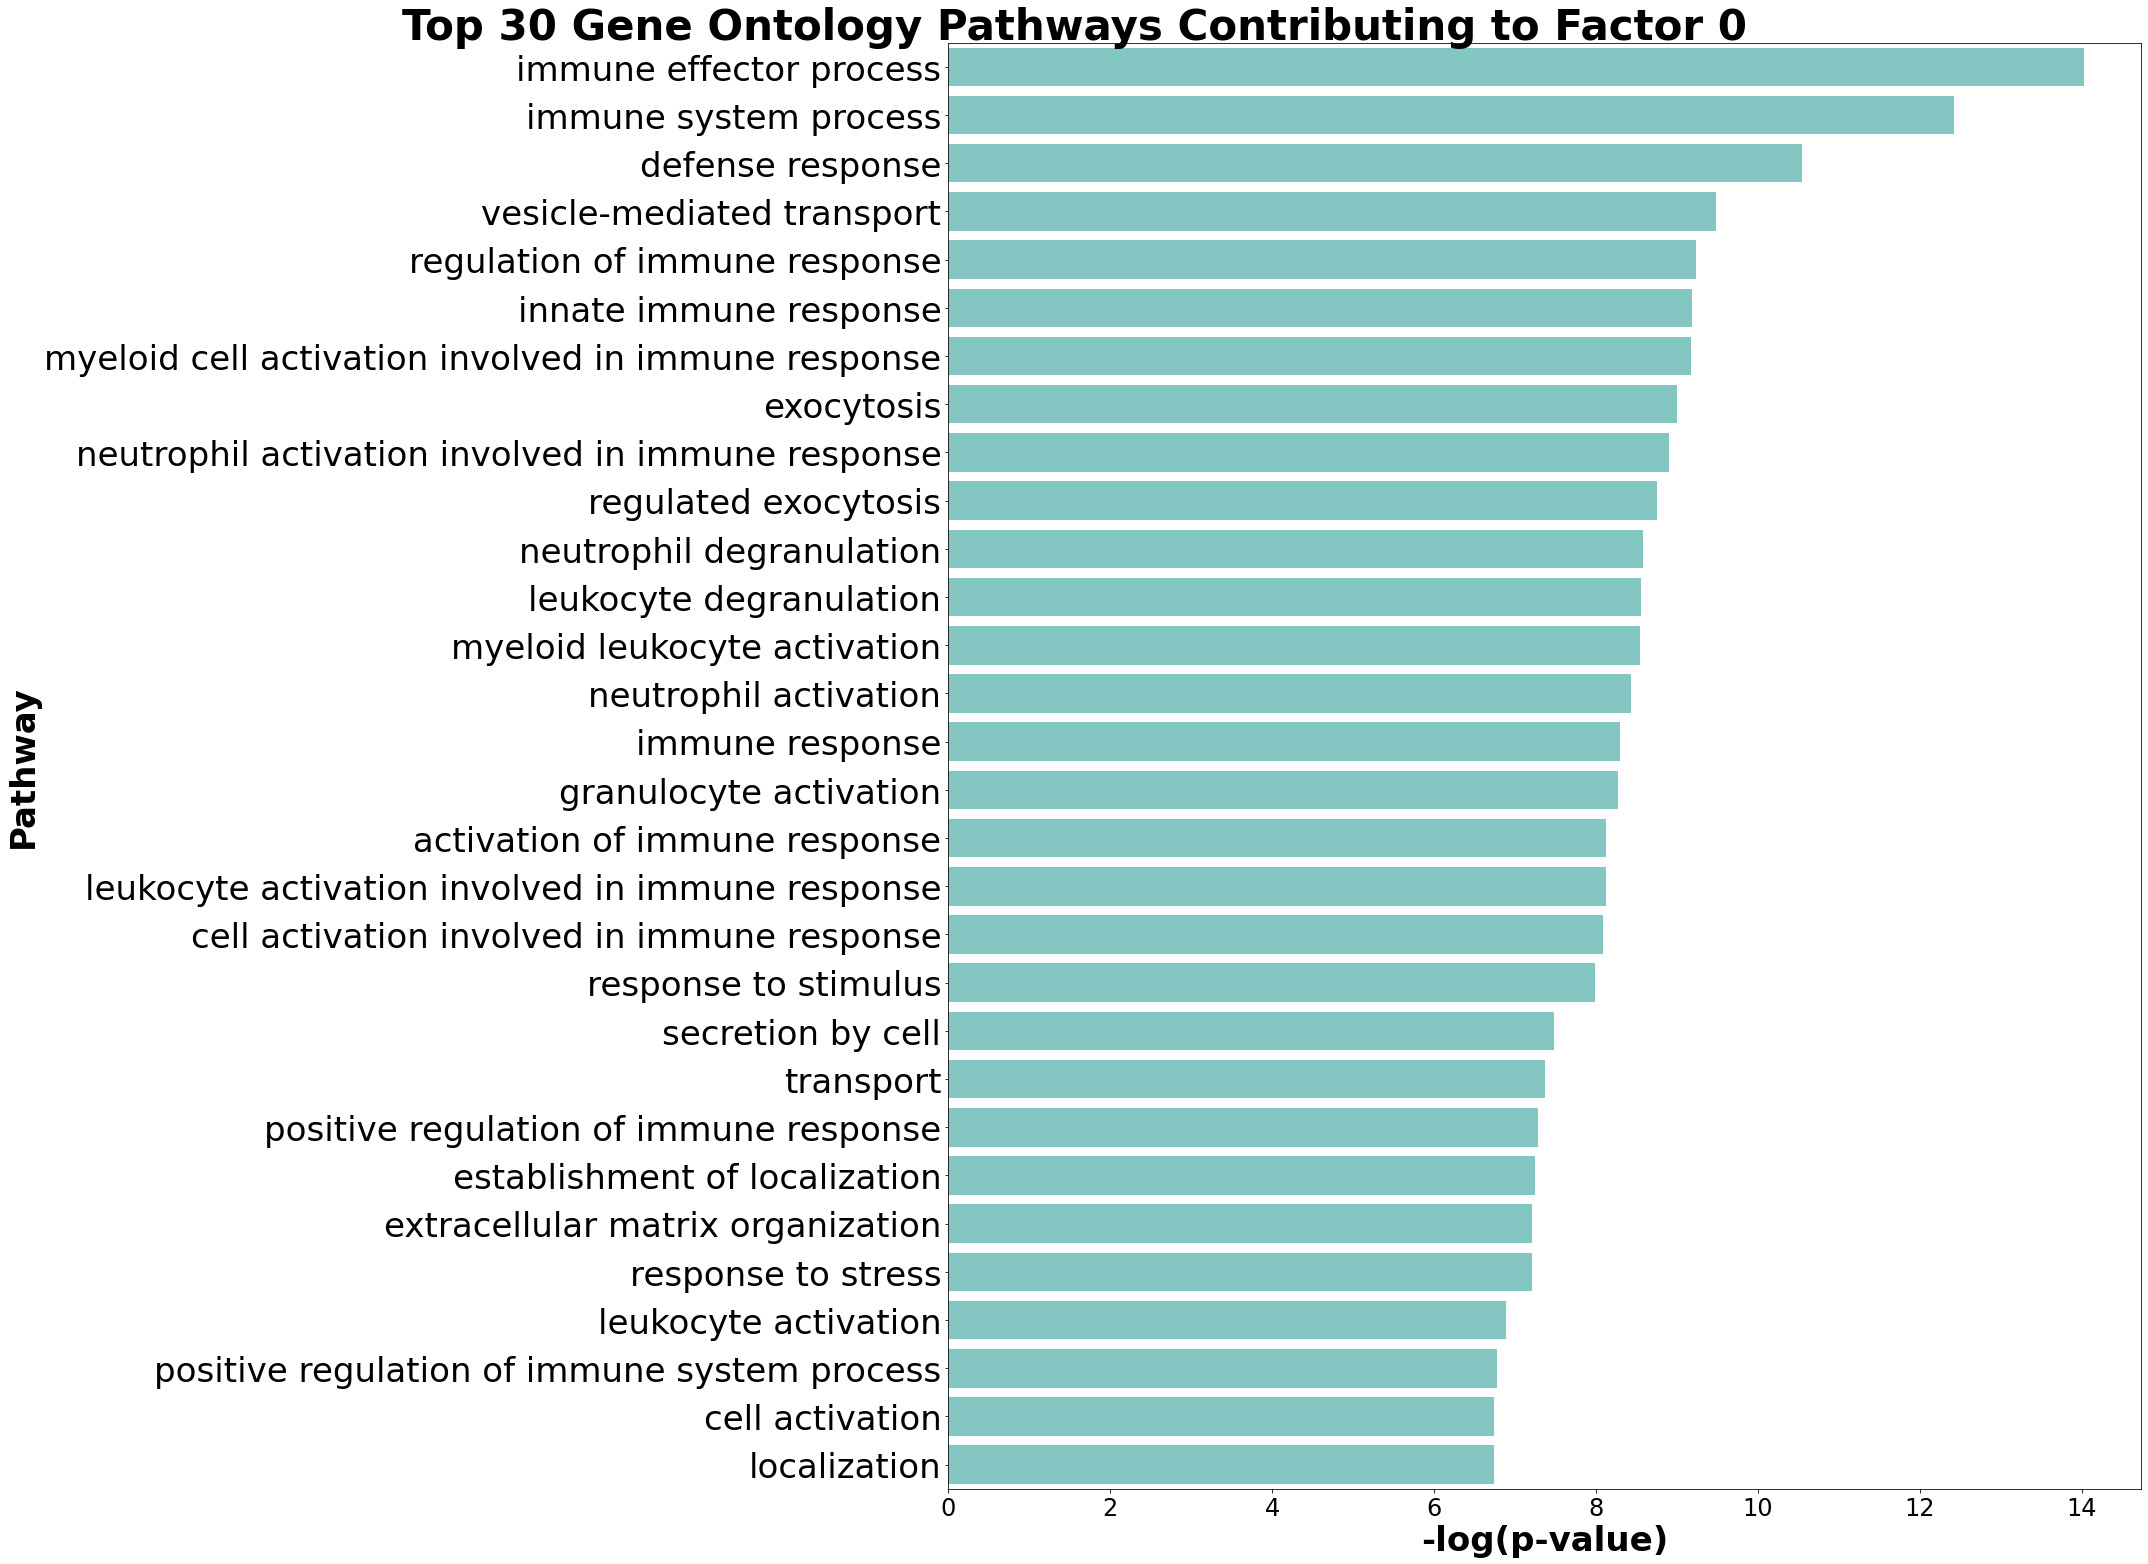

filtered: (21, 11)


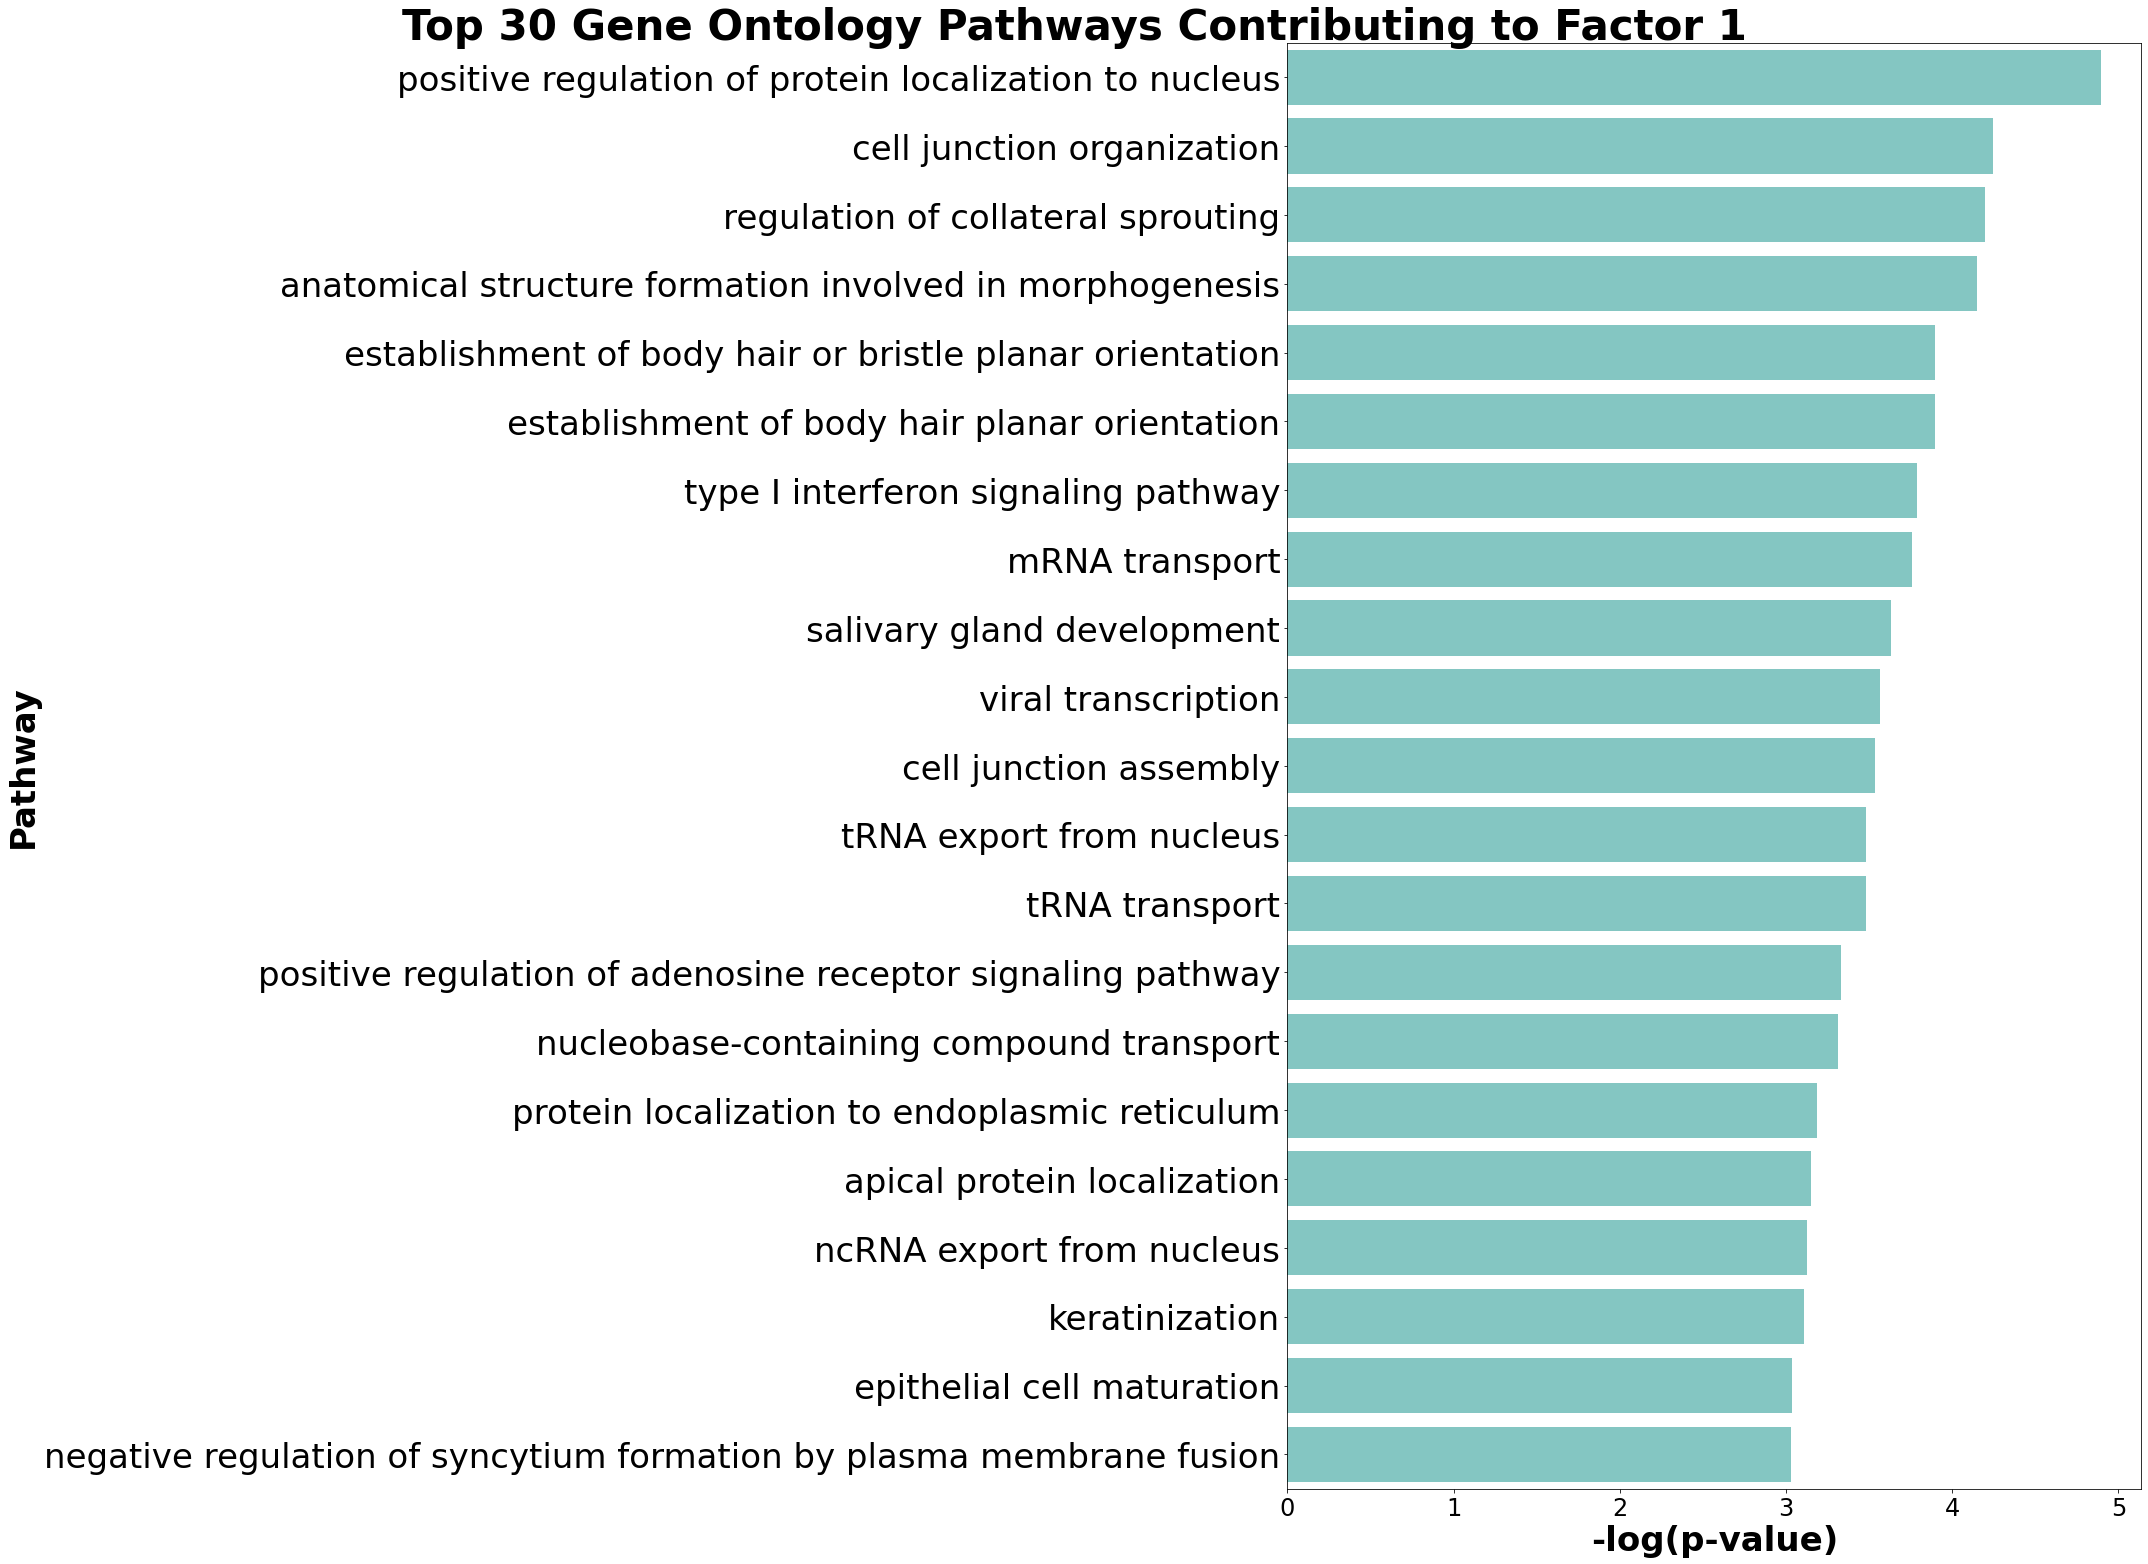

filtered: (30, 11)


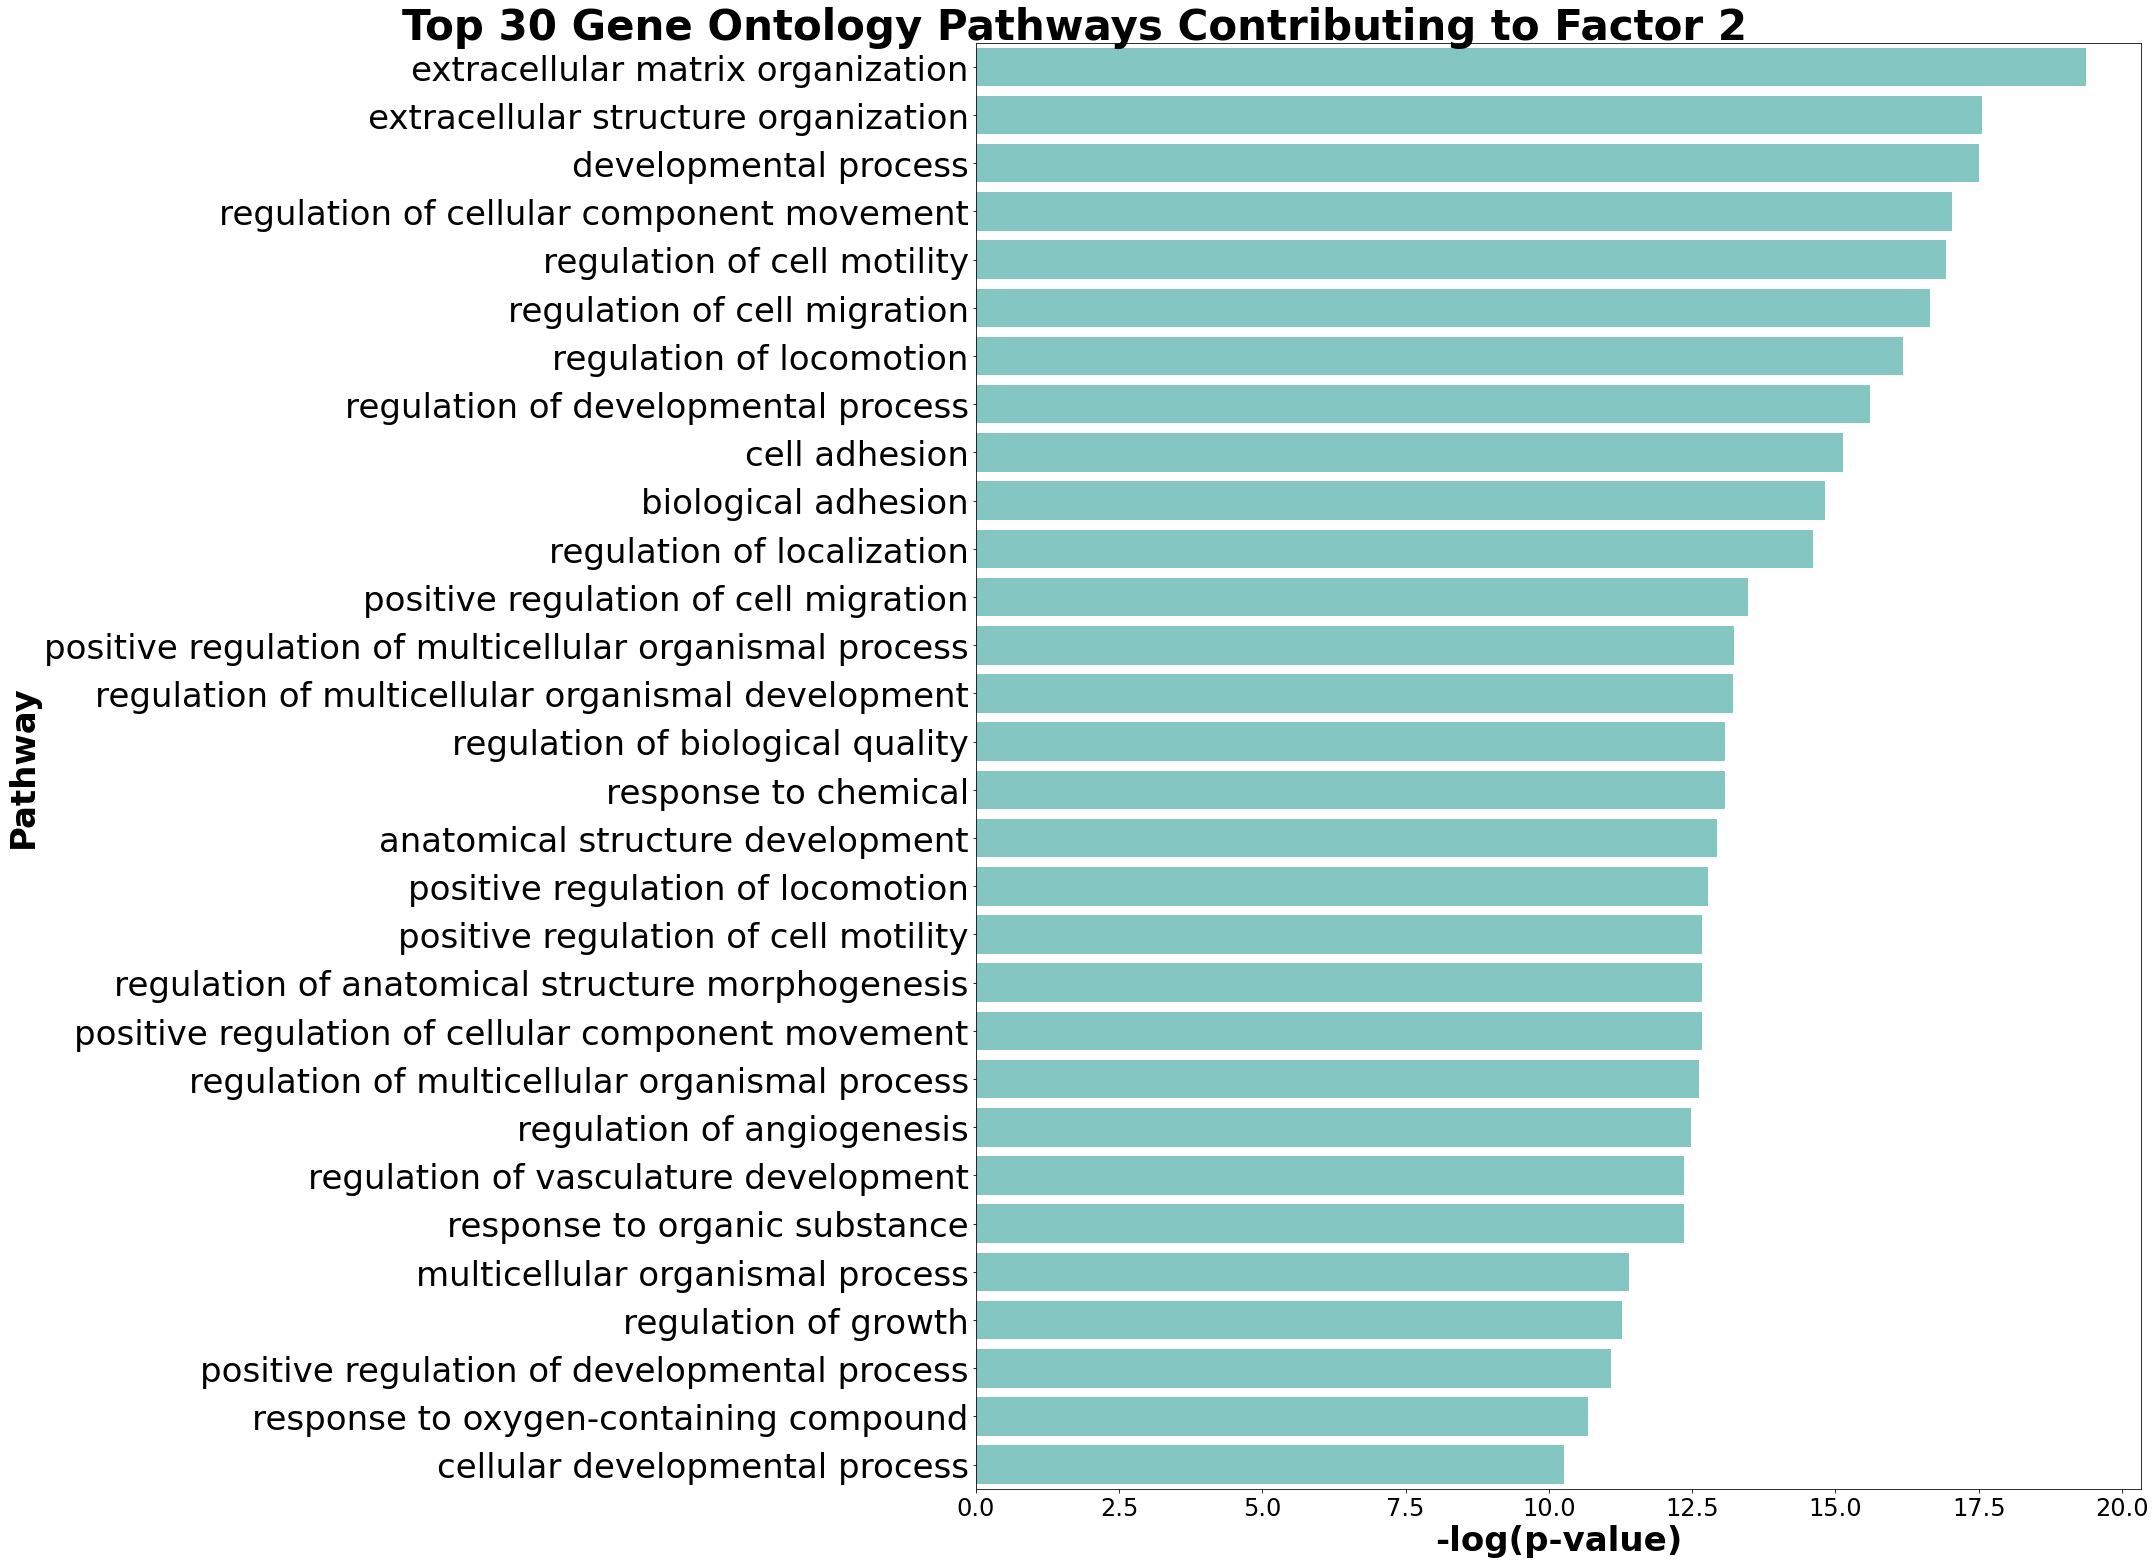

filtered: (30, 11)


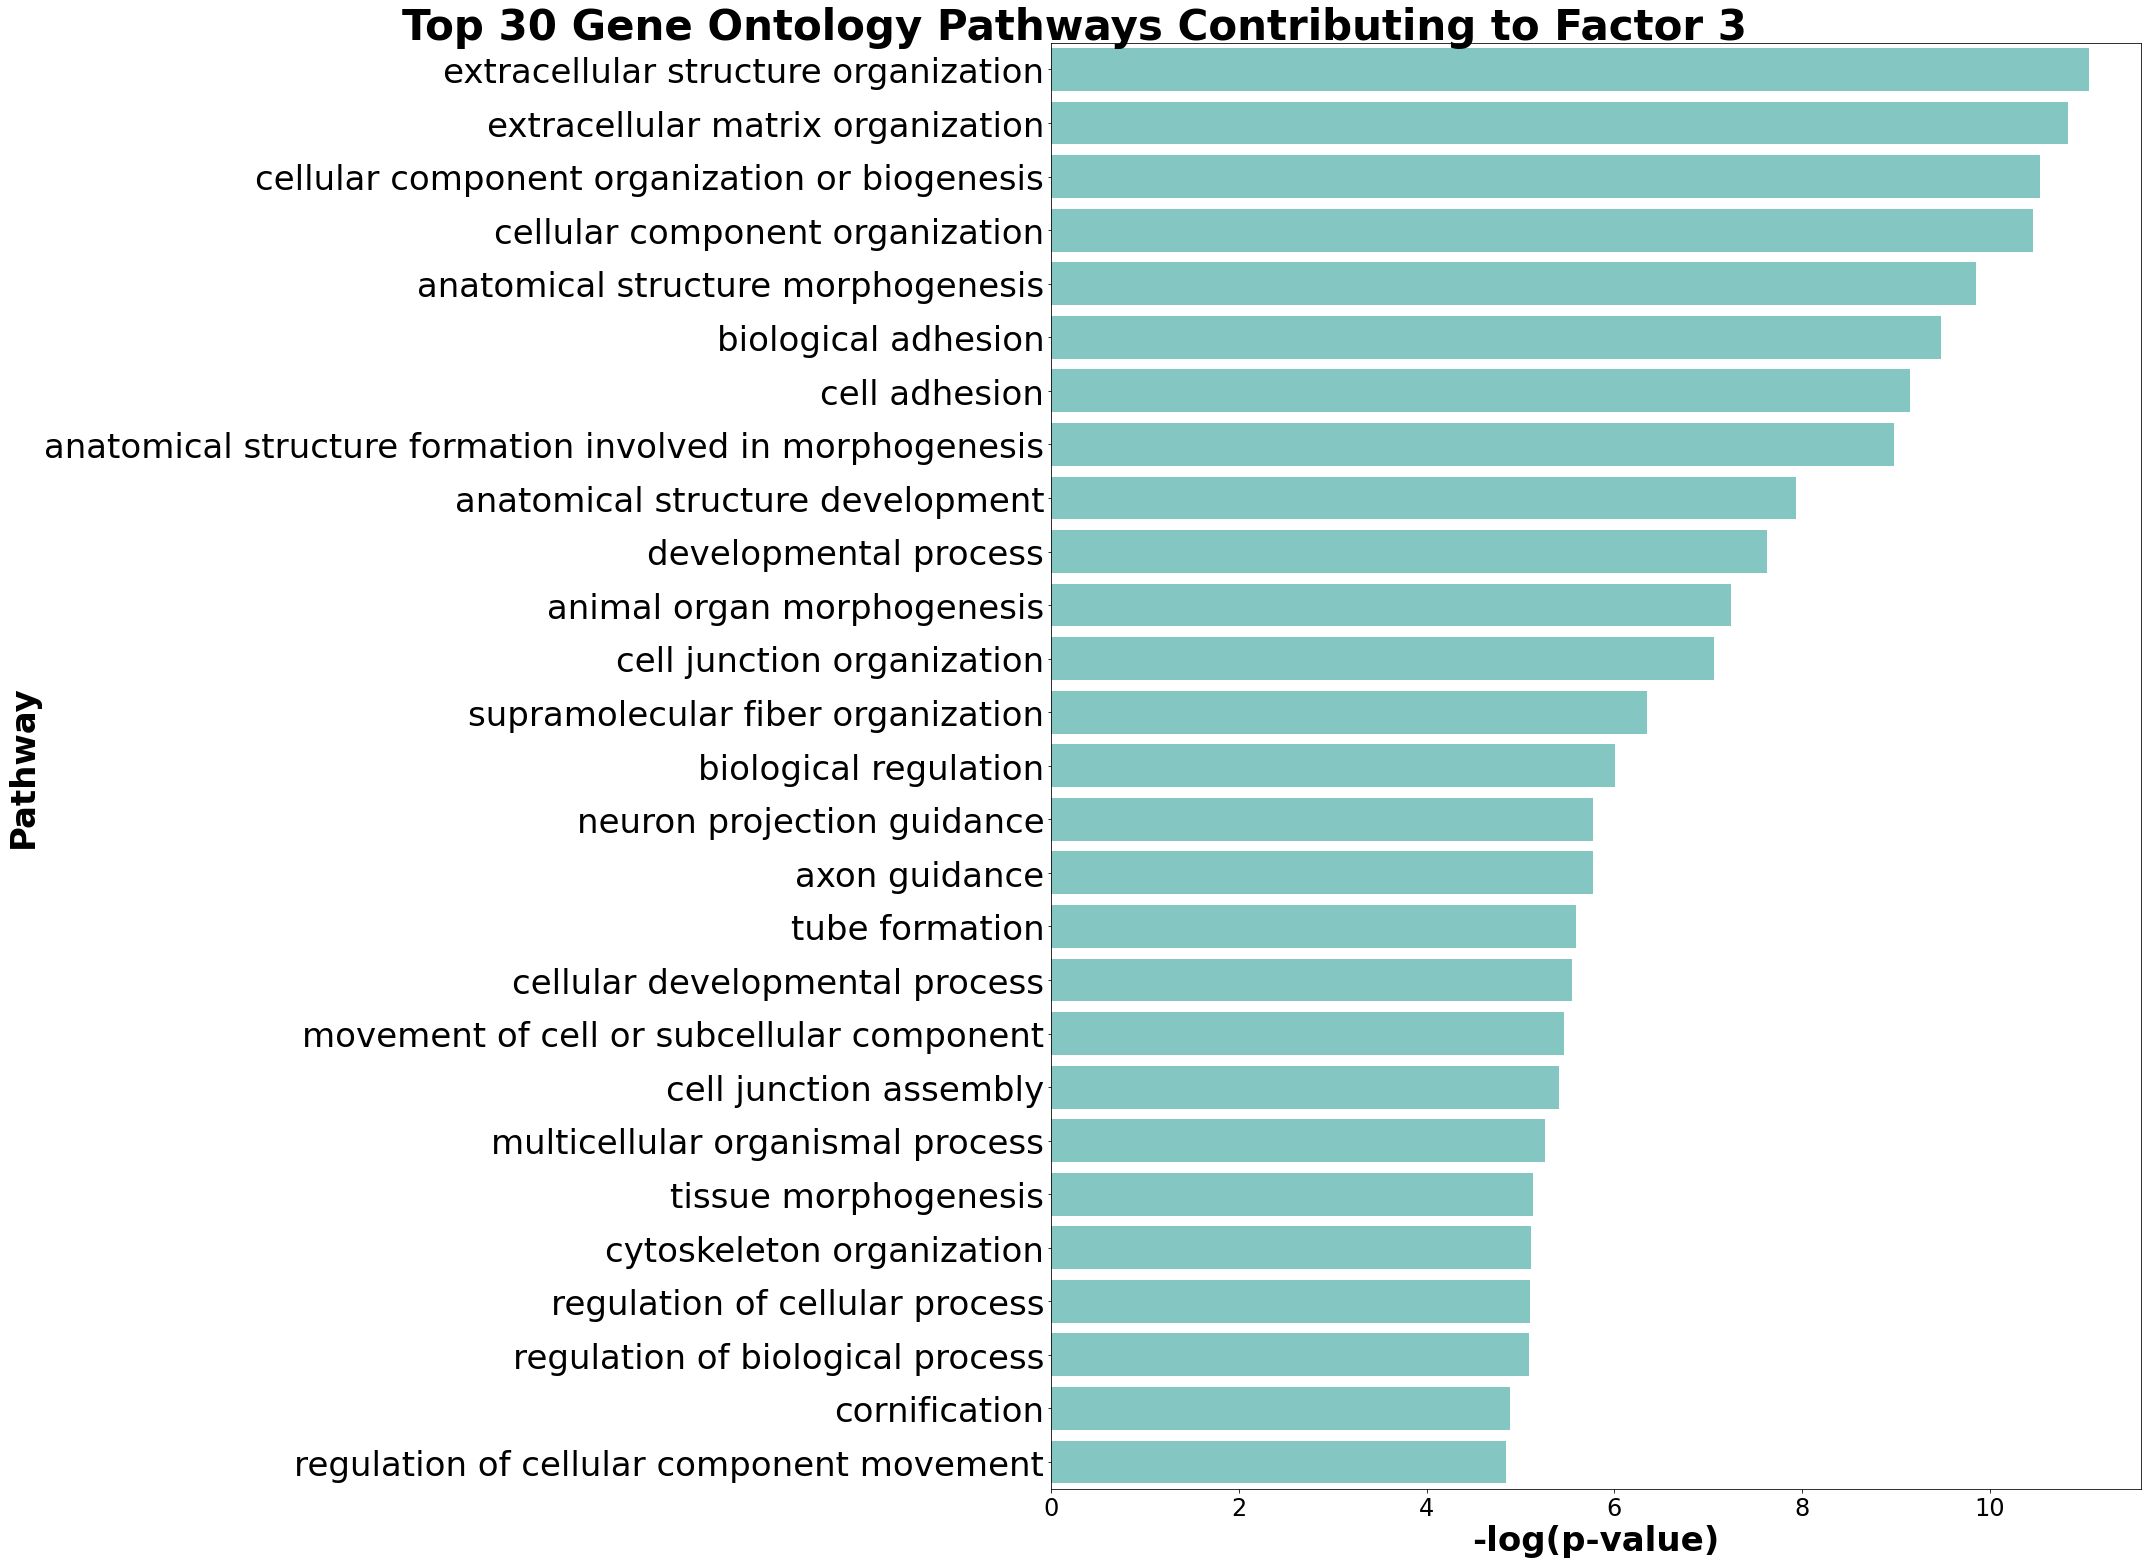

In [84]:
num=0
for sheet_name in sheet_names:
    
    # Reading the Excel sheet into a DataFrame
    pca_name_path = Path(f"{os.getcwd()}/../results/EXP5/", f"GOPROCESS_{added}")
    data = pd.read_excel(pca_name_path, sheet_name = sheet_name)
    data["-logpvalue"] = -np.log10(data["P-value"])
    # Filter the DataFrame for pathways related to adipocyte functions
    # and 'p-value' containing the p-values
    filtered_data = data.loc[0:29]
    print(f"filtered: {filtered_data.shape}")
    # Plotting the data
    num = num+1
    plt.figure(figsize=(30,22))  
    bar_plot = sns.barplot(x='-logpvalue', y='Description', data=filtered_data, color='lightseagreen',alpha=0.6)
    plt.xlabel('-log(p-value)', fontsize=34, fontweight='bold')
    plt.ylabel('Pathway', fontsize=34, fontweight='bold')
    plt.suptitle(f'Top 30 Gene Ontology Pathways Contributing to Factor {sheet_name[-1]}',
               fontname = 'Arial',fontweight='bold', fontsize=42)
    # Set the weight of the y-axis labels to bold
    for label in bar_plot.get_yticklabels():
        label.set_fontsize(34)
    plt.tight_layout()
    plt.xticks(fontsize=24)
    plt.show()